# Problem Statement

We have been provided the dataset related to a marketing campaign done by a Portuguese Bank. The campaigns were telephonic, i.e., sales agents made phone calls to sell a term deposit product.

The goal is to build a response model which will be used by marketing teams to create an acquisition strategy according to the budget constraints

Our main objective is to:
- Identify relevant predictor variables for a response using EDA
- Build predictive models and choose the best one.
- Find the number of top X% prospects you should target to meet the business objective
- Report the average call duration for targeting the top X% prospects to the CMO
- Determine the cost of acquisition


# Approach

We will do following
- Check dataset and do data cleaning
- Exploratory Data Analysis and check for good possible predictors
- Calculate <b><u>Weight of Evidence (WOE) and Information Value (IV)</u></b> of each predictor
- Data Preparation by doing Data Trasnformation for categorical columns using LabelEncoder

<b>Part - I (<u>with</u> feature duration)</b>
- Do Train Test Split
- Build Stats Model and check for VIF of variables
    - Drop variables with high VIF
- Build Logistic Regression Model with filtered features from above step
- Build Logistic Regression Model with PCA
- Build Random Forest Model, XGBoost Model
- Do Model Evaulation for train-test accuracy, sensitivity, ROC-AUC
- Choose the best model (Logistic Regression in this case)
    - Build the model
    - Check for feature Importance
    - Build Lift and Gain chart and check for top% of clients that must be contacted for 80% acquition rate

<b>Part - II (<b><u>without</u></b> feature duration)</b>
- Do Train Test Split
- Build Stats Model and check for VIF of variables
    - Drop variables with high VIF
- Build Logistic Regression Model with filtered features from above step
- Build Logistic Regression Model with PCA
- Do Model Evaulation for train-test accuracy, sensitivity, ROC-AUC
- Choose the best model (Logistic Regression in this case)
    - Build the model
    - Check for feature Importance
    - Build Lift and Gain chart and check for topX% of clients that must be contacted for 80% acquition rate
    - Calculate average duration for call for topX% of clients
    - Calculate total cost of acquisition with 80% acquisition rate

<h1> Data Dictionary of Bank Marketing Dataset</h1> 

|Feature|Type|Description|
|---|---|---|
|age|object|Age of Prospect|
|job|object|Type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')|
|marital|object| Marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)|
|education|object|Education level (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')|
|default|object|Has credit in default? (categorical: 'no','yes','unknown')|
|housing|object| Has housing loan? (categorical: 'no','yes','unknown')|
|loan|object| Has personal loan? (categorical: 'no','yes','unknown')|
|contact|object|Contact communication type (categorical: 'cellular','telephone') |
|month|object| Last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')|
|day_of_week|object|Last contact day of the week (categorical: 'mon','tue','wed','thu','fri')|
|duration|int64|Last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known   before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.|
|campaign|int64|Number of contacts performed during this campaign and for this client (numeric, includes last contact)|
|pdays|int64|Number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)|
|previous|int64|Number of contacts performed before this campaign and for this client (numeric)|
|poutcome|object|Outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')|
|emp.var.rate|float64|Employment variation rate - quarterly indicator (numeric)|
|cons.price.idx|float64|Consumer price index - monthly indicator (numeric)|
|cons.conf.idx|float64|Consumer confidence index - monthly indicator (numeric)|
|euribor3m|float64|Euribor 3 month rate - daily indicator (numeric)|
|nr.employed|float64|Number of employees - quarterly indicator (numeric)|
|response|object|Has responded to campaign? (categorical: 'no','yes')|

# Library Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split
import scipy.stats as stats
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve


%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
plt.style.use('ggplot')

In [2]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

In [3]:
marketing_df = pd.read_csv('./dataset/bank_marketing.csv')

#Lets look at first few rows
marketing_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,response
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Lets look at information of dataset

In [4]:
marketing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
response          41188 non-null object
dtypes: float64(5), int64(5), object(11)
memory usa

There are 21 columns and 41,188 rows

## Lets check for missing values and duplicates

In [5]:
pd.DataFrame([[marketing_df.shape],
            [marketing_df.isnull().sum().sum()],
             [marketing_df.duplicated().sum()]],
            columns = ['Application Data Set'],
            index = ['Shape', 'Missingness', 'Duplicates'])

,Application Data Set
Shape,"(41188, 21)"
Missingness,0
Duplicates,12


#### There are no null values and there are 12 duplicate rows

### Lets explore the duplicate rows

In [6]:
marketing_df[marketing_df.duplicated()]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,response
1266,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,124,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
12261,36,retired,married,unknown,no,no,no,telephone,jul,thu,88,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no
14234,27,technician,single,professional.course,no,no,no,cellular,jul,mon,331,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
16956,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,43,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
18465,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,128,1,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no
20216,55,services,married,high.school,unknown,no,no,cellular,aug,mon,33,1,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,no
20534,41,technician,married,professional.course,no,yes,no,cellular,aug,tue,127,1,999,0,nonexistent,1.4,93.444,-36.1,4.966,5228.1,no
25217,39,admin.,married,university.degree,no,no,no,cellular,nov,tue,123,2,999,0,nonexistent,-0.1,93.200,-42.0,4.153,5195.8,no
28477,24,services,single,high.school,no,yes,no,cellular,apr,tue,114,1,999,0,nonexistent,-1.8,93.075,-47.1,1.423,5099.1,no
32516,35,admin.,married,university.degree,no,yes,no,cellular,may,fri,348,4,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no


#### All duplicate rows

In [7]:
marketing_df[marketing_df.duplicated(keep=False)]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,response
1265,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,124,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
1266,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,124,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
12260,36,retired,married,unknown,no,no,no,telephone,jul,thu,88,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no
12261,36,retired,married,unknown,no,no,no,telephone,jul,thu,88,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no
14155,27,technician,single,professional.course,no,no,no,cellular,jul,mon,331,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
14234,27,technician,single,professional.course,no,no,no,cellular,jul,mon,331,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
16819,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,43,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
16956,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,43,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
18464,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,128,1,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no
18465,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,128,1,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no


### Lets drop duplicate rows

In [8]:
print('No. of rows before dropping duplicate rows: {0}'.format(marketing_df.shape[0]))
marketing_df=marketing_df.drop_duplicates(keep=False).reset_index(drop=True)
print('No. of rows after dropping duplicate rows: {0}'.format(marketing_df.shape[0]))

No. of rows before dropping duplicate rows: 41188
No. of rows after dropping duplicate rows: 41164


### Lets view few random rows

In [9]:
marketing_df.sample(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,response
38526,31,entrepreneur,unknown,university.degree,no,no,no,cellular,oct,thu,164,1,999,0,nonexistent,-3.4,92.431,-26.9,0.722,5017.5,yes
4411,32,technician,divorced,high.school,no,yes,no,telephone,may,tue,120,1,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,no
22105,35,services,divorced,professional.course,no,no,yes,cellular,aug,thu,66,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,no
13609,32,technician,single,university.degree,no,yes,no,cellular,jul,thu,285,1,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1,no
33715,37,technician,divorced,professional.course,no,yes,yes,telephone,may,wed,30,10,999,0,nonexistent,-1.8,92.893,-46.2,1.281,5099.1,no
8515,41,admin.,married,university.degree,no,no,no,telephone,jun,wed,129,4,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1,no
581,30,blue-collar,married,basic.4y,no,no,no,telephone,may,tue,112,2,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
9325,37,unemployed,married,basic.9y,no,no,no,telephone,jun,fri,139,2,999,0,nonexistent,1.4,94.465,-41.8,4.967,5228.1,no
6901,54,services,single,high.school,unknown,no,no,telephone,may,thu,144,1,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,no
7859,49,unemployed,divorced,professional.course,no,no,no,telephone,jun,mon,464,2,999,0,nonexistent,1.4,94.465,-41.8,4.865,5228.1,no


### Observations from above cell
- There are values 'unknown'. It seems instead of null, the values present are 'unknown'

In [10]:
marketing_df[marketing_df=='unknown'].count()

age                  0
job                330
marital             80
education         1729
default           8595
housing            990
loan               990
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
response             0
dtype: int64

In [11]:
#In terms of unknown value%
percent_unknown = round(marketing_df[marketing_df=='unknown'].count() * 100 / len(marketing_df),3)
unknown_value_df = pd.DataFrame({'column_name': marketing_df.columns,
                                 'percent_unknown': percent_unknown})
unknown_value_df

,column_name,percent_unknown
age,age,0.000
job,job,0.802
marital,marital,0.194
education,education,4.200
default,default,20.880
housing,housing,2.405
loan,loan,2.405
contact,contact,0.000
month,month,0.000
day_of_week,day_of_week,0.000


### There are no columns with more than 30% of the unknown values

# Univariate and Bivatriate Analysis

### Lets view the response column which is our target column

In [12]:
marketing_df['response'].value_counts()

no     36526
yes     4638
Name: response, dtype: int64

In [13]:
# Print percentage Value "0" and "1" in Target column
print('Value "no" in target column percentage: {0:.2%}'.format(marketing_df['response'].value_counts(1)[0]))
print('Value "yes" in target column percentage: {0:.2%}'.format(marketing_df['response'].value_counts(1)[1]))

Value "no" in target column percentage: 88.73%
Value "yes" in target column percentage: 11.27%


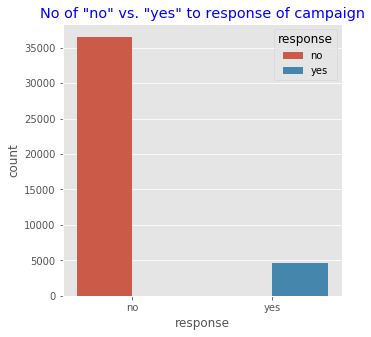

In [14]:
plt.figure(figsize=(5,5))
plt.title('No of "no" vs. "yes" to response of campaign',color='blue');
sns.countplot(x='response',data=marketing_df,hue='response');

### Observations from above plot
- The data is highly imbalanced with only 11.2% of reponse variable with values as yes
- We will have to handle this during data preparation/modeling

## Function to plot frequency and percentage wrt feature

In [15]:
def plot_frequency_and_percentage(feature,leads_df,category_df,another_row=False,height=8,ylabels=[]):
    
    if another_row:
        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,height*2))
    else:
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,6))
    fig.subplots_adjust(hspace=0.3)
    fig.subplots_adjust(wspace=0.3)
    
    ## plot the frequency plot for each category in the required column
    ax1.set_title('Frequency Plot of {0}'.format(feature),color='blue')
    ax1.set_ylabel(feature) 
    ax1.set_xlabel('count')
    sns.countplot(y=feature,data=category_df,
                  order=category_df[feature].value_counts().index,ax=ax1,color='green');
    if len(ylabels)>0:
        ax1.set_yticklabels(ylabels);
    
    ## plot the value percentage in each sub-category wrt the label
    ax2.set_title('Interested Customer percentage',color='blue')
    ax2.set_ylabel(feature) 
    ax2.set_xlabel('percentage')
    leads_df.iloc[1].sort_values().plot(kind='barh',ax=ax2,color='orange');
    if len(ylabels)>0:
        ax2.set_yticklabels(ylabels)



## Lets check the Customer Information

## 1. Lets check for column education

In [16]:
marketing_df['education'].value_counts()

university.degree      12160
high.school             9509
basic.9y                6045
professional.course     5237
basic.4y                4176
basic.6y                2290
unknown                 1729
illiterate                18
Name: education, dtype: int64

### Observations from above cell
- There are many category values for education. As per the normal, there can be categories as - Primary eductaion, Secondary education, Tertiary education, Professional education. We will map existing categories to these new categories
- Also there are very less values for category type 'illiterate'. We combine this category with Primary education category to simplify the categries
- Maximum values for eductaion is for category 'university.degree'

In [17]:
{ 'basic.9y' : 'Primary_Education', 'basic.4y' : 'Primary_Education',
 'basic.6y' : 'Primary_Education','illiterate' : 'Primary_Education',
 'high.school' : 'Secondary_Education', 'university.degree' : 'Tertiary_Education' }

{'basic.9y': 'Primary_Education',
 'basic.4y': 'Primary_Education',
 'basic.6y': 'Primary_Education',
 'illiterate': 'Primary_Education',
 'high.school': 'Secondary_Education',
 'university.degree': 'Tertiary_Education'}

In [18]:
marketing_df['education'] = marketing_df['education'].replace({'illiterate':'primary',
                                                                 'basic.4y':'primary',
                                                                 'basic.6y':'primary',
                                                                 'basic.9y':'primary',
                                                                 'high.school':'secondary',
                                                                 'university.degree':'tertiary',
                                                                 'professional.course':'professional'})
marketing_df['education'].value_counts()

primary         12529
tertiary        12160
secondary        9509
professional     5237
unknown          1729
Name: education, dtype: int64

In [19]:
crosstab_df = pd.crosstab(marketing_df['response'],
            marketing_df['education']).apply(lambda x: round((x/x.sum())*100,2), axis=0)
crosstab_df

education,primary,professional,secondary,tertiary,unknown
response,,,,,
no,91.28,88.64,89.16,86.28,85.48
yes,8.72,11.36,10.84,13.72,14.52


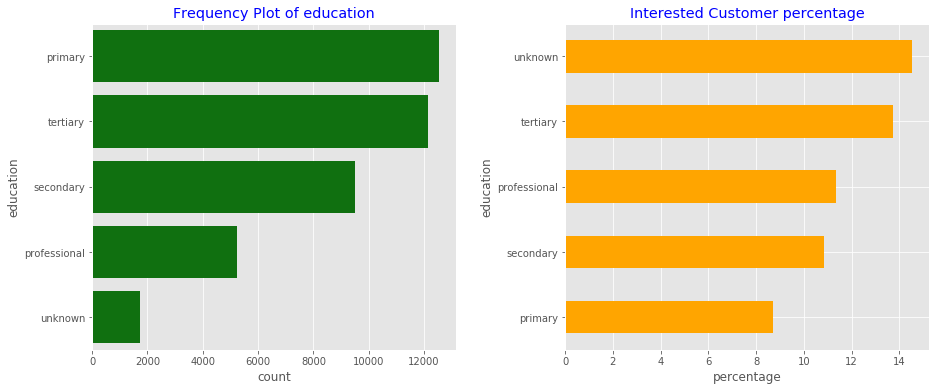

In [20]:
plot_frequency_and_percentage('education',crosstab_df,marketing_df.sort_values(
    by='education',ascending=False),False,6)

### Observation from above plot
- Primary education forms the largest part of group of people contacted for campaign while the response rate is lowest for people with Primary education. 
- Response rate is highest for people with Tertiary education. Perhaps they trust the bank more. This part of group has better relationship with the bank

## 2. Lets check for column default

In [21]:
marketing_df['default'].value_counts()

no         32566
unknown     8595
yes            3
Name: default, dtype: int64

In [22]:
crosstab_df = pd.crosstab(marketing_df['response'],
            marketing_df['default']).apply(lambda x: round((x/x.sum())*100,2), axis=0)
crosstab_df

default,no,unknown,yes
response,,,
no,87.12,94.85,100.0
yes,12.88,5.15,0.0


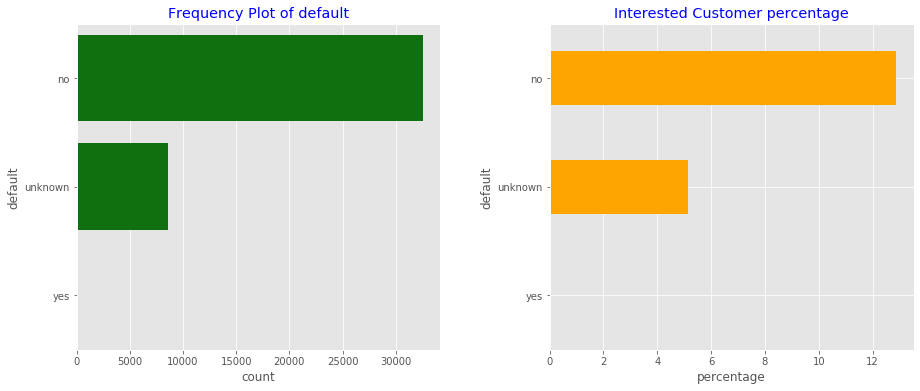

In [23]:
plot_frequency_and_percentage('default',crosstab_df,marketing_df.sort_values(
    by='default',ascending=False),False,6)

### Observation from above plot
- People with no previous default have been contacted more during the campaign
- Also people with no previous default have responded fairly well in comparison to people who previously defaulted

## 3. Lets check for column job

In [24]:
marketing_df['job'].value_counts()

admin.           10416
blue-collar       9252
technician        6735
services          3965
management        2924
retired           1716
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64

In [25]:
crosstab_df = pd.crosstab(marketing_df['response'],
            marketing_df['job']).apply(lambda x: round((x/x.sum())*100,2), axis=0)
crosstab_df

job,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,unknown
response,,,,,,,,,,,,
no,87.04,93.1,91.48,90.0,88.78,74.71,89.51,91.85,68.57,89.16,85.8,88.79
yes,12.96,6.9,8.52,10.0,11.22,25.29,10.49,8.15,31.43,10.84,14.2,11.21


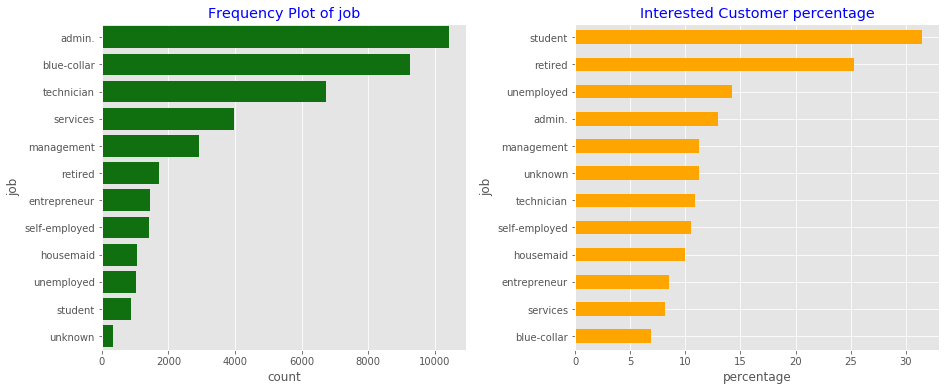

In [26]:
plot_frequency_and_percentage('job',crosstab_df,marketing_df.sort_values(
    by='job',ascending=False),False,6)

### Observation from above plot
- People with in profession of administration and blue-collar profile were contacted more during the campaign
- Students and retired people responded positive to the campaign while the blue-collar profiled people responded least to the campaign. This may be due to the reason that students and retired people seek more money for their education and retirement respectively

# Multivariate Analysis

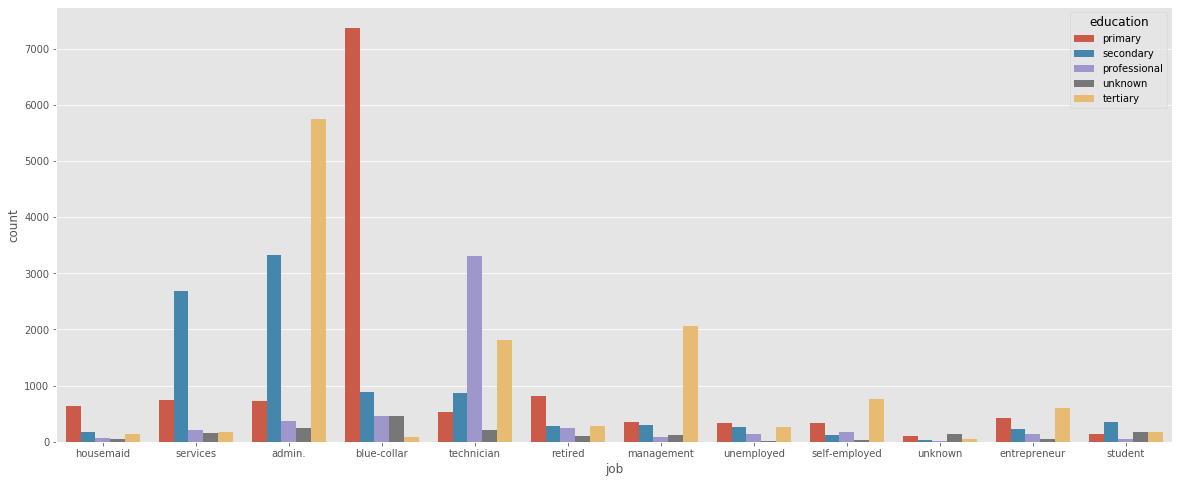

In [27]:
plt.figure(figsize=(20,8))
#plt.set_title('Response count based on education and job',color = 'blue',fontsize=14);
sns.countplot(x='job', data=marketing_df,hue='education'); 

### Observations from above plot
- Maximum People with Professional qualification are working as technician followed by blue-collared and administration services
- Maximum people with only Primary Qualification are working in blue-collared job. This explains well that people with less educational background tend to work as labour
- Most of the people with secondary background are working in admin and service related jobs
- People with tertiary background tend to be working in admin related profiles. Perhaps due to the high educational background they are working at good post in administration

## 3. Lets check for column age

In [28]:
marketing_df['age'].dtype

dtype('int64')

<b>Lets check the boxplot to see any outliers</b>

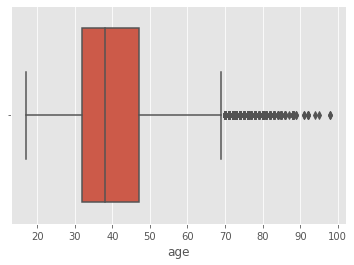

In [29]:
sns.boxplot(marketing_df['age']);

In [30]:
marketing_df['age'].quantile(0.99)

71.0

In [31]:
marketing_df[marketing_df['age']>71]['age'].count()

369

### Observations from above plot
- There seems to be many ouliers. Also we can see that there are some observations with age more than 90 as well
- The age at 99th percentile is 71, we will keep the upper bound of age as 71 assuming that the behavior pattern won't change much after that age. With this assumption we will replace all the values of age more than 71 with the value 70. There are total 369 such values

In [32]:
marketing_df['age'][marketing_df['age']>71] =71

In [33]:
marketing_df['age'].describe()

count    41164.000000
mean        39.954863
std         10.175596
min         17.000000
25%         32.000000
50%         38.000000
75%         47.000000
max         71.000000
Name: age, dtype: float64

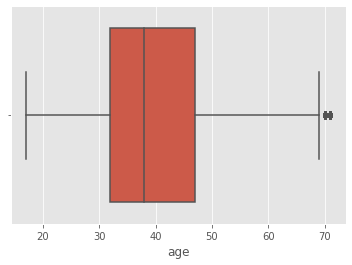

In [34]:
sns.boxplot(marketing_df['age']);

- Age is categorical column. We need to create various buckets of age group and need to bin the data

In [35]:
bins = np.arange(10,marketing_df['age'].max() + 10, 10)
marketing_df['age_bins'] = pd.cut(marketing_df['age'], bins, include_lowest=True).astype(str)

In [36]:
marketing_df['age_bins'].value_counts()

(30.0, 40.0]     16375
(40.0, 50.0]     10234
(20.0, 30.0]      7239
(50.0, 60.0]      6268
(60.0, 70.0]       488
(70.0, 80.0]       420
(9.999, 20.0]      140
Name: age_bins, dtype: int64

In [37]:
crosstab_df = pd.crosstab(marketing_df['response'],
            marketing_df['age_bins']).apply(lambda x: round((x/x.sum())*100,2), axis=0)
crosstab_df

age_bins,"(20.0, 30.0]","(30.0, 40.0]","(40.0, 50.0]","(50.0, 60.0]","(60.0, 70.0]","(70.0, 80.0]","(9.999, 20.0]"
response,,,,,,,
no,85.26,90.25,91.84,89.34,56.56,51.9,59.29
yes,14.74,9.75,8.16,10.66,43.44,48.1,40.71


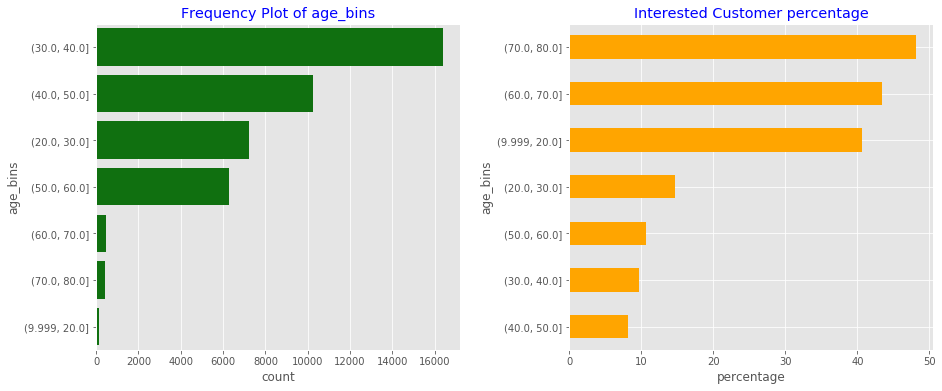

In [38]:
plot_frequency_and_percentage('age_bins',crosstab_df,marketing_df.sort_values(
    by='age_bins',ascending=False),False,6)

### Observation from above plot
- People in the age group of 30 to 50 were contacted more during the campaign followed by people in the age group of 20 to 30 and 50 to 60
- Senior citizens with age above 60 and people in the age group of 10 to 20 responded more to the campaign. This also aligns well with our earlier observation that student responded most to the campaign

## 5. Lets check for column marital

In [39]:
marketing_df['marital'].value_counts()

married     24914
single      11560
divorced     4610
unknown        80
Name: marital, dtype: int64

In [40]:
crosstab_df = pd.crosstab(marketing_df['response'],
            marketing_df['marital']).apply(lambda x: round((x/x.sum())*100,2), axis=0)
crosstab_df

marital,divorced,married,single,unknown
response,,,,
no,89.67,89.85,85.99,85.0
yes,10.33,10.15,14.01,15.0


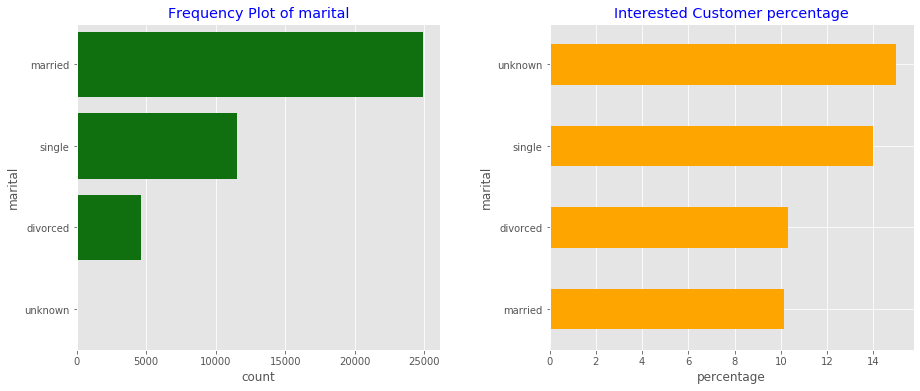

In [41]:
plot_frequency_and_percentage('marital',crosstab_df,marketing_df.sort_values(
    by='marital',ascending=False),False,6)

### Observation from above plot
- Married People were contacted most during the campaign followed by Singles
- Singles responded more to the campaign followed by divorced and married

## 5. Lets check for column housing

In [42]:
marketing_df['housing'].value_counts()

yes        21566
no         18608
unknown      990
Name: housing, dtype: int64

In [43]:
crosstab_df = pd.crosstab(marketing_df['response'],
            marketing_df['housing']).apply(lambda x: round((x/x.sum())*100,2), axis=0)
crosstab_df

housing,no,unknown,yes
response,,,
no,89.12,89.19,88.38
yes,10.88,10.81,11.62


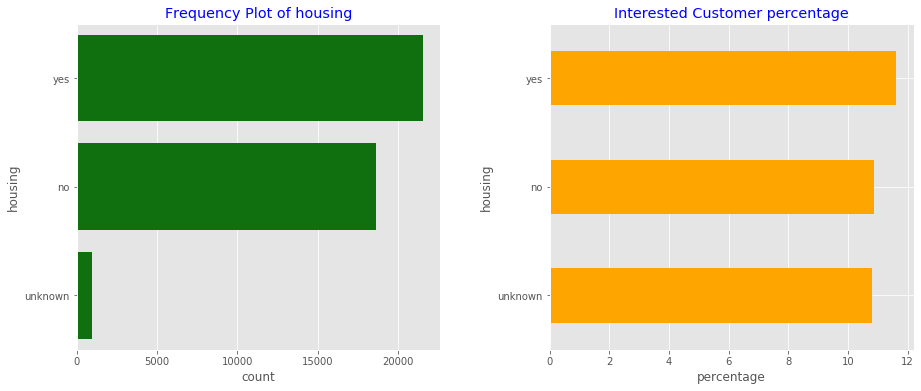

In [44]:
plot_frequency_and_percentage('housing',crosstab_df,marketing_df.sort_values(
    by='housing',ascending=False),False,6)

### Observation from above plot
- Group with People having existing housing loan were contacted more with a slight difference in number wrt people with no previous housing loan
- Both groups responded almost equally with only slight difference in response rate where group of people with already existing housing loan responded more to the campaign

## 6. Lets check for column loan

In [45]:
marketing_df['loan'].value_counts()

no         33926
yes         6248
unknown      990
Name: loan, dtype: int64

In [46]:
crosstab_df = pd.crosstab(marketing_df['response'],
            marketing_df['loan']).apply(lambda x: round((x/x.sum())*100,2), axis=0)
crosstab_df

loan,no,unknown,yes
response,,,
no,88.66,89.19,89.07
yes,11.34,10.81,10.93


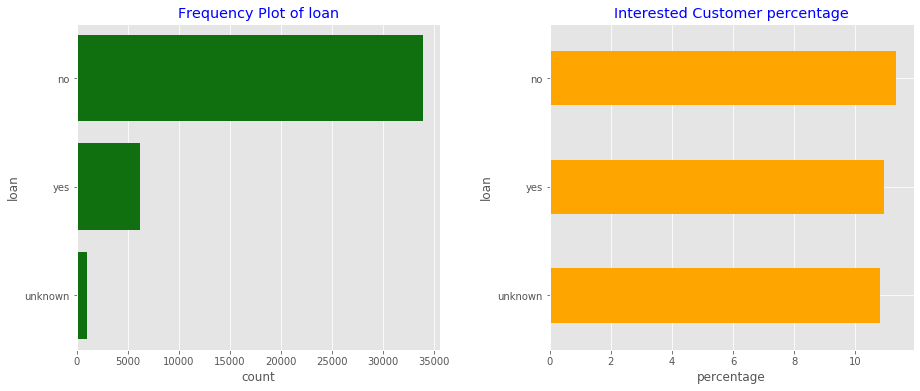

In [47]:
plot_frequency_and_percentage('loan',crosstab_df,marketing_df.sort_values(
    by='loan',ascending=False),False,6)

### Observation from above plot
- Group with People having existing personal loan were contacted more in comparison to the the ones already having personal loan
- Both groups responded almost equally with only slight difference in response rate where group of people with no existing personal loan responded more to the campaign

## Lets check the Contact Information
For that there are four columns in the data set

    Contact  |Contact communication type (categorical: 'cellular','telephone') 
    Month    |Last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
    Day      |Last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
    Duration |Last contact duration, in seconds (numeric). 

Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known   before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model

## 1. Lets check for column contact

In [48]:
marketing_df['contact'].value_counts()

cellular     26126
telephone    15038
Name: contact, dtype: int64

In [49]:
crosstab_df = pd.crosstab(marketing_df['response'],
            marketing_df['contact']).apply(lambda x: round((x/x.sum())*100,2), axis=0)
crosstab_df

contact,cellular,telephone
response,,
no,85.26,94.77
yes,14.74,5.23


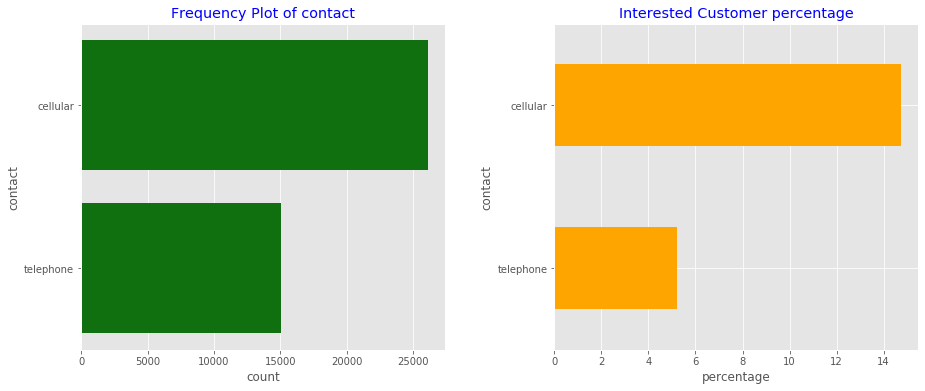

In [50]:
plot_frequency_and_percentage('contact',crosstab_df,marketing_df.sort_values(
    by='contact',ascending=False),False,6)

### Observation from above plot
- Most people were contacted through cellular medium in comparison to telephone
- People contacted through cellular medium responded more to the campaign

## 2. Lets check for column month

In [51]:
marketing_df['month'].value_counts()

may    13765
jul     7164
aug     6174
jun     5318
nov     4099
apr     2630
oct      716
sep      570
mar      546
dec      182
Name: month, dtype: int64

In [52]:
crosstab_df = pd.crosstab(marketing_df['response'],
            marketing_df['month']).apply(lambda x: round((x/x.sum())*100,2), axis=0)
crosstab_df

month,apr,aug,dec,jul,jun,mar,may,nov,oct,sep
response,,,,,,,,,,
no,79.51,89.39,51.1,90.97,89.49,49.45,93.56,89.85,56.01,55.09
yes,20.49,10.61,48.9,9.03,10.51,50.55,6.44,10.15,43.99,44.91


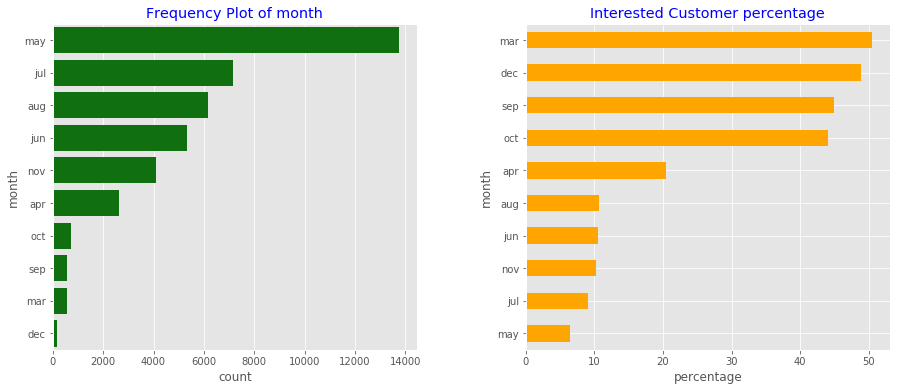

In [53]:
plot_frequency_and_percentage('month',crosstab_df,marketing_df.sort_values(
    by='month',ascending=False),False,6)

### Observation from above plot
- Most people were contacted during the month of may and july
- People responded most in the month of march and december followed by september and october. But these months have very less data points as well so there is no certainty of response when volume of cmapign contact increases in these months

## 3. Lets check for column day_of_week

In [54]:
marketing_df['day_of_week'].value_counts()

thu    8613
mon    8510
wed    8134
tue    8082
fri    7825
Name: day_of_week, dtype: int64

In [55]:
crosstab_df = pd.crosstab(marketing_df['response'],
            marketing_df['day_of_week']).apply(lambda x: round((x/x.sum())*100,2), axis=0)
crosstab_df

day_of_week,fri,mon,thu,tue,wed
response,,,,,
no,89.19,90.05,87.89,88.21,88.33
yes,10.81,9.95,12.11,11.79,11.67


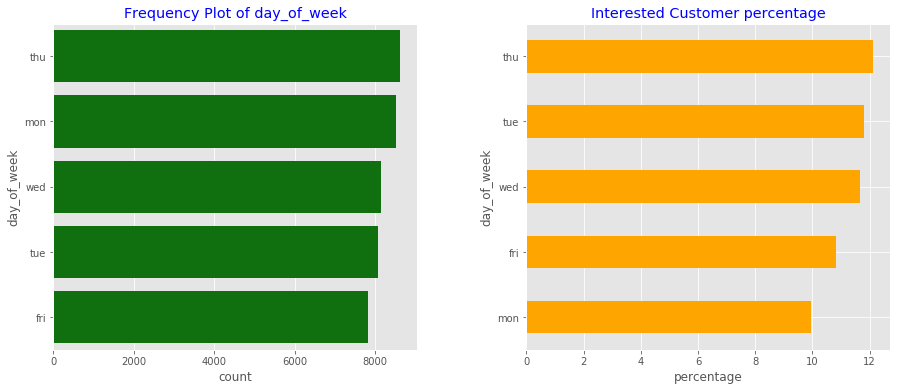

In [56]:
plot_frequency_and_percentage('day_of_week',crosstab_df,marketing_df.sort_values(
    by='day_of_week',ascending=False),False,6)

### Observation from above plot
- People were contacted almost on all days from Monday till Friday with very less difference in contact rate
- People contacted on thursday responded most followed by tuesday. While people contacted on monday responded least to the campaign. The difference in response rate is however is not much

## 4. Lets check for column duration

In [57]:
marketing_df['duration'].dtype

dtype('int64')

<b>Lets check the boxplot to see any outliers</b>

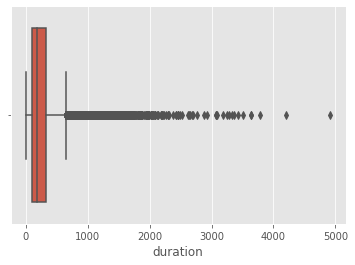

In [58]:
sns.boxplot(marketing_df['duration']);

In [59]:
marketing_df['duration'].quantile(0.99)

1271.3700000000026

In [60]:
marketing_df[marketing_df['duration']>1271]['duration'].count()

412

### Observations from above plot
- There seems to be many ouliers. Also we can see that there are some observations with duration of call more than 4000 seconds as well
- The duration at 99th percentile is 1271, we will cap the outliers at 1271. There are total 412 such values

In [61]:
marketing_df['duration'][marketing_df['duration']>1271] =1271

In [62]:
marketing_df['duration'].describe()

count    41164.000000
mean       254.408561
std        235.252862
min          0.000000
25%        102.000000
50%        180.000000
75%        319.000000
max       1271.000000
Name: duration, dtype: float64

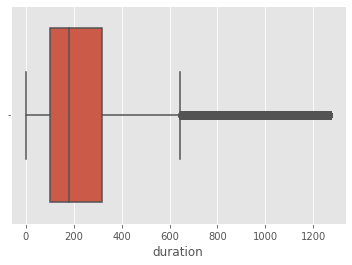

In [63]:
sns.boxplot(marketing_df['duration']);

## Lets now look at the other attributes of the campgain dataset

    Campaign   |Number of contacts performed during this campaign and for this client (numeric, includes last contact)
    Pdays      |Number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
    Previous   |Number of contacts performed before this campaign and for this client (numeric)
    Poutcome   |Outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

## 1. Lets check for column campagin

In [64]:
marketing_df['campaign'].value_counts()

1     17626
2     10566
3      5339
4      2649
5      1599
6       979
7       629
8       400
9       283
10      225
11      177
12      125
13       92
14       69
17       58
15       51
16       51
18       33
20       30
19       26
21       24
22       17
23       16
24       15
27       11
29       10
25        8
26        8
28        8
30        7
31        7
35        5
33        4
32        4
34        3
40        2
42        2
43        2
37        1
39        1
41        1
56        1
Name: campaign, dtype: int64

In [65]:
marketing_df['campaign'].dtype

dtype('int64')

<b>Lets check the boxplot to see any outliers</b>

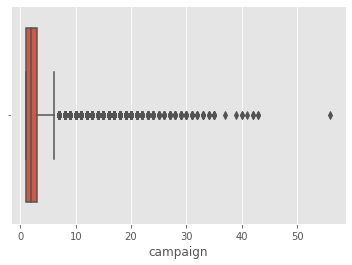

In [66]:
sns.boxplot(marketing_df['campaign']);

In [67]:
marketing_df['campaign'].quantile(0.99)

14.0

In [68]:
marketing_df[marketing_df['campaign']>14]['campaign'].count()

406

### Observations from above plot
- There seems to be many ouliers. Also we can see that there are some observations with campaign contacts per client of more than 30 as well
- The campaign at 99th percentile is 14, we will cap the outliers at 14. There are total 406 such values

In [69]:
marketing_df['campaign'][marketing_df['campaign']>14] =14

In [70]:
marketing_df['campaign'].describe()

count    41164.000000
mean         2.500559
std          2.301640
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         14.000000
Name: campaign, dtype: float64

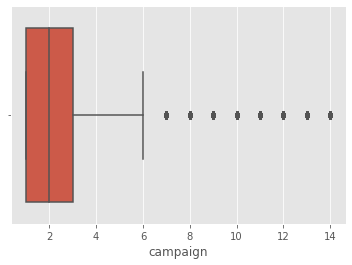

In [71]:
sns.boxplot(marketing_df['campaign']);

In [72]:
marketing_df['campaign'].value_counts()

1     17626
2     10566
3      5339
4      2649
5      1599
6       979
7       629
14      475
8       400
9       283
10      225
11      177
12      125
13       92
Name: campaign, dtype: int64

In [73]:
crosstab_df = pd.crosstab(marketing_df['response'],
            marketing_df['campaign']).apply(lambda x: round((x/x.sum())*100,2), axis=0)
crosstab_df

campaign,1,2,3,4,5,6,7,8,9,10,11,12,13,14
response,,,,,,,,,,,,,,
no,86.96,88.54,89.25,90.6,92.5,92.34,93.96,95.75,93.99,94.67,93.22,97.6,95.65,98.32
yes,13.04,11.46,10.75,9.4,7.5,7.66,6.04,4.25,6.01,5.33,6.78,2.4,4.35,1.68


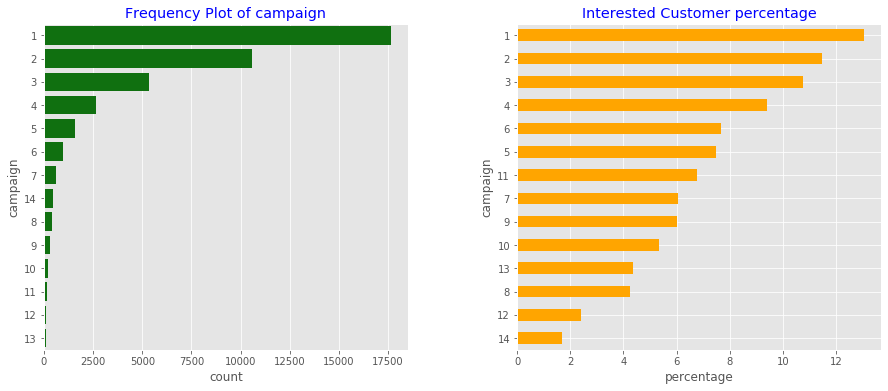

In [74]:
plot_frequency_and_percentage('campaign',crosstab_df,marketing_df.sort_values(
    by='campaign',ascending=False),False,6)

### Observation from above plot
- People were contacted mostly once followed by twice and thrice
- People contacted only once responded more followed by twice and thrice. We can see that people contacted most responded least to the campaign. Also we can see that as people are contacted more, they are less responding to the campaign

## 2. Lets check for column pdays

Number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

In [75]:
marketing_df['pdays'].value_counts()

999    39649
3        439
6        412
4        118
9         64
2         61
7         60
12        58
10        52
5         46
13        36
11        28
1         26
15        24
14        20
8         18
0         15
16        11
17         8
18         7
19         3
22         3
21         2
26         1
20         1
25         1
27         1
Name: pdays, dtype: int64

#### Lets divide the pdays into three buckets, 
    - contacted within the first ten days
    - contacted after first ten days 
    - first time contacted. 
- Note that the pdays value of 999 means client was bot previously contacted.

In [76]:
marketing_df['pdays'][marketing_df['pdays'].isin([0,1,2,3,4,5,6,7,8,9,10])]='pdays_contacted_first10days'

marketing_df['pdays'][marketing_df['pdays'].isin([999])]='pdays_cotacted_firsttime'

marketing_df['pdays'][~marketing_df['pdays'].isin(
    ['pdays_contacted_first10days','pdays_cotacted_firsttime'])]='pdays_contacted_after10days'

In [77]:
marketing_df['pdays'].value_counts()

pdays_cotacted_firsttime       39649
pdays_contacted_first10days     1311
pdays_contacted_after10days      204
Name: pdays, dtype: int64

In [78]:
crosstab_df = pd.crosstab(marketing_df['response'],
            marketing_df['pdays']).apply(lambda x: round((x/x.sum())*100,2), axis=0)
crosstab_df

pdays,pdays_contacted_after10days,pdays_contacted_first10days,pdays_cotacted_firsttime
response,,,
no,43.14,35.09,90.74
yes,56.86,64.91,9.26


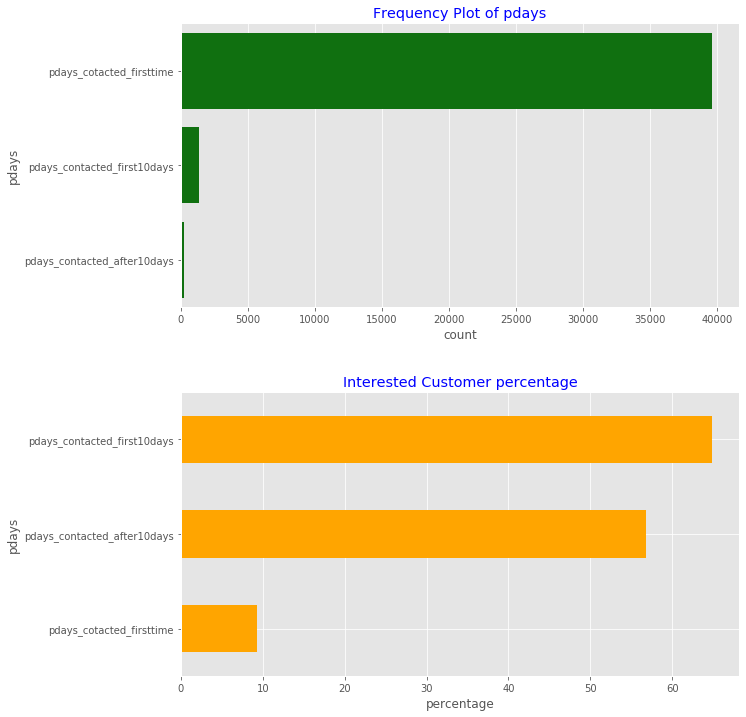

In [79]:
plot_frequency_and_percentage('pdays',crosstab_df,marketing_df.sort_values(
    by='pdays',ascending=False),True,6)

### Observation from above plot
- Most of the people were contacted for the first time in contact
- People who were again contacted within first 10 days responded most followed by people who were contacted again after 10 days

## 3. Lets check for column previous

 Number of contacts performed before this campaign and for this client (numeric)

In [80]:
marketing_df['previous'].value_counts()

0    35539
1     4561
2      754
3      216
4       70
5       18
6        5
7        1
Name: previous, dtype: int64

#### Lets divide the previous into three buckets, 
    - contacted never (i.e. 0 times) 
    - contacted less than or equal to 3 times 
    - contacted more than 3 times. 

In [81]:
marketing_df['previous'][marketing_df['previous'].isin([0])]='previous_contacted_never'

marketing_df['previous'][marketing_df['previous'].isin([1,2,3])]='previous_cotacted_lessthan3'

marketing_df['previous'][~marketing_df['previous'].isin(
    ['previous_contacted_never','previous_cotacted_lessthan3'])]='previous_contacted_morethan3'

In [82]:
marketing_df['previous'].value_counts()

previous_contacted_never        35539
previous_cotacted_lessthan3      5531
previous_contacted_morethan3       94
Name: previous, dtype: int64

In [83]:
crosstab_df = pd.crosstab(marketing_df['response'],
            marketing_df['previous']).apply(lambda x: round((x/x.sum())*100,2), axis=0)
crosstab_df

previous,previous_contacted_morethan3,previous_contacted_never,previous_cotacted_lessthan3
response,,,
no,42.55,91.17,73.87
yes,57.45,8.83,26.13


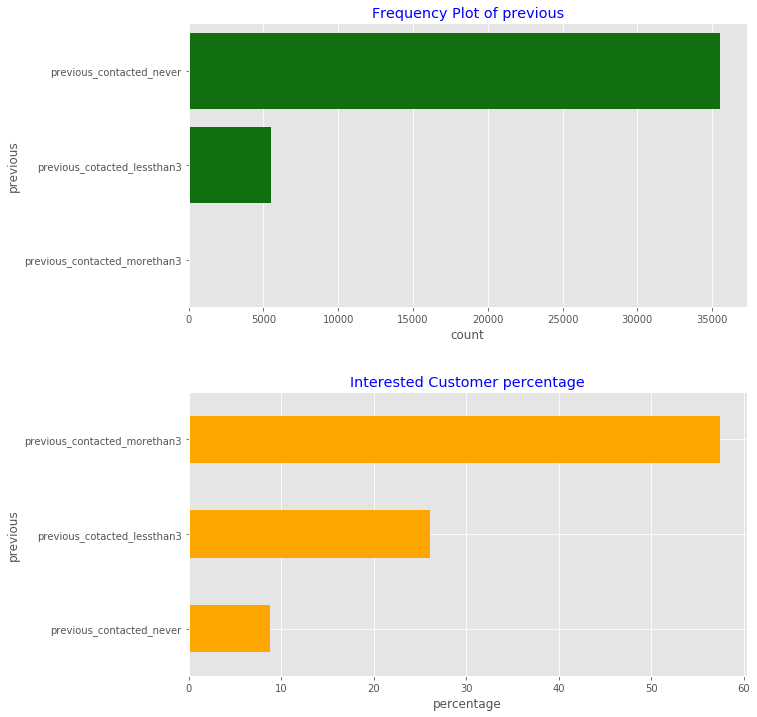

In [84]:
plot_frequency_and_percentage('previous',crosstab_df,marketing_df.sort_values(
    by='previous',ascending=False),True,6)

### Observation from above plot
- Most of the people were never contacted before this campaign
- People who were contacted more than 3 times before, responded most followed by people who were contacted less than 3 times
- Also we can see that the data entry points are very less for people who were contacted more than 3 times before. So its very difficult to draw inferences from this variable

## 4. Lets check for column poutcome

 Outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

In [85]:
marketing_df['poutcome'].value_counts()

nonexistent    35539
failure         4252
success         1373
Name: poutcome, dtype: int64

In [86]:
crosstab_df = pd.crosstab(marketing_df['response'],
            marketing_df['poutcome']).apply(lambda x: round((x/x.sum())*100,2), axis=0)
crosstab_df

poutcome,failure,nonexistent,success
response,,,
no,85.77,91.17,34.89
yes,14.23,8.83,65.11


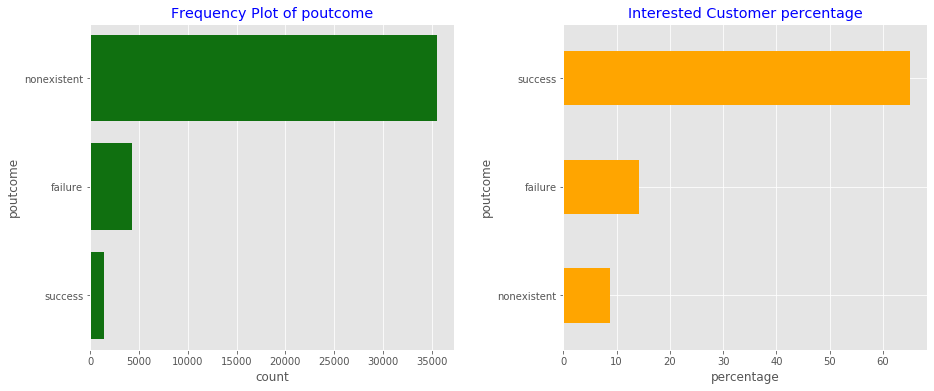

In [87]:
plot_frequency_and_percentage('poutcome',crosstab_df,marketing_df.sort_values(
    by='poutcome',ascending=False),False,6)

### Observation from above plot
- Most of the people who form part of the campaign had nonexistent outcome of the previous marketing campaign
- While the people with success outcome from previous outcome responded more to the campaign

## Lets now look at the Socio and Economic Contaxt attributes of the campgain dataset

    emp.var.rate    |Employment variation rate - quarterly indicator (numeric)
    cons.price.idx  |Consumer price index - monthly indicator (numeric) 
    cons.conf.idx   |Consumer confidence index - monthly indicator (numeric) 
    Euribor3m       |Euribor 3 month rate - daily indicator (numeric)
    nr.employed     |Number of employees - quarterly indicator (numeric)

## 1. Lets check for column emp.var.rate

In [88]:
marketing_df['emp.var.rate'].value_counts()

 1.4    16222
-1.8     9180
 1.1     7761
-0.1     3681
-2.9     1661
-3.4     1069
-1.7      773
-1.1      635
-3.0      172
-0.2       10
Name: emp.var.rate, dtype: int64

<b>Lets check the boxplot to see any outliers</b>

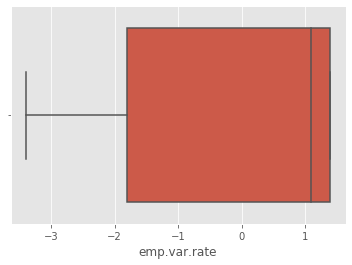

In [89]:
sns.boxplot(marketing_df['emp.var.rate']);

In [90]:
marketing_df['emp.var.rate'].describe(percentiles = [0.25,0.50,0.75,0.95,0.99])

count    41164.000000
mean         0.081958
std          1.570805
min         -3.400000
25%         -1.800000
50%          1.100000
75%          1.400000
95%          1.400000
99%          1.400000
max          1.400000
Name: emp.var.rate, dtype: float64

In [91]:
crosstab_df = pd.crosstab(marketing_df['response'],
            marketing_df['emp.var.rate']).apply(lambda x: round((x/x.sum())*100,2), axis=0)
crosstab_df

emp.var.rate,-3.4,-3.0,-2.9,-1.8,-1.7,-1.1,-0.2,-0.1,1.1,1.4
response,,,,,,,,,,
no,57.53,48.84,64.36,84.08,47.87,52.6,90.0,93.7,96.91,94.66
yes,42.47,51.16,35.64,15.92,52.13,47.4,10.0,6.3,3.09,5.34


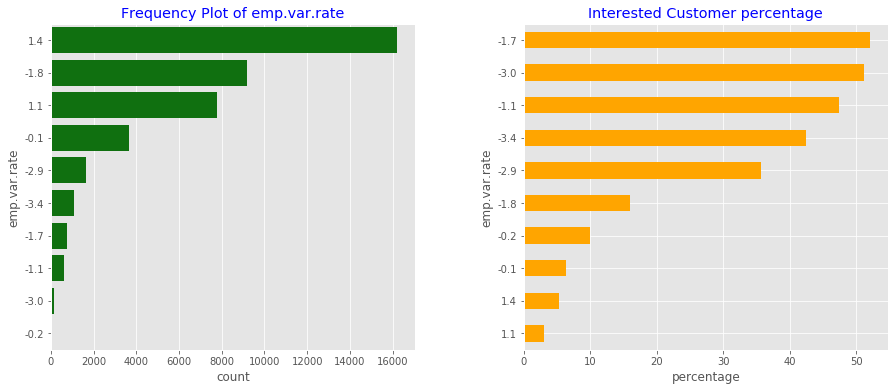

In [92]:
plot_frequency_and_percentage('emp.var.rate',crosstab_df,marketing_df.sort_values(
    by='emp.var.rate',ascending=False),False,6)

### Observation from above plot
- People contacted most are the ones with positive employment variation rate
- People with negative employment variation rate are the ones who responded most to the campaign

## 2. Lets check for column cons.price.idx

In [93]:
marketing_df['cons.price.idx'].value_counts()

93.994    7761
93.918    6677
92.893    5792
93.444    5171
94.465    4374
93.200    3614
93.075    2456
92.201     770
92.963     715
92.431     445
92.649     357
94.215     311
94.199     303
92.843     282
92.379     267
93.369     264
94.027     233
94.055     229
93.876     212
94.601     204
92.469     176
93.749     174
92.713     172
94.767     128
93.798      67
92.756      10
Name: cons.price.idx, dtype: int64

<b>Lets check the boxplot to see any outliers</b>

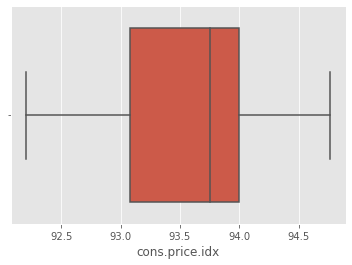

In [94]:
sns.boxplot(marketing_df['cons.price.idx']);

In [95]:
marketing_df['cons.price.idx'].describe(percentiles = [0.25,0.50,0.75,0.95,0.99])

count    41164.000000
mean        93.575775
std          0.578838
min         92.201000
25%         93.075000
50%         93.749000
75%         93.994000
95%         94.465000
99%         94.465000
max         94.767000
Name: cons.price.idx, dtype: float64

In [96]:
crosstab_df = pd.crosstab(marketing_df['response'],
            marketing_df['cons.price.idx']).apply(lambda x: round((x/x.sum())*100,2), axis=0)
crosstab_df

cons.price.idx,92.20100000000001,92.37899999999999,92.431,92.469,92.649,92.713,92.756,92.84299999999999,92.89299999999999,92.963,93.075,93.2,93.369,93.444,93.749,93.79799999999999,93.876,93.91799999999999,93.994,94.027,94.055,94.199,94.215,94.465,94.601,94.76700000000001
response,,,,,,,,,,,,,,,,,,,,,,,,,,
no,65.71,60.3,59.55,63.64,52.94,48.84,90.0,55.32,90.95,63.08,82.0,94.74,43.18,94.76,44.25,37.31,42.45,93.9,96.91,48.5,53.28,50.5,43.41,95.7,54.41,54.69
yes,34.29,39.7,40.45,36.36,47.06,51.16,10.0,44.68,9.05,36.92,18.0,5.26,56.82,5.24,55.75,62.69,57.55,6.1,3.09,51.5,46.72,49.5,56.59,4.3,45.59,45.31


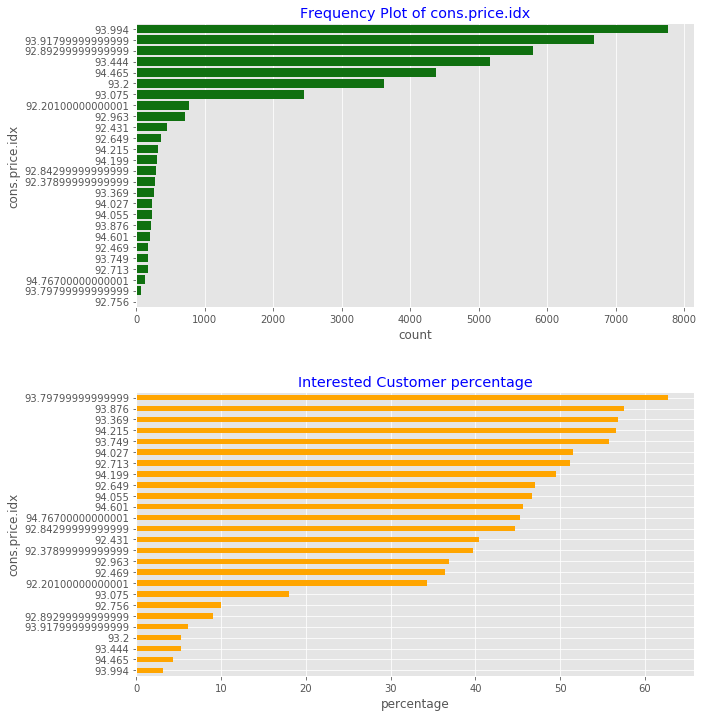

In [97]:
plot_frequency_and_percentage('cons.price.idx',crosstab_df,marketing_df.sort_values(
    by='cons.price.idx',ascending=False),True,6)

## 3. Lets check for column cons.conf.idx

In [98]:
marketing_df['cons.conf.idx'].value_counts()

-36.4    7761
-42.7    6677
-46.2    5792
-36.1    5171
-41.8    4374
-42.0    3614
-47.1    2456
-31.4     770
-40.8     715
-26.9     445
-30.1     357
-40.3     311
-37.5     303
-50.0     282
-29.8     267
-34.8     264
-38.3     233
-39.8     229
-40.0     212
-49.5     204
-33.6     176
-34.6     174
-33.0     172
-50.8     128
-40.4      67
-45.9      10
Name: cons.conf.idx, dtype: int64

<b>Lets check the boxplot to see any outliers</b>

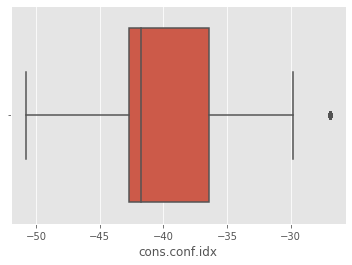

In [99]:
sns.boxplot(marketing_df['cons.conf.idx']);

In [100]:
marketing_df['cons.conf.idx'].describe(percentiles = [0.25,0.50,0.75,0.95,0.99])

count    41164.000000
mean       -40.503127
std          4.627522
min        -50.800000
25%        -42.700000
50%        -41.800000
75%        -36.400000
95%        -33.600000
99%        -26.900000
max        -26.900000
Name: cons.conf.idx, dtype: float64

In [101]:
crosstab_df = pd.crosstab(marketing_df['response'],
            marketing_df['cons.conf.idx']).apply(lambda x: round((x/x.sum())*100,2), axis=0)
crosstab_df

cons.conf.idx,-50.8,-50.0,-49.5,-47.1,-46.2,-45.9,-42.7,-42.0,-41.8,-40.8,-40.4,-40.3,-40.0,-39.8,-38.3,-37.5,-36.4,-36.1,-34.8,-34.6,-33.6,-33.0,-31.4,-30.1,-29.8,-26.9
response,,,,,,,,,,,,,,,,,,,,,,,,,,
no,54.69,55.32,54.41,82.0,90.95,90.0,93.9,94.74,95.7,63.08,37.31,43.41,42.45,53.28,48.5,50.5,96.91,94.76,43.18,44.25,63.64,48.84,65.71,52.94,60.3,59.55
yes,45.31,44.68,45.59,18.0,9.05,10.0,6.1,5.26,4.3,36.92,62.69,56.59,57.55,46.72,51.5,49.5,3.09,5.24,56.82,55.75,36.36,51.16,34.29,47.06,39.7,40.45


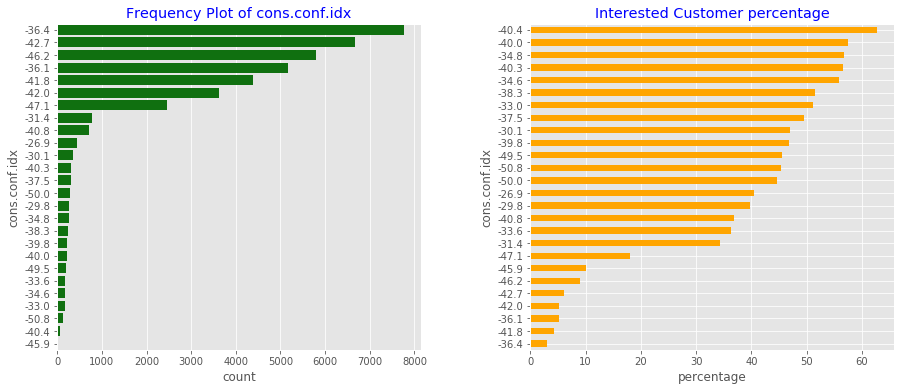

In [102]:
plot_frequency_and_percentage('cons.conf.idx',crosstab_df,marketing_df.sort_values(
    by='cons.conf.idx',ascending=False),False,6)

## 4. Lets check for column euribor3m

In [103]:
marketing_df['euribor3m'].value_counts()

4.857    2868
4.962    2609
4.963    2487
4.961    1902
4.856    1210
4.964    1175
1.405    1169
4.965    1069
4.864    1044
4.960    1013
4.968     990
4.959     895
4.860     892
4.855     838
4.076     822
1.266     820
4.859     788
4.120     756
4.858     733
4.153     688
4.021     676
4.967     643
1.281     637
4.966     618
4.191     610
1.250     587
4.958     581
1.291     544
1.327     538
4.957     537
1.299     520
1.313     490
1.334     482
1.244     422
1.344     395
4.865     373
4.866     340
1.365     303
1.410     254
1.260     252
1.354     215
0.879     180
4.970     172
1.262     145
0.714     139
0.715     135
0.884     128
0.883     124
1.270     110
4.955     103
1.445     103
4.947      98
1.415      98
1.268      95
1.264      87
1.423      85
0.873      82
0.739      82
1.453      81
1.435      81
0.881      79
0.720      78
0.722      74
1.259      70
0.742      66
0.861      65
1.479      62
0.904      60
1.466      57
0.869      54
0.716      54
0.899 

<b>Lets check the boxplot to see any outliers</b>

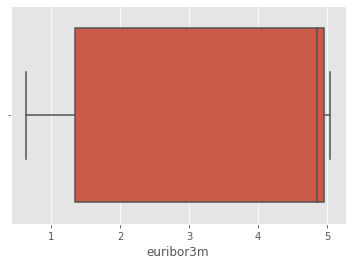

In [104]:
sns.boxplot(marketing_df['euribor3m']);

In [105]:
marketing_df['euribor3m'].describe(percentiles = [0.25,0.50,0.75,0.95,0.99])

count    41164.000000
mean         3.621296
std          1.734427
min          0.634000
25%          1.344000
50%          4.857000
75%          4.961000
95%          4.966000
99%          4.968000
max          5.045000
Name: euribor3m, dtype: float64

## 5. Lets check for column nr.employed

In [106]:
marketing_df['nr.employed'].value_counts()

5228.1    16222
5099.1     8530
5191.0     7761
5195.8     3681
5076.2     1661
5017.5     1069
4991.6      773
5008.7      650
4963.6      635
5023.5      172
5176.3       10
Name: nr.employed, dtype: int64

<b>Lets check the boxplot to see any outliers</b>

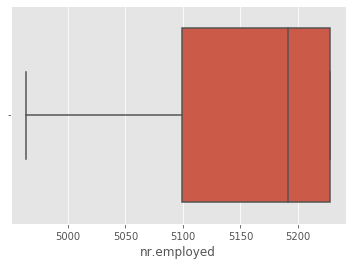

In [107]:
sns.boxplot(marketing_df['nr.employed']);

In [108]:
marketing_df['nr.employed'].describe(percentiles = [0.25,0.50,0.75,0.95,0.99])

count    41164.000000
mean      5167.033828
std         72.251200
min       4963.600000
25%       5099.100000
50%       5191.000000
75%       5228.100000
95%       5228.100000
99%       5228.100000
max       5228.100000
Name: nr.employed, dtype: float64

In [109]:
crosstab_df = pd.crosstab(marketing_df['response'],
            marketing_df['nr.employed']).apply(lambda x: round((x/x.sum())*100,2), axis=0)
crosstab_df

nr.employed,4963.6,4991.6,5008.7,5017.5,5023.5,5076.2,5099.1,5176.3,5191.0,5195.8,5228.1
response,,,,,,,,,,,
no,52.6,47.87,43.23,57.53,48.84,64.36,87.2,90.0,96.91,93.7,94.66
yes,47.4,52.13,56.77,42.47,51.16,35.64,12.8,10.0,3.09,6.3,5.34


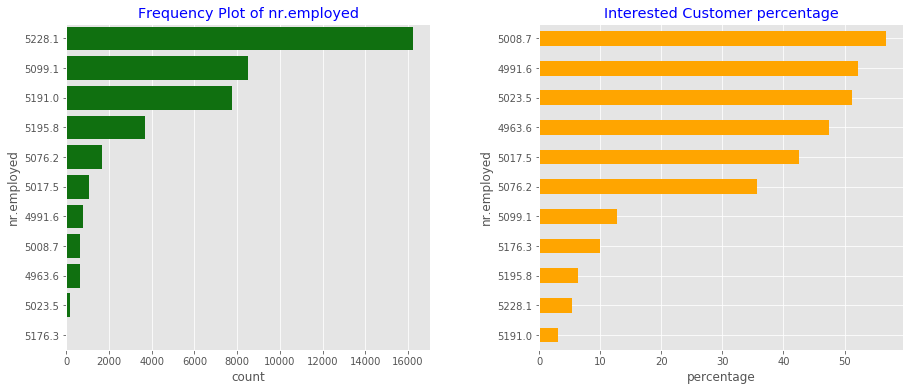

In [110]:
plot_frequency_and_percentage('nr.employed',crosstab_df,marketing_df.sort_values(
    by='nr.employed',ascending=False),False,6)

# Data Preparation

In [111]:
marketing_df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'response', 'age_bins'],
      dtype='object')

In [112]:
marketing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41164 entries, 0 to 41163
Data columns (total 22 columns):
age               41164 non-null int64
job               41164 non-null object
marital           41164 non-null object
education         41164 non-null object
default           41164 non-null object
housing           41164 non-null object
loan              41164 non-null object
contact           41164 non-null object
month             41164 non-null object
day_of_week       41164 non-null object
duration          41164 non-null int64
campaign          41164 non-null int64
pdays             41164 non-null object
previous          41164 non-null object
poutcome          41164 non-null object
emp.var.rate      41164 non-null float64
cons.price.idx    41164 non-null float64
cons.conf.idx     41164 non-null float64
euribor3m         41164 non-null float64
nr.employed       41164 non-null float64
response          41164 non-null object
age_bins          41164 non-null object
dtypes: f

## Lets convert target column 'response' into numerical column with values mapped as
- yes = 1
- no = 0

In [113]:
marketing_df['response'].value_counts()

no     36526
yes     4638
Name: response, dtype: int64

In [114]:
marketing_df['response'].replace({'yes':1,'no':0},inplace=True)
marketing_df['response'].value_counts()

0    36526
1     4638
Name: response, dtype: int64

## Since age is categorical column and we have created age buckets, so lets drop the redundant column age

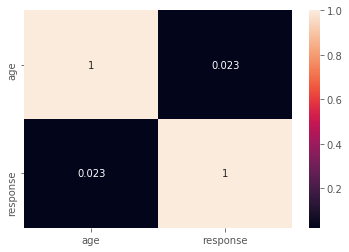

In [115]:
sns.heatmap(marketing_df[['age','response']].corr(),annot=True)

There is a very less correlation between age and response variable

In [116]:
marketing_df.drop(columns=['age'],inplace=True)
marketing_df.columns

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous',
       'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed', 'response', 'age_bins'],
      dtype='object')

In [117]:
marketing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41164 entries, 0 to 41163
Data columns (total 21 columns):
job               41164 non-null object
marital           41164 non-null object
education         41164 non-null object
default           41164 non-null object
housing           41164 non-null object
loan              41164 non-null object
contact           41164 non-null object
month             41164 non-null object
day_of_week       41164 non-null object
duration          41164 non-null int64
campaign          41164 non-null int64
pdays             41164 non-null object
previous          41164 non-null object
poutcome          41164 non-null object
emp.var.rate      41164 non-null float64
cons.price.idx    41164 non-null float64
cons.conf.idx     41164 non-null float64
euribor3m         41164 non-null float64
nr.employed       41164 non-null float64
response          41164 non-null int64
age_bins          41164 non-null object
dtypes: float64(5), int64(3), object(13)
memory u

## Lets make list of categorical columns

In [118]:
categorical_columns = list(marketing_df.select_dtypes(include=['object']))
numerical_columns = list(marketing_df.select_dtypes(exclude=['object']))
print('Catgeorical Columns list: \n{0}'.format(categorical_columns))
print('\nNumerical Columns list: \n{0}'.format(numerical_columns))

Catgeorical Columns list: 
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'pdays', 'previous', 'poutcome', 'age_bins']

Numerical Columns list: 
['duration', 'campaign', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'response']


### Lets use LabelEncoder to convert categorical columns

In [119]:
## Lets create copy of original dataset
marketing_le_df = marketing_df.copy()

In [120]:
#Lets create Label Encoder variable
le = LabelEncoder()
for col in categorical_columns:
    marketing_le_df[col] = le.fit_transform(marketing_le_df[col])
marketing_le_df.sample(10)

,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,response,age_bins
18784,9,1,0,1,0,0,0,3,2,31,14,2,1,1,1.4,93.918,-42.7,4.968,5228.1,0,2
41052,1,0,1,0,2,0,0,7,1,742,1,2,1,1,-1.1,94.767,-50.8,1.050,4963.6,1,2
19744,0,1,3,0,0,2,0,1,0,96,2,2,1,1,1.4,93.444,-36.1,4.966,5228.1,0,1
38742,0,1,3,0,0,0,0,7,2,96,1,2,1,1,-3.4,92.649,-30.1,0.714,5017.5,0,1
7449,1,1,1,0,0,0,1,6,0,278,2,2,1,1,1.1,93.994,-36.4,4.864,5191.0,0,1
39924,10,2,3,0,0,0,0,4,0,249,2,2,1,1,-1.7,94.055,-39.8,0.748,4991.6,0,1
13016,7,1,2,0,0,0,0,3,3,171,1,2,1,1,1.4,93.918,-42.7,4.962,5228.1,0,0
36262,1,2,0,0,1,1,0,4,1,128,1,1,2,2,-2.9,92.963,-40.8,1.266,5076.2,0,0
9958,10,1,2,1,2,0,1,4,4,204,2,2,1,1,1.4,94.465,-41.8,4.959,5228.1,0,3
689,4,1,3,0,2,0,1,6,3,716,2,2,1,1,1.1,93.994,-36.4,4.857,5191.0,0,2


In [121]:
# marketing_df = pd.get_dummies(data=marketing_df,columns=categorical_columns,drop_first=True)

## Lets Create Heatmap

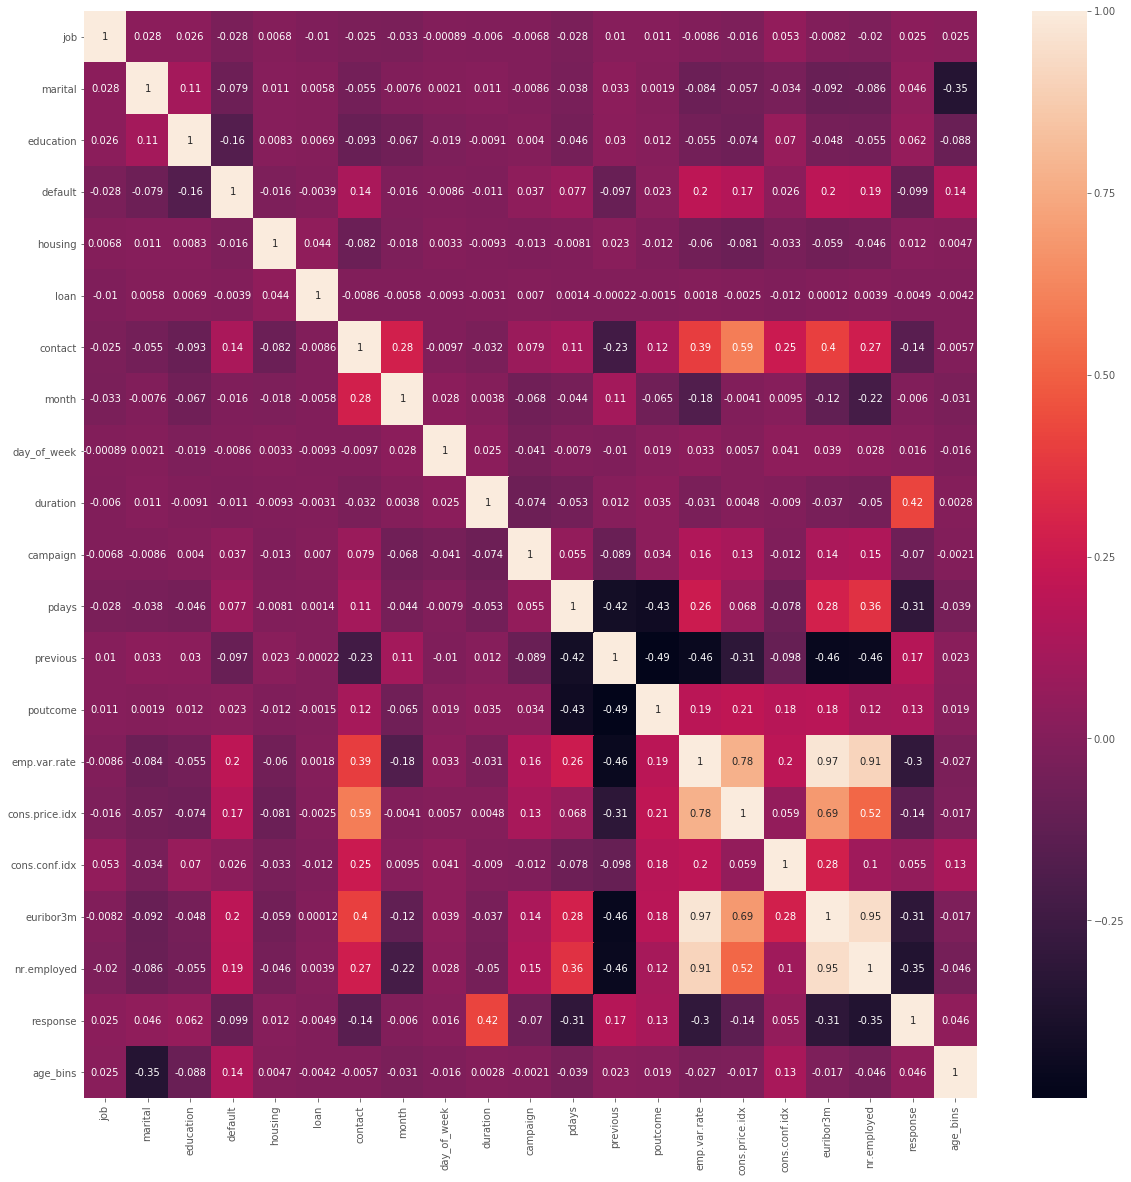

In [122]:
plt.figure(figsize=(20,20))
sns.heatmap(marketing_le_df.corr(),annot=True);
plt.savefig('./images/Heatmap.png')

In [123]:
marketing_le_corr = marketing_le_df.corr()
marketing_le_corr.style.apply(lambda x: ["background: yellow" if abs(v) > 0.5 else "" for v in x], axis = 1)

,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,response,age_bins
job,1,0.0277595,0.0255229,-0.0282873,0.00678448,-0.0101133,-0.0249751,-0.0327998,-0.000892209,-0.00595821,-0.00678822,-0.0275501,0.0102728,0.0114659,-0.00861478,-0.0162274,0.0528433,-0.00816853,-0.019881,0.0253743,0.0246171
marital,0.0277595,1,0.113704,-0.0794136,0.0105314,0.00582362,-0.0545538,-0.00761531,0.00214591,0.0107668,-0.00857996,-0.038226,0.0331532,0.00189838,-0.0840742,-0.0573849,-0.033858,-0.0918221,-0.0860682,0.046296,-0.346
education,0.0255229,0.113704,1,-0.164198,0.00828514,0.0068972,-0.0933977,-0.0674461,-0.0189309,-0.0091168,0.00401099,-0.0461128,0.0304756,0.0121045,-0.0548853,-0.0735469,0.0696262,-0.0479898,-0.0551451,0.0617876,-0.0883518
default,-0.0282873,-0.0794136,-0.164198,1,-0.0157645,-0.00386436,0.135313,-0.0157442,-0.00861855,-0.0114245,0.0369451,0.0772973,-0.0974006,0.0234562,0.203251,0.168078,0.0264827,0.195333,0.189846,-0.0993755,0.142298
housing,0.00678448,0.0105314,0.00828514,-0.0157645,1,0.0442483,-0.0820096,-0.0179601,0.00333992,-0.0093281,-0.0128084,-0.00810751,0.023088,-0.0117592,-0.0603002,-0.080654,-0.0334851,-0.0592895,-0.0459226,0.0116747,0.00474128
loan,-0.0101133,0.00582362,0.0068972,-0.00386436,0.0442483,1,-0.00862217,-0.00577168,-0.00934678,-0.00307863,0.00699203,0.00137784,-0.000218751,-0.0014603,0.00182953,-0.00251757,-0.0119791,0.000124144,0.00391765,-0.00493446,-0.00418105
contact,-0.0249751,-0.0545538,-0.0933977,0.135313,-0.0820096,-0.00862217,1,0.276432,-0.00965172,-0.0321599,0.0791216,0.11289,-0.233689,0.118802,0.393876,0.591719,0.251536,0.400011,0.269415,-0.144775,-0.00565375
month,-0.0327998,-0.00761531,-0.0674461,-0.0157442,-0.0179601,-0.00577168,0.276432,1,0.0276893,0.00381963,-0.0682628,-0.0444076,0.107003,-0.0650074,-0.178665,-0.00412724,0.00945058,-0.117168,-0.221316,-0.00603718,-0.0309655
day_of_week,-0.000892209,0.00214591,-0.0189309,-0.00861855,0.00333992,-0.00934678,-0.00965172,0.0276893,1,0.0254243,-0.0411616,-0.00786092,-0.0102234,0.0187349,0.0333303,0.0057052,0.0413448,0.0390852,0.0284473,0.0159726,-0.0155642
duration,-0.00595821,0.0107668,-0.0091168,-0.0114245,-0.0093281,-0.00307863,-0.0321599,0.00381963,0.0254243,1,-0.0743225,-0.0534558,0.0123382,0.0345095,-0.0313213,0.00484321,-0.00897619,-0.0374354,-0.0498828,0.421391,0.00282972


## Observation from above plot
- No variable seems to have a strong correlation with target variable response
- There seems to be a fair positive relationship between duration and response. Also there is a negative correlation between response and pdays variable. Also there seems to be negative and small relationship between response variables and emp.var.rate and cons.price.idx
- There seems to be positive relationship between con.price.idx and contact
- Also there seems to be very high positive relationship between 
    - euribor3m and emp.var.rate
    - nr.employed and emp.var.rate
    - nr.employed and euribor3m
    - euribor3m and cons.price.idx

We will have to further check the multicolinearity amongst the variable and variance inflation factor as well

## <font color=blue>Lets calculate Weight of evidence (WOE) and Information Value (IV) of all features</font>

## Function to create monotonic binning

In [124]:
import pandas.core.algorithms as algos
def create_monochromatic_bin(input_df,feature,target_var,feature_type,total_bins=10):
    # total_bins is the total number of bins
    # r is the spearman correlation coefficient between bin bucket variable and the target variable
    r=0
    # repeat this loop while r is less than 1
    if (feature_type == 'numeric'):
        while np.abs(r) < 1:
                try:
                    # Lets use qcut to bin into equal-sized buckets based on rank or based on sample quantiles
                    input_df['bin'] = pd.qcut(input_df[feature], total_bins).astype(str)

                    # Calculate a Spearman rank-order correlation coefficient and the p-value
                    # to test for non-correlation
                    # The Spearman correlation is a nonparametric measure of the monotonicity
                    # of the relationship between two datasets
                    r, p = stats.spearmanr(input_df.groupby('bin', as_index=True).mean()[feature], 
                                           input_df.groupby('bin', as_index=True).mean()[target_var])
                    total_bins = total_bins - 1 
                except Exception as e:
                    total_bins = total_bins - 1
        #If only one bin is formed then we will forcefully put 3 bins
        if len(input_df.groupby('bin', as_index=True)) == 1:
            total_bins = 3         
            bins = algos.quantile(input_df[feature], np.linspace(0, 1, total_bins))
            if len(np.unique(bins)) == 2:
                bins = np.insert(bins, 0, 1)
                bins[1] = bins[1]-(bins[1]/2)
            input_df['bin'] = pd.cut(input_df[feature], np.unique(bins),include_lowest=True) 
    else:
        input_df['bin'] = input_df[feature]
    
    #return dataframe with monochromatic bins
    return input_df

def calculate_woe_iv(input_df,feature,target_var,feature_type):
    
    # Lets group the input dataframe by bins and create another bucket dataframe
    if (feature_type == 'numeric'):
        bucket_df = input_df.groupby('bin', as_index=True)
    else:
        bucket_df = input_df.groupby(feature, as_index=True)
    
    # Lets create dataframe to weight of evidence (woe) and Information Value (IV) of variable
    output_df = pd.DataFrame(columns={'var_name',
                                     'min_val','max_val',
                                      'total_event_nonevent','event_count','nonevent_count',
                                     'event_pct','nonevent_pct',
                                     'woe','event_nonevent_pcnt_diff','iv'})

    #get the min value count in the bin
    if (feature_type == 'numeric'):
        output_df['min_val'] = bucket_df.min()[feature]
    #get the maximum value count in the bin
        output_df['max_val'] = bucket_df.max()[feature]
    else:
        output_df['min_val'] = bucket_df.sum()[target_var].index
        output_df['max_val'] = bucket_df.sum()[target_var].index
    
    #get the total number of events(target=1) and non-events(target=0)
    output_df['total_event_nonevent'] = bucket_df.count()[target_var].values
    #get total number of events(target=1)
    output_df['event_count'] = bucket_df.sum()[target_var].values
    #get total number of non-events(target=0)
    output_df['nonevent_count'] = bucket_df.count()[target_var].values - bucket_df.sum()[target_var].values
    
    # Adjustment for WOE
    output_df["event_count"] = output_df["event_count"].apply(lambda x : np.maximum(0.5,x))
    output_df["nonevent_count"] = output_df["nonevent_count"].apply(lambda x : np.maximum(0.5,x))
    
    #get event percentage
    output_df['event_pct'] = output_df["event_count"]/output_df.sum()["event_count"]
    #get non-event percentage
    output_df['nonevent_pct'] =  output_df["nonevent_count"]/output_df.sum()["nonevent_count"]
    #calculate weight of evidence
    output_df['woe'] = np.log(output_df['event_pct']/output_df['nonevent_pct'])
    output_df['event_nonevent_pcnt_diff'] = output_df['event_pct'] - output_df['nonevent_pct']
    #calculate information value
    output_df['iv'] = output_df['event_nonevent_pcnt_diff'] * output_df['woe']
    #output_df = output_df.reset_index(drop=True)
    #lets rearrange the columns in dataframe
    output_df = output_df[['var_name','min_val','max_val',
                       'total_event_nonevent','event_count','nonevent_count',
                       'event_pct','nonevent_pct',
                       'woe','event_nonevent_pcnt_diff','iv']]
    
    output_df = output_df.replace([np.inf, -np.inf], 0)
    
    output_df['var_name'] = feature
    output_df['iv'] = output_df['iv'].sum()
    
    output_df = output_df.reset_index(drop=True)
    #output_df

    # return the dataframe with woe and iv
    return output_df

## Lets calculate WOE and IV of all variables

In [125]:
col_list = list(marketing_df.columns)
col_list.remove('response')

result_df = pd.DataFrame(columns={'var_name',
                                     'min_val','max_val',
                                      'total_event_nonevent','event_count','nonevent_count',
                                     'event_pct','nonevent_pct',
                                     'woe','event_nonevent_pcnt_diff','iv'})

for col_name in col_list:
    if marketing_df[col_name].dtype == 'object':
        feature_type='string'
    else:
        feature_type='numeric'
    #create monochromatic binning using the function that we defined  
    bin_df = create_monochromatic_bin(marketing_df[[col_name,'response']],col_name,'response',feature_type,10)
    
    #calaculate woe and iv of each variable using the function that we defined
    woe_iv_df = calculate_woe_iv(bin_df,col_name,'response',feature_type)
    
    if(result_df['var_name'].count()==0):
        result_df = woe_iv_df
    else:
        result_df = result_df.append(woe_iv_df,ignore_index=True)

result_df.head(30)

,var_name,min_val,max_val,total_event_nonevent,event_count,nonevent_count,event_pct,nonevent_pct,woe,event_nonevent_pcnt_diff,iv
0,job,admin.,admin.,10416,1350.0,9066.0,0.291074,0.248207,0.159315,0.042867,0.188858
1,job,blue-collar,blue-collar,9252,638.0,8614.0,0.137559,0.235832,-0.539065,-0.098273,0.188858
2,job,entrepreneur,entrepreneur,1456,124.0,1332.0,0.026736,0.036467,-0.310414,-0.009732,0.188858
3,job,housemaid,housemaid,1060,106.0,954.0,0.022855,0.026118,-0.133483,-0.003264,0.188858
4,job,management,management,2924,328.0,2596.0,0.070720,0.071073,-0.004972,-0.000353,0.188858
5,job,retired,retired,1716,434.0,1282.0,0.093575,0.035098,0.980609,0.058477,0.188858
6,job,self-employed,self-employed,1421,149.0,1272.0,0.032126,0.034825,-0.080658,-0.002699,0.188858
7,job,services,services,3965,323.0,3642.0,0.069642,0.099710,-0.358895,-0.030068,0.188858
8,job,student,student,875,275.0,600.0,0.059293,0.016427,1.283583,0.042866,0.188858
9,job,technician,technician,6735,730.0,6005.0,0.157395,0.164403,-0.043562,-0.007008,0.188858


### Get IV of variables

In [126]:
iv_df = pd.DataFrame({'iv':result_df.groupby('var_name')['iv'].max()})
iv_df = iv_df.reset_index()
iv_df.sort_values(by='iv',ascending=False)

,var_name,iv
7,duration,1.834603
17,pdays,0.553008
18,poutcome,0.547882
15,month,0.485817
10,euribor3m,0.348202
16,nr.employed,0.342064
19,previous,0.286346
9,emp.var.rate,0.268841
4,contact,0.251611
0,age_bins,0.217035


## As per definition 

        IV           |         Predictive Power
        -----------------------------------------
        <0.02        |    Useless for Prediction
        0.02 to 0.1  |    Weak Predictor
        0.1 to 0.3   |    Medium Predictor
        0.3 to 0.5   |    Strong Predictor
        >0.5         |    Suspicious or too good to be true

### Observations from above cell
- Going by Information Value, feature <b><u>'duration'</u></b> seems to be too good to be true. Its <b><u>not a good predictor</u></b>
- poutcome, month, euribor3m, nr.employed seem to be <b><u>strong predictors</u></b>
- previous, emp.var.rate, contact, age_bins, job, default, cons.price.idx seem to be <b><u>medium predictors</u></b>

We will build various models and check for model evaluation metrics and feature importance

<b><font color=black size=8>Part - I</font></b>

<font color=blue size=6>Preparation for Model Building</font>

## Set X and y

In [127]:
X = marketing_le_df.drop('response',axis=1)
y = marketing_le_df['response']

print('shape of X: {0}'.format(X.shape))
print('shape of y: {0}'.format(y.shape))

shape of X: (41164, 20)
shape of y: (41164,)


Drop response column from numerical columns list as well

In [128]:
numerical_columns.remove('response')
numerical_columns

['duration',
 'campaign',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed']

In [129]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42,stratify=y)

print('shape of X_train: {0}'.format(X_train.shape))
print('shape of y_train: {0}'.format(y_train.shape))
print('shape of X_test: {0}'.format(X_test.shape))
print('shape of y_test: {0}'.format(y_test.shape))

shape of X_train: (28814, 20)
shape of y_train: (28814,)
shape of X_test: (12350, 20)
shape of y_test: (12350,)


# Data Modelling

## <b><font size=4 color=blue>Please note that since we have imbalanced target class where number of response is around 11%, we will use class weights to handle class imbalance. 

Also since its important for business to identify the people who responded mopre to the campaign, we should look for the metrics where false negative count is less. In other words we should look for <u><font color=red>sensitivity/recall</font></u> of a model as deciding factor of a model</font></b>

### Function to store results in results dataframe for comparison

In [130]:
#function to store results
def store_results(df,conf_matrix,model_name,location,set_type):
    TP = conf_matrix[1,1] # true positive 
    TN = conf_matrix[0,0] # true negatives
    FP = conf_matrix[0,1] # false positives
    FN = conf_matrix[1,0] # false negatives
    acc = accuracy_score(df['response'], df['predicted'])
    f1 = f1_score(df['response'],df['predicted'])
    sen = TP / (TP + FN)
    spec = TN / (TN + FP)
    prec = TP / (TP + FP)
    results_df.loc[location,'model_type']=model_name
    results_df.loc[location,set_type+'_acc'] = round(acc,2)
    results_df.loc[location,set_type+'_sen'] = round(sen,2)
    results_df.loc[location,set_type+'_spec'] = round(spec,2)
    results_df.loc[location,set_type+'_f1'] = round(f1,2)

### Function to plot ROC Curve

In [131]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return None

### Create Results Dataframe

In [132]:
results_df = pd.DataFrame(columns=['model_type','train_acc', 'train_sen', 'train_spec', 'train_f1', 
                      'test_acc', 'test_sen', 'test_spec', 'test_f1'])

## Model1 - Stats GLM Model using Binomial Families

### Function to build statsmodel

In [133]:
def build_statsmodel(X_df,y_df):
    #add constant. Its because intercept might not pass through origin
    #By default its not added in stats model
    #we have to add constant explicitly
    X_train_sm = sm.add_constant(X_df)
    stats_model = sm.GLM(y_df,X_train_sm, family = sm.families.Binomial()).fit()
    
    ## Print the params obtained
    print('************ feature - coefficients *****************')
    print(round(stats_model.params,4))
    print('*****************************************************')
    print()
    print()
    ## Print stats model summary
    print(stats_model.summary())
    return stats_model,X_train_sm

### Functions to check VIF

In [134]:
def check_vif(X_df):
    vif = pd.DataFrame()
    vif['Features'] = X_df.columns
    vif['VIF'] = [variance_inflation_factor(X_df.values,i) for i in range(X_df.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

### Function to check scores

In [135]:
def createfinaldf_and_checkscores(y_df,y_pred_df,y_pred_prob_df,prob_cutoff=0.5):
    y_pred_final_df = pd.DataFrame({'response':y_df.values, 'response_Prob':y_pred_prob_df})
    #y_pred_final_df = pd.DataFrame({'response':y_df.values, 'response_Prob':y_pred_df})
    
    ## Lets create a new column that will determine the record uniquely
    y_pred_final_df['responseId'] = y_df.index
    
    
    # Creating new column 'predicted' with 1 if Converted_Prob > 0.5 else 0
    ## this means cut-off set is 0.5
    y_pred_final_df['predicted'] = y_pred_final_df['response_Prob'].map(lambda x: 1 if x > prob_cutoff else 0)
    #print(y_train_pred_final.head())
    
    #Confusion matrix
    cm = confusion_matrix(y_pred_final_df['response'],y_pred_final_df['predicted'])
    #print(conf_matrix)
    
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax,fmt='d',annot_kws={"size": 14}); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['unsuccessfull', 'successfull']); ax.yaxis.set_ticklabels(['unsuccessfull', 'successfull']);
    plt.show();
    
    # Let's check the overall accuracy.
    print('Accuracy score: {0}'.format
          (accuracy_score(y_pred_final_df['response'],y_pred_final_df['predicted'])))
    # Let's check sensitivity
    TP = cm[1,1] # true positive 
    TN = cm[0,0] # true negatives
    FP = cm[0,1] # false positives
    FN = cm[1,0] # false negatives
    sensitivity = TP / float(TP+FN)
    print('Sensitivity score: {0}'.format(sensitivity))
    # Lets check Specificity
    specificity = TN / float(TN + FP)
    print('Specificity score: {0}'.format(specificity))
    # Lets check f1-score
    print('f1-score: {0}'.format
          (f1_score(y_pred_final_df['response'],y_pred_final_df['predicted'])))
    # Lets check precision score
    print('Precision score: {0}'.format
          (precision_score(y_pred_final_df['response'],y_pred_final_df['predicted'])))
    # Lets check Recall Score
    print('Recall score: {0}'.format
          (recall_score(y_pred_final_df['response'],y_pred_final_df['predicted'])))
    # Lets check Area Under the Curve
    print('AUC: {0}'.format
          (round(roc_auc_score(y_df,y_pred_prob_df),2)))
    
    return y_pred_final_df, cm

### Function to check probability cutoff

In [136]:
def  check_cutoff(df):
    # Let's create columns with different probability cutoffs 
    numbers = [float(x)/10 for x in range(10)]
    for i in numbers:
        df[i]= df['response_Prob'].map(lambda x: 1 if x > i else 0)
    
    # Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
    cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
    # TP = confusion[1,1] # true positive 
    # TN = confusion[0,0] # true negatives
    # FP = confusion[0,1] # false positives
    # FN = confusion[1,0] # false negatives

    num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    for i in num:
        cm1 = confusion_matrix(df['response'], df[i] )
        total1=sum(sum(cm1))
        accuracy = (cm1[0,0]+cm1[1,1])/total1

        speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
        sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
        cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
    return cutoff_df

### Scale X_train and X_test - only continuous numerical columns

<font color=green>We will use <u>ColumnTransformer</u>
This estimator allows different columns or column subsets of the input to be transformed separately and the features generated by each transformer will be concatenated to form a single feature space. This is useful for heterogeneous or columnar data, to combine several feature extraction mechanisms or transformations into a single transformer.

For more information click on link https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html</font>

In [137]:
# #Use Transformer to only use scalar on continuous variables
transformer = ColumnTransformer(transformers=[('std_scaler', StandardScaler(), numerical_columns)],
                                remainder='passthrough')
transformed_X_train_scaled = pd.DataFrame(transformer.fit_transform(X_train),columns=(numerical_columns+categorical_columns))
transformed_X_test_scaled = pd.DataFrame(transformer.transform(X_test),columns=(numerical_columns+categorical_columns))

In [138]:
transformed_X_train_scaled.head()

,duration,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job,marital,education,default,housing,loan,contact,month,day_of_week,pdays,previous,poutcome,age_bins
0,-0.271854,-0.649839,-1.196601,-1.177726,-1.231307,-1.346436,-0.935192,0.0,0.0,2.0,0.0,2.0,0.0,0.0,6.0,4.0,2.0,2.0,0.0,1.0
1,1.970350,-0.216613,0.839306,1.535133,-0.281512,0.772200,0.844567,6.0,1.0,1.0,0.0,2.0,2.0,1.0,4.0,0.0,2.0,1.0,1.0,1.0
2,-0.814254,-0.649839,0.839306,1.535133,-0.281512,0.776808,0.844567,9.0,1.0,1.0,0.0,0.0,2.0,1.0,4.0,0.0,2.0,1.0,1.0,2.0
3,-0.391439,-0.216613,0.839306,-0.226845,0.948903,0.775656,0.844567,0.0,1.0,3.0,0.0,0.0,0.0,0.0,1.0,4.0,2.0,1.0,1.0,0.0
4,0.279087,-0.216613,-1.896444,-1.909439,1.488558,-1.474315,-1.251134,9.0,1.0,1.0,0.0,0.0,0.0,1.0,3.0,0.0,2.0,1.0,1.0,2.0


In [139]:
transformed_X_test_scaled.head()

,duration,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job,marital,education,default,housing,loan,contact,month,day_of_week,pdays,previous,poutcome,age_bins
0,1.193053,0.216613,-1.196601,-0.863642,-1.425583,-1.275008,-0.935192,6.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,3.0
1,-1.040610,1.083065,0.839306,1.535133,-0.281512,0.772200,0.844567,1.0,1.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,2.0,1.0,1.0,3.0
2,-0.007061,-0.649839,-0.751246,1.769833,-1.943652,-1.518669,-2.804629,1.0,2.0,2.0,0.0,0.0,0.0,0.0,8.0,3.0,2.0,2.0,0.0,0.0
3,-0.058311,-0.649839,-1.196601,-1.177726,-1.231307,-1.364293,-0.935192,1.0,1.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,2.0,2.0,0.0,1.0
4,-0.002790,-0.216613,0.648440,0.722311,0.884144,0.713445,0.332714,0.0,1.0,3.0,0.0,2.0,0.0,1.0,6.0,3.0,2.0,1.0,1.0,2.0


## Model 1 - StatsModel 1

In [140]:
stats_model,X_train_sm = build_statsmodel(transformed_X_train_scaled,list(y_train))

************ feature - coefficients *****************
const            -3.1194
duration          1.1929
campaign         -0.0767
emp.var.rate     -1.5042
cons.price.idx    0.3734
cons.conf.idx     0.0733
euribor3m         1.3757
nr.employed      -1.1267
job               0.0095
marital           0.0911
education         0.0923
default          -0.3958
housing          -0.0098
loan             -0.0451
contact          -0.6849
month            -0.1194
day_of_week       0.0519
pdays            -0.3313
previous          0.2548
poutcome          0.7731
age_bins          0.0505
dtype: float64
*****************************************************


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                28814
Model:                            GLM   Df Residuals:                    28793
Model Family:                Binomial   Df Model:                           20
Link Function:                  lo

In [141]:
check_vif(X_train_sm)

,Features,VIF
0,const,683.45
6,euribor3m,96.29
3,emp.var.rate,43.61
7,nr.employed,42.81
4,cons.price.idx,9.66
18,previous,3.77
19,poutcome,3.68
17,pdays,3.60
5,cons.conf.idx,3.58
14,contact,2.30


### Observations from above cells
- As we earlier saw through heatmap and also now after checking variance inflation factor, there is high multicolinearity for variables euribor3m, emp.var.rate, nr.employed, cons.price.idx

### 2. StatsModel 2

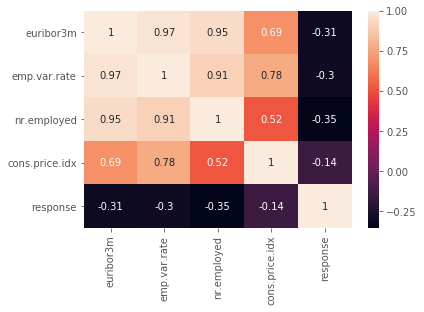

In [142]:
sns.heatmap(marketing_df[['euribor3m','emp.var.rate','nr.employed','cons.price.idx','response']].corr(),
            annot=True)

From above heatmap we can see that cons.price.idx has the lowest correlation with response variable while nr.employed has the highest correlation followed by euribor3m. euribor3m and emp.var.rate also have very high correlation. So we can try dropping emp.var.rate and rebuild the model

In [143]:
## Drop emp.var.rate
try:
    transformed_X_train_scaled.drop(columns=['emp.var.rate'],inplace=True)
except:
    print('column not found!')
stats_model,X_train_sm = build_statsmodel(transformed_X_train_scaled,list(y_train))

************ feature - coefficients *****************
const            -3.3605
duration          1.1894
campaign         -0.0980
cons.price.idx   -0.1417
cons.conf.idx     0.1000
euribor3m         0.4446
nr.employed      -1.3826
job               0.0084
marital           0.0954
education         0.0970
default          -0.4368
housing          -0.0137
loan             -0.0434
contact          -0.4872
month            -0.1049
day_of_week       0.0496
pdays            -0.2898
previous          0.2732
poutcome          0.7890
age_bins          0.0547
dtype: float64
*****************************************************


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                28814
Model:                            GLM   Df Residuals:                    28794
Model Family:                Binomial   Df Model:                           19
Link Function:                  logit   Scale:             

In [144]:
check_vif(X_train_sm)

,Features,VIF
0,const,679.83
5,euribor3m,62.85
6,nr.employed,42.75
3,cons.price.idx,7.54
17,previous,3.76
18,poutcome,3.67
16,pdays,3.60
4,cons.conf.idx,3.50
13,contact,2.19
14,month,1.62


### Observations from above cells
- As we earlier saw through heatmap and also now after checking variance inflation factor, there is high multicolinearity for variables euribor3m, nr.employed, cons.price.idx

### 3. StatsModel 3

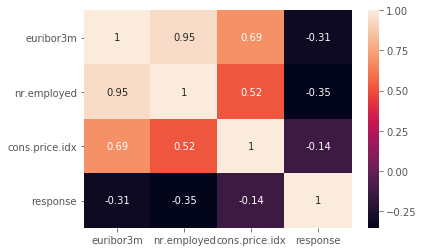

In [145]:
sns.heatmap(marketing_df[['euribor3m','nr.employed','cons.price.idx','response']].corr(),
            annot=True)

From above heatmap we can see that cons.price.idx has the lowest correlation with response variable while nr.employed has the highest correlation followed by euribor3m. euribor3m and emp.var.rate also have very high correlation. So we can try dropping euribor3m and rebuild the model

In [146]:
## Drop euribor3m
try:
    transformed_X_train_scaled.drop(columns=['euribor3m'],inplace=True)
except:
    print('column not found!')
stats_model,X_train_sm = build_statsmodel(transformed_X_train_scaled,list(y_train))

************ feature - coefficients *****************
const            -3.3892
duration          1.1878
campaign         -0.1005
cons.price.idx    0.0080
cons.conf.idx     0.1718
nr.employed      -1.0310
job               0.0088
marital           0.0926
education         0.0989
default          -0.4404
housing          -0.0118
loan             -0.0434
contact          -0.5265
month            -0.0922
day_of_week       0.0495
pdays            -0.2910
previous          0.2654
poutcome          0.7876
age_bins          0.0570
dtype: float64
*****************************************************


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                28814
Model:                            GLM   Df Residuals:                    28795
Model Family:                Binomial   Df Model:                           18
Link Function:                  logit   Scale:                          1.0000
Metho

In [147]:
check_vif(X_train_sm)

,Features,VIF
0,const,679.83
16,previous,3.75
17,poutcome,3.67
15,pdays,3.59
3,cons.price.idx,2.15
12,contact,1.96
5,nr.employed,1.90
13,month,1.24
18,age_bins,1.20
4,cons.conf.idx,1.18


### Observations from above cell
- Log Likelihood has minimized and also the VIF of all variables is below 4. We need not drop any more columns now

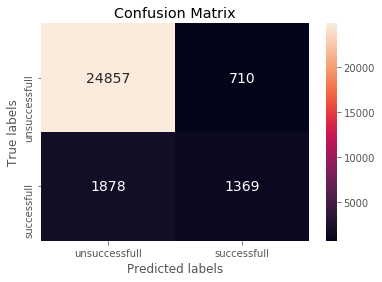

Accuracy score: 0.910182550149233
Sensitivity score: 0.42161995688327686
Specificity score: 0.9722298275120272
f1-score: 0.5140818625610214
Precision score: 0.6584896584896585
Recall score: 0.42161995688327686
AUC: 0.93


In [148]:
y_train_pred = pd.DataFrame({'response':stats_model.predict(X_train_sm)})
y_train_pred_prob = y_train_pred['response'].values.reshape(-1)
y_train_pred_final, conf_matrix = createfinaldf_and_checkscores(y_train,y_train_pred,y_train_pred_prob)

### <font size=3 color=blue>Lets check if we need to change the cutoff and see if senstivity and specificty can change</font>

In [149]:
#check_cutoff(y_train_pred_final)
cutoff_df = check_cutoff(y_train_pred_final)
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.112688  1.000000  0.000000
0.1   0.1  0.836885  0.882353  0.831110
0.2   0.2  0.890990  0.728673  0.911605
0.3   0.3  0.907545  0.617801  0.944342
0.4   0.4  0.911224  0.509085  0.962295
0.5   0.5  0.910183  0.421620  0.972230
0.6   0.6  0.907128  0.331999  0.980170
0.7   0.7  0.904040  0.250385  0.987054
0.8   0.8  0.898105  0.155836  0.992373
0.9   0.9  0.891928  0.065599  0.996871


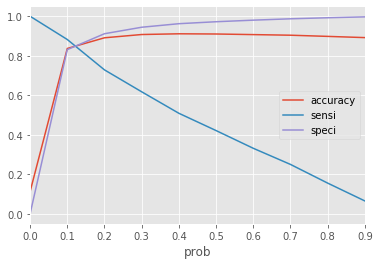

In [150]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

### Observations from above plot
- 0.1 is the optimum point to take it as cutoff probability

### Based on the probability cutoff lets do predictions mapping again

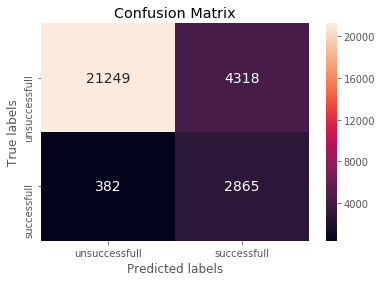

Accuracy score: 0.8368848476435067
Sensitivity score: 0.8823529411764706
Specificity score: 0.831110415770329
f1-score: 0.5493767976989454
Precision score: 0.398858415703745
Recall score: 0.8823529411764706
AUC: 0.93


In [151]:
y_train_pred_final, conf_matrix = createfinaldf_and_checkscores(y_train,y_train_pred,y_train_pred_prob,
                                                                prob_cutoff=0.1)

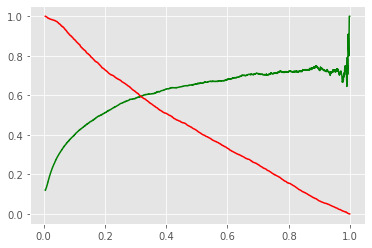

In [152]:
p, r, thresholds = precision_recall_curve(y_train_pred_final['response'], y_train_pred_final['response_Prob'])
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

### Lets store results in results_df

In [153]:
store_results(y_train_pred_final, #dataframe
              conf_matrix, #confusion_matrix
              'StatsModel', #model_name
              0, #location or index
              'train' #train or test set
             )

## Evaluate model on test data and check the score

In [154]:
transformed_X_test_scaled.drop(columns=['emp.var.rate','euribor3m'],inplace=True)

In [155]:
# add constant to test data
X_test_sm = sm.add_constant(transformed_X_test_scaled)

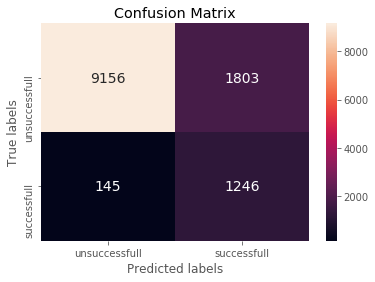

Accuracy score: 0.8422672064777328
Sensitivity score: 0.8957584471603163
Specificity score: 0.8354776895702163
f1-score: 0.5612612612612612
Precision score: 0.40865857658248605
Recall score: 0.8957584471603163
AUC: 0.93


In [156]:
y_test_pred = pd.DataFrame({'response':stats_model.predict(X_test_sm)})
y_test_pred_prob = y_test_pred['response'].values.reshape(-1)
y_test_pred_final, conf_matrix = createfinaldf_and_checkscores(y_test,y_test_pred,y_test_pred_prob,
                                                               prob_cutoff=0.1)## probability cutoff found is 0.1

### Draw ROC Curve

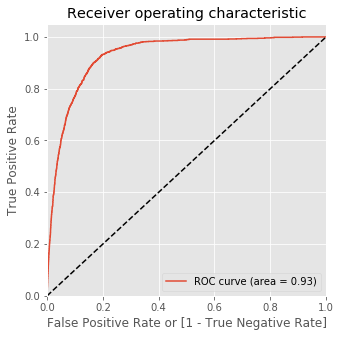

In [157]:
draw_roc(y_test_pred_final['response'],y_test_pred_final['response_Prob'])

### Lets store results in results_df

In [158]:
store_results(y_test_pred_final, #dataframe
              conf_matrix, #confusion_matrix
              'StatsModel', #model_name
              0, #location or index
              'test' #train or test set
             )

In [159]:
results_df

,model_type,train_acc,train_sen,train_spec,train_f1,test_acc,test_sen,test_spec,test_f1
0,StatsModel,0.84,0.88,0.83,0.55,0.84,0.9,0.84,0.56


## Model 2 - Logistic Regression - No PCA

### Lets filter scaled X_train and X_test with features from final stats model

In [160]:
X_train_sm.drop(columns=['const'],inplace=True)
filtered_columns = list(X_train_sm.columns)
print('final list of columns: \n{0}'.format(filtered_columns))

final list of columns: 
['duration', 'campaign', 'cons.price.idx', 'cons.conf.idx', 'nr.employed', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'pdays', 'previous', 'poutcome', 'age_bins']


In [161]:
# Note that we will filter columns of X_train which is not scaled dataframe
# This is because we will pass standardization scaling as pipeline step in gridsearch
X_train_selected = X_train[filtered_columns]
X_test_selected = X_test[filtered_columns]

## Logistic Regression

In [162]:
#make numerical columns list using selected columns from stats model having low VIF
statsmodel_numerical_columns = list(X_train_selected.select_dtypes(exclude=['object']))

#Use Transformer to use scalar only on continuous variables
transformer = ColumnTransformer(transformers=[('std_scaler', StandardScaler(), statsmodel_numerical_columns)],
                                remainder='passthrough')

#create Logistic Regression variable
#instead of using class_weight as 'balanced', lets give actual weight for classes
logistic_reg = LogisticRegression(class_weight='balanced')#'{1:0.9, 0:0.1}')

#create steps variable
#these steps will be used in Pipeline during model building
steps = [('transform_scaler', transformer),
         ('logistic', logistic_reg)
        ]

#create pipeline
pipeline = Pipeline(steps)

#create parameters that will be used during gridsearch
params = {
    'logistic__C':[0.1,0.5,0.8,1,2,5], #regularization term. smaller number means more regularization
    'logistic__penalty':['l1','l2'], #norm used in penalization
    'logistic__solver':['liblinear','saga']
    }

#create stratified k-fold. This will ensure equal presence of classes in k-fold split
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

#create GridSearchCV object to find best param that we will use in our final model building process
logistic_gridsearch = GridSearchCV(estimator = pipeline, param_grid=params, verbose=1, scoring='roc_auc', 
                          n_jobs=-1, return_train_score=True
                         )

## Fit the model

In [163]:
logistic_gridsearch.fit(X_train_selected,y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    5.6s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('transform_scaler',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('std_scaler',
                                                                         StandardScaler(copy=True,
                                                                                        with_mean=True,
                                                                                        with_std=True),
                                                                         ['duration',
                                                          

In [164]:
# printing the optimal accuracy score and hyperparameters
print("best accuracy", logistic_gridsearch.best_score_)
print(logistic_gridsearch.best_params_)

best accuracy 0.9268310917286099
{'logistic__C': 0.1, 'logistic__penalty': 'l1', 'logistic__solver': 'liblinear'}


In [165]:
# scores of GridSearch CV
scores = logistic_gridsearch.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logistic__C,param_logistic__penalty,param_logistic__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.255100,0.009061,0.014514,0.000397,0.1,l1,liblinear,"{'logistic__C': 0.1, 'logistic__penalty': 'l1'...",0.920043,0.922519,0.930461,0.928654,0.932479,0.926831,0.004756,1,0.928885,0.928530,0.926414,0.926920,0.925962,0.927342,0.001161
1,0.453292,0.038149,0.013808,0.001640,0.1,l1,saga,"{'logistic__C': 0.1, 'logistic__penalty': 'l1'...",0.920045,0.922506,0.930456,0.928655,0.932474,0.926827,0.004755,3,0.928881,0.928524,0.926409,0.926916,0.925957,0.927337,0.001161
2,0.231067,0.006789,0.015252,0.002683,0.1,l2,liblinear,"{'logistic__C': 0.1, 'logistic__penalty': 'l2'...",0.920023,0.922539,0.930466,0.928686,0.932436,0.926830,0.004751,2,0.928889,0.928537,0.926414,0.926931,0.925974,0.927349,0.001160
3,0.341696,0.008030,0.013381,0.000768,0.1,l2,saga,"{'logistic__C': 0.1, 'logistic__penalty': 'l2'...",0.920023,0.922532,0.930455,0.928672,0.932425,0.926822,0.004747,4,0.928880,0.928530,0.926409,0.926927,0.925967,0.927343,0.001159
4,0.237586,0.022306,0.015633,0.000713,0.5,l1,liblinear,"{'logistic__C': 0.5, 'logistic__penalty': 'l1'...",0.920014,0.922510,0.930458,0.928661,0.932425,0.926814,0.004753,19,0.928880,0.928533,0.926411,0.926923,0.925970,0.927343,0.001158


### predict y_train data

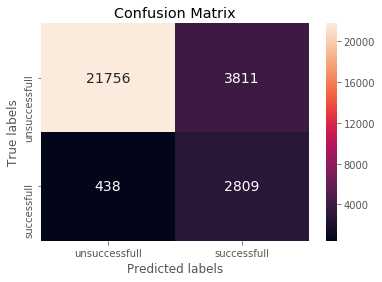

Accuracy score: 0.8525369611994169
Sensitivity score: 0.8651062519248537
Specificity score: 0.8509406657018813
f1-score: 0.5693726563291781
Precision score: 0.4243202416918429
Recall score: 0.8651062519248537
AUC: 0.93


In [166]:
y_train_pred = logistic_gridsearch.predict(X_train_selected)
# check area under curve
y_train_pred_prob = logistic_gridsearch.predict_proba(X_train_selected)[:, 1]
y_train_pred_final, conf_matrix = createfinaldf_and_checkscores(y_train,y_train_pred,y_train_pred_prob)

### <font size=3 color=blue>Lets check if we need to change the cutoff and see if senstivity and specificty can change</font>

In [167]:
#check_cutoff(y_train_pred_final)
cutoff_df = check_cutoff(y_train_pred_final)
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.112688  1.000000  0.000000
0.1   0.1  0.576144  0.986449  0.524035
0.2   0.2  0.708926  0.977210  0.674854
0.3   0.3  0.775456  0.951340  0.753119
0.4   0.4  0.820261  0.913459  0.808425
0.5   0.5  0.852537  0.865106  0.850941
0.6   0.6  0.877560  0.800739  0.887316
0.7   0.7  0.895120  0.718817  0.917511
0.8   0.8  0.907476  0.619649  0.944029
0.9   0.9  0.909558  0.451802  0.967693


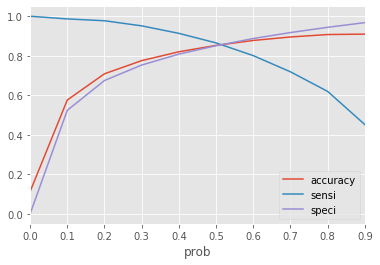

In [168]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

### Observations from above plot
- 0.5 is the optimum point to take it as cutoff probability

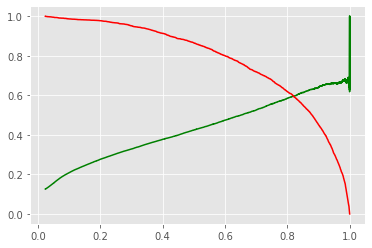

In [169]:
p, r, thresholds = precision_recall_curve(y_train_pred_final['response'], y_train_pred_final['response_Prob'])
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

### Draw ROC Curve

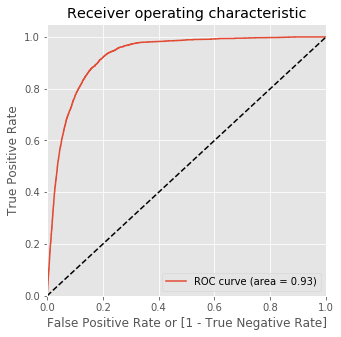

In [170]:
draw_roc(y_train_pred_final['response'],y_train_pred_final['response_Prob'])

### Lets store results in results_df

In [171]:
store_results(y_train_pred_final, #dataframe
              conf_matrix, #confusion_matrix
              'Logistic', #model_name
              1, #location or index
              'train' #train or test set
             )

## Evaluate model on test data and check the score

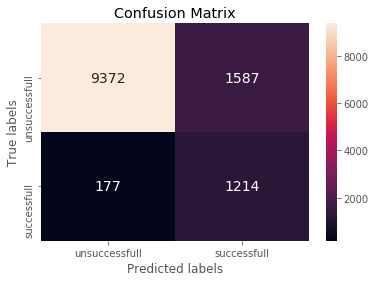

Accuracy score: 0.857165991902834
Sensitivity score: 0.8727534148094895
Specificity score: 0.8551875171092252
f1-score: 0.5791984732824428
Precision score: 0.43341663691538734
Recall score: 0.8727534148094895
AUC: 0.93


In [172]:
# predict churn on test data
y_test_pred = logistic_gridsearch.predict(X_test_selected)

# check area under curve
y_pred_prob = logistic_gridsearch.predict_proba(X_test_selected)[:, 1]### Test model on test data and check the score 

# use funtcion to final predictions and confusion matrix
y_test_pred_final, conf_matrix = createfinaldf_and_checkscores(y_test,y_test_pred,y_pred_prob)# here default cutoff probability is 0.5

### Draw ROC Curve

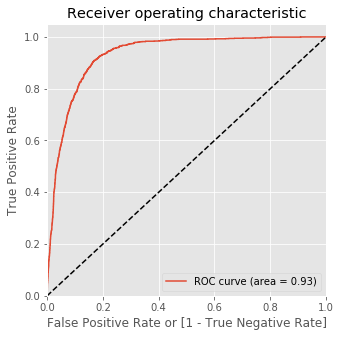

In [173]:
draw_roc(y_test_pred_final['response'],y_test_pred_final['response_Prob'])

### Lets store results in results_df

In [174]:
store_results(y_test_pred_final, #dataframe
              conf_matrix, #confusion_matrix
              'Logistic', #model_name
              1, #location or index
              'test' #train or test set
             )

In [175]:
results_df

,model_type,train_acc,train_sen,train_spec,train_f1,test_acc,test_sen,test_spec,test_f1
0,StatsModel,0.84,0.88,0.83,0.55,0.84,0.9,0.84,0.56
1,Logistic,0.85,0.87,0.85,0.57,0.86,0.87,0.86,0.58


### Feature Importance

In [176]:
logistic_gridsearch.best_estimator_

Pipeline(memory=None,
         steps=[('transform_scaler',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('std_scaler',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  ['duration', 'campaign',
                                                   'cons.price.idx',
                                                   'cons.conf.idx',
                                                   'nr.employed', 'job',
                                                   'marital', 'education',
                                                   'default', 'housing', '...
          

In [177]:
#features list
features_list = logistic_gridsearch.best_estimator_.named_steps['transform_scaler'].transformers[0][2]

#features importance
features_importance = list(logistic_gridsearch.best_estimator_.named_steps['logistic'].coef_.round(4).tolist()[0])

#create dataframe with feature importance in percentage
params_df = pd.DataFrame({'feature':features_list,'coefficient':features_importance})
params_df = params_df.sort_values(by='coefficient',ascending=False).reset_index(drop=True)
params_df

,feature,coefficient
0,duration,1.5976
1,poutcome,0.2776
2,education,0.1642
3,cons.conf.idx,0.1088
4,marital,0.0924
5,age_bins,0.0888
6,job,0.0669
7,previous,0.0644
8,day_of_week,0.0399
9,housing,0.0000


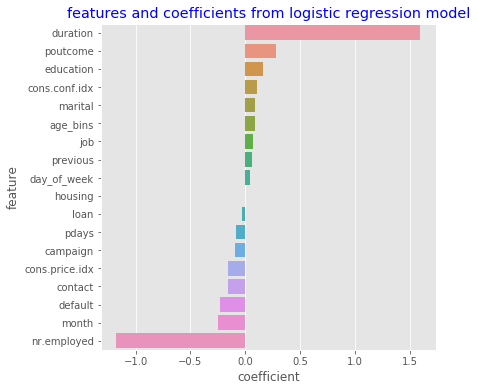

In [178]:
plt.figure(figsize=(6,6))
plt.title('features and coefficients from logistic regression model',color='blue')
sns.barplot(y='feature',x='coefficient',data=params_df);

### Observation from above plot
- duration forms the very important predictor with positive coefficient. This means more the duration of call, more likely the person going to respond to the campaign
- nr.employed also is an important predictor
- since duration of call is not known beforehand so we will later on drop duration feature and will rebuild the model

## Model 3 - Logistic Regression using PCA 
- <b><font color=blue>Before doing that lets do PCA and check how many components explain maximum variance ratio</font></b>

In [179]:
#Use Transformer to use scalar only on continuous variables
#We will use all numerical columns of original list(X_train)
transformer = ColumnTransformer(transformers=[('std_scaler', StandardScaler(), numerical_columns)],
                                remainder='passthrough')
pca = Pipeline([
    ('transform_scaler', transformer),
    ('pca',PCA(svd_solver='randomized',random_state=42))
])

In [180]:
pca.fit(X_train)
telecom_pca = pca.fit_transform(X_train)

In [181]:
# extract pca model from pipeline
pca = pca.named_steps['pca']

#look at explainded variance of PCA components
pca.explained_variance_ratio_

array([3.96407399e-01, 1.72323900e-01, 1.05224450e-01, 6.00958708e-02,
       5.23552293e-02, 3.90397009e-02, 3.21107218e-02, 2.95721174e-02,
       2.85788224e-02, 2.60609674e-02, 1.62579618e-02, 1.59864990e-02,
       9.17077924e-03, 4.90160804e-03, 4.60700922e-03, 3.84311778e-03,
       2.36849629e-03, 6.08274873e-04, 2.74059270e-04, 2.13015276e-04])

In [182]:
pca.components_

array([[-8.24575910e-04, -2.62148216e-03, -3.50252590e-03,
        -6.44829157e-03,  1.43862889e-02, -3.91694460e-03,
        -6.51495356e-03,  9.99092345e-01,  5.38467347e-03,
         1.21829344e-02, -3.47169571e-03,  2.26675332e-03,
        -1.08430387e-03, -4.83601683e-03, -3.47344805e-02,
        -1.79780395e-03, -1.98441962e-03,  1.25058099e-03,
         1.22410034e-03,  7.24183777e-03],
       [ 7.82878195e-03, -5.27779419e-02, -1.67358208e-01,
        -7.20630277e-02, -1.75539819e-02, -1.43878927e-01,
        -1.80708767e-01,  3.10480332e-02,  3.17974823e-03,
        -3.87582912e-02, -1.15126398e-02, -1.65765844e-03,
        -2.86852260e-03,  3.38553535e-02,  9.51178057e-01,
         1.74345136e-02, -1.04193014e-02,  3.11569288e-02,
        -1.65128016e-02, -1.11694816e-02],
       [ 2.36932463e-02, -9.41440183e-02, -4.85282957e-01,
        -4.19520888e-01, -1.31632415e-01, -4.93455449e-01,
        -4.33936862e-01, -1.99174573e-02,  3.51905236e-02,
         1.11577200e-01, -4.6

In [183]:
col_list = list(X_train.columns)
pca_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'Feature':col_list})
pca_df

,PC1,PC2,Feature
0,-0.000825,0.007829,job
1,-0.002621,-0.052778,marital
2,-0.003503,-0.167358,education
3,-0.006448,-0.072063,default
4,0.014386,-0.017554,housing
5,-0.003917,-0.143879,loan
6,-0.006515,-0.180709,contact
7,0.999092,0.031048,month
8,0.005385,0.003180,day_of_week
9,0.012183,-0.038758,duration


In [184]:
## cumsum of explained variance ratio
print(pd.Series(np.round(pca.explained_variance_ratio_.cumsum(), 4)*100))

0      39.64
1      56.87
2      67.40
3      73.41
4      78.64
5      82.54
6      85.76
7      88.71
8      91.57
9      94.18
10     95.80
11     97.40
12     98.32
13     98.81
14     99.27
15     99.65
16     99.89
17     99.95
18     99.98
19    100.00
dtype: float64


## Scree Plot

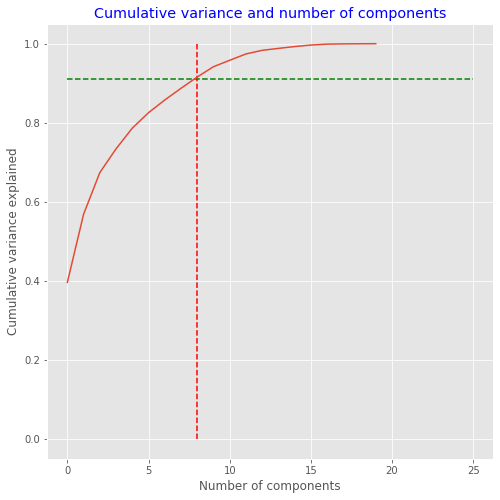

In [185]:
plt.figure(figsize=(8,8));
plt.plot(np.cumsum(pca.explained_variance_ratio_));
plt.ylabel('Cumulative variance explained')
plt.xlabel('Number of components')
plt.title('Cumulative variance and number of components',color='blue')
plt.vlines(x=8, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.91, xmax=25, xmin=0, colors="g", linestyles="--");

### Observations from above cumulative explained variance ratio and screen plot
- 8 components can describe around 91% of variance
- we will choose 8 as n_components for PCA

## Logistic Regression  with PCA

In [186]:
#Use Transformer to use scalar only on continuous variables
#We will use all numerical columns of original list(X_train)
transformer = ColumnTransformer(transformers=[('std_scaler', StandardScaler(), numerical_columns)],
                                remainder='passthrough')

#create PCA variable
pca = PCA(svd_solver='randomized',random_state=42)

#create Logistic Regression variable
#instead of using class_weight as 'balanced', lets give actual weight for classes
logistic_reg = LogisticRegression(class_weight='balanced')#'{1:0.9, 0:0.1}')


#create steps variable
#these steps will be used in Pipeline during model building
steps = [('transform_scaler', transformer),
         ('pca',pca),
         ('logistic', logistic_reg)
        ]

#create pipeline
pipeline = Pipeline(steps)

#create parameters that will be used during gridsearch
params = {
    'pca__n_components':[6,7,8,9,10,12], #number of pca compnents
    'logistic__C':[0.1,0.5,0.8,1,2,5], #regularization term. smaller number means more regularization
    'logistic__penalty':['l1','l2'], #norm used in penalization
    'logistic__solver':['liblinear','saga']
    }

#create stratified k-fold. This will ensure equal presence of classes in k-fold split
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

#create GridSearchCV object to find best param that we will use in our final model building process
logistic_pca_gridsearch = GridSearchCV(estimator = pipeline, param_grid=params, verbose=1, scoring='roc_auc', 
                          n_jobs=-1, return_train_score=True
                         )

## Fit the model

In [187]:
logistic_pca_gridsearch.fit(X_train,y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:   36.1s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('transform_scaler',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('std_scaler',
                                                                         StandardScaler(copy=True,
                                                                                        with_mean=True,
                                                                                        with_std=True),
                                                                         ['duration',
                                                          

In [188]:
# printing the optimal accuracy score and hyperparameters
print("best accuracy", logistic_pca_gridsearch.best_score_)
print(logistic_pca_gridsearch.best_params_)

best accuracy 0.922172602546004
{'logistic__C': 5, 'logistic__penalty': 'l1', 'logistic__solver': 'liblinear', 'pca__n_components': 12}


In [189]:
# scores of GridSearch CV
scores = logistic_pca_gridsearch.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logistic__C,param_logistic__penalty,param_logistic__solver,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.299950,0.007531,0.031034,0.002388,0.1,l1,liblinear,6,"{'logistic__C': 0.1, 'logistic__penalty': 'l1'...",0.754225,0.754941,0.747927,0.743340,0.774995,0.755086,0.010829,122,0.755891,0.754470,0.759643,0.759232,0.750923,0.756032,0.003220
1,0.426577,0.011014,0.029074,0.005951,0.1,l1,liblinear,7,"{'logistic__C': 0.1, 'logistic__penalty': 'l1'...",0.890536,0.887286,0.902519,0.893401,0.908505,0.896449,0.007879,117,0.899440,0.896879,0.896722,0.898666,0.892990,0.896939,0.002231
2,0.479407,0.028171,0.039082,0.006946,0.1,l1,liblinear,8,"{'logistic__C': 0.1, 'logistic__penalty': 'l1'...",0.890580,0.887524,0.902531,0.893875,0.908547,0.896611,0.007797,95,0.899450,0.897189,0.896754,0.898762,0.893049,0.897041,0.002227
3,0.533644,0.017388,0.027916,0.003275,0.1,l1,liblinear,9,"{'logistic__C': 0.1, 'logistic__penalty': 'l1'...",0.902277,0.901874,0.910471,0.908824,0.917062,0.908102,0.005642,70,0.909572,0.910051,0.906241,0.909518,0.907046,0.908486,0.001537
4,0.533276,0.017466,0.033355,0.006792,0.1,l1,liblinear,10,"{'logistic__C': 0.1, 'logistic__penalty': 'l1'...",0.911263,0.910663,0.919626,0.916750,0.922164,0.916093,0.004530,46,0.917588,0.918042,0.915507,0.916659,0.914390,0.916437,0.001342


### predict y_train data

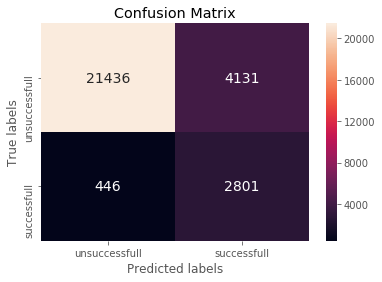

Accuracy score: 0.8411536058860276
Sensitivity score: 0.8626424391746227
Specificity score: 0.838424531622795
f1-score: 0.5503487572453091
Precision score: 0.40406809001731103
Recall score: 0.8626424391746227
AUC: 0.92


In [190]:
y_train_pred = logistic_pca_gridsearch.predict(X_train)
# check area under curve
y_train_pred_prob = logistic_pca_gridsearch.predict_proba(X_train)[:, 1]
y_train_pred_final, conf_matrix = createfinaldf_and_checkscores(y_train,y_train_pred,y_train_pred_prob)

### <font size=3 color=blue>Lets check if we need to change the cutoff and see if senstivity and specificty can change</font>

In [191]:
#check_cutoff(y_train_pred_final)
cutoff_df = check_cutoff(y_train_pred_final)
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.112688  1.000000  0.000000
0.1   0.1  0.577393  0.986757  0.525404
0.2   0.2  0.698410  0.974746  0.663316
0.3   0.3  0.765253  0.952880  0.741424
0.4   0.4  0.811411  0.916538  0.798060
0.5   0.5  0.841154  0.862642  0.838425
0.6   0.6  0.866593  0.802279  0.874760
0.7   0.7  0.891060  0.726209  0.911996
0.8   0.8  0.903137  0.602710  0.941292
0.9   0.9  0.905185  0.409917  0.968084


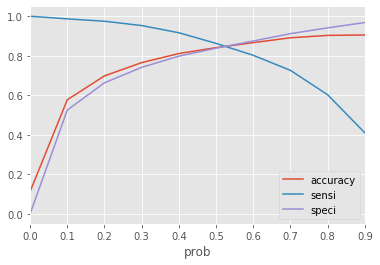

In [192]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

### Observations from above plot
- 0.5 is the optimum point to take it as cutoff probability

In [193]:
from sklearn.metrics import precision_recall_curve

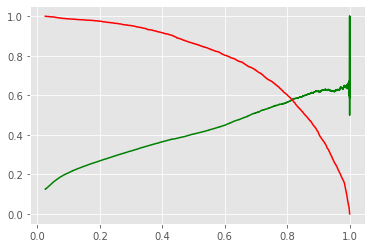

In [194]:
p, r, thresholds = precision_recall_curve(y_train_pred_final['response'], y_train_pred_final['response_Prob'])
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

### Draw ROC Curve

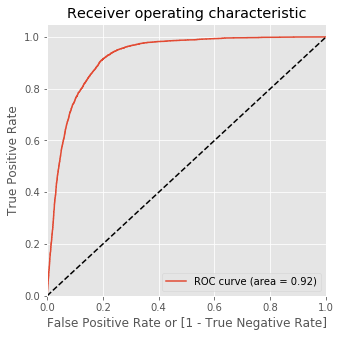

In [195]:
draw_roc(y_train_pred_final['response'],y_train_pred_final['response_Prob'])

### Lets store results in results_df

In [196]:
store_results(y_train_pred_final, #dataframe
              conf_matrix, #confusion_matrix
              'Logistic_with_PCA', #model_name
              2, #location or index
              'train' #train or test set
             )

## Evaluate model on test data and check the score

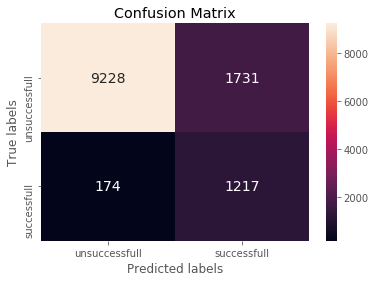

Accuracy score: 0.845748987854251
Sensitivity score: 0.8749101365923796
Specificity score: 0.8420476320832193
f1-score: 0.5609587462548974
Precision score: 0.41282225237449116
Recall score: 0.8749101365923796
AUC: 0.93


In [197]:
# predict churn on test data
y_test_pred = logistic_pca_gridsearch.predict(X_test)

# check area under curve
y_pred_prob = logistic_pca_gridsearch.predict_proba(X_test)[:, 1]### Test model on test data and check the score 

# use funtcion to final predictions and confusion matrix
y_test_pred_final, conf_matrix = createfinaldf_and_checkscores(y_test,y_test_pred,y_pred_prob)

### Draw ROC Curve

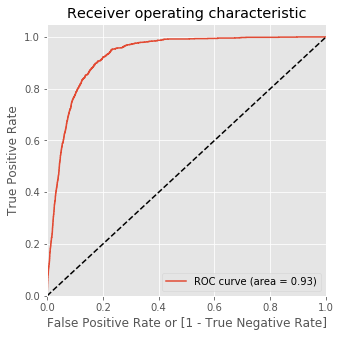

In [198]:
draw_roc(y_test_pred_final['response'],y_test_pred_final['response_Prob'])

### Lets store results in results_df

In [199]:
store_results(y_test_pred_final, #dataframe
              conf_matrix, #confusion_matrix
              'Logistic_with_PCA', #model_name
              2, #location or index
              'test' #train or test set
             )

In [200]:
results_df

,model_type,train_acc,train_sen,train_spec,train_f1,test_acc,test_sen,test_spec,test_f1
0,StatsModel,0.84,0.88,0.83,0.55,0.84,0.9,0.84,0.56
1,Logistic,0.85,0.87,0.85,0.57,0.86,0.87,0.86,0.58
2,Logistic_with_PCA,0.84,0.86,0.84,0.55,0.85,0.87,0.84,0.56


## Model 4 - Random Forest

In [201]:
#Lets use all columns of original X_train and apply transformation on only numerical continuous columns
#Use Transformer to only use scalar on continuous variables
transformer = ColumnTransformer(transformers=[('std_scaler', StandardScaler(), numerical_columns)])

#create RandomForest variable
#instead of using class_weight as 'balanced', lets give actual weight for classes
random_forest = RandomForestClassifier(class_weight='balanced')#'{1:0.9, 0:0.1}')

#create steps variable
#these steps will be used in Pipeline during model building
steps = [('transform_scaler', transformer),
         ('randomforest', random_forest)
        ]

#create pipeline
pipeline = Pipeline(steps)

#create parameters that will be used during gridsearch
params = {
    'randomforest__max_depth': [4,8,10],#[4,8,10], # maximum depth of the tree,
    'randomforest__min_samples_leaf': [50],#[50,80,100,120], #minimum sample observations at the leaf
    'randomforest__min_samples_split': [50],#[50,80,100,120], #minmum sample observations at the node during split
    'randomforest__n_estimators': [200],#[100,200,300], # no. of trees to be build
    'randomforest__max_features': [5,8,10,12,15,20], # number of features
    'randomforest__criterion': ['gini','entropy'] #function to measure quality of split
}

#create stratified k-fold. This will ensure equal presence of classes in k-fold split
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

#create GridSearchCV object to find best param that we will use in our final model building process
randomforest_gridsearch = GridSearchCV(estimator = pipeline, param_grid=params, verbose=1, scoring='roc_auc', 
                          n_jobs=-1, return_train_score=True
                         )

## Fit the model

In [202]:
randomforest_gridsearch.fit(X_train,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   16.5s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('transform_scaler',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('std_scaler',
                                                                         StandardScaler(copy=True,
                                                                                        with_mean=True,
                                                                                        with_std=True),
                                                                         ['duration',
                                                                 

In [203]:
# printing the optimal accuracy score and hyperparameters
print("best accuracy", randomforest_gridsearch.best_score_)
print(randomforest_gridsearch.best_params_)

best accuracy 0.9415917780573778
{'randomforest__criterion': 'entropy', 'randomforest__max_depth': 10, 'randomforest__max_features': 5, 'randomforest__min_samples_leaf': 50, 'randomforest__min_samples_split': 50, 'randomforest__n_estimators': 200}


In [204]:
# scores of GridSearch CV
scores = randomforest_gridsearch.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforest__criterion,param_randomforest__max_depth,param_randomforest__max_features,param_randomforest__min_samples_leaf,param_randomforest__min_samples_split,param_randomforest__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,3.759877,0.023488,0.142495,0.002449,gini,4,5,50,50,200,"{'randomforest__criterion': 'gini', 'randomfor...",0.932521,0.927864,0.933171,0.934251,0.941545,0.93387,0.004414,6,0.936712,0.937015,0.937013,0.935745,0.935748,0.936447,0.000582
1,0.195713,0.003255,0.000000,0.000000,gini,4,8,50,50,200,"{'randomforest__criterion': 'gini', 'randomfor...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.200943,0.003025,0.000000,0.000000,gini,4,10,50,50,200,"{'randomforest__criterion': 'gini', 'randomfor...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,33,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.182888,0.015437,0.000000,0.000000,gini,4,12,50,50,200,"{'randomforest__criterion': 'gini', 'randomfor...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.186847,0.009979,0.000000,0.000000,gini,4,15,50,50,200,"{'randomforest__criterion': 'gini', 'randomfor...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### predict y_train data

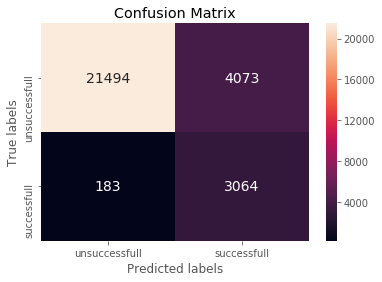

Accuracy score: 0.8522940237384604
Sensitivity score: 0.9436402833384663
Specificity score: 0.8406930809246294
f1-score: 0.5901386748844376
Precision score: 0.4293120358694129
Recall score: 0.9436402833384663
AUC: 0.95


In [205]:
y_train_pred = randomforest_gridsearch.predict(X_train)
# check area under curve
y_train_pred_prob = randomforest_gridsearch.predict_proba(X_train)[:, 1]
y_train_pred_final, conf_matrix = createfinaldf_and_checkscores(y_train,y_train_pred,y_train_pred_prob)

### <font size=3 color=blue>Lets check if we need to change the cutoff and see if senstivity and specificty can change</font>

In [206]:
#check_cutoff(y_train_pred_final)
cutoff_df = check_cutoff(y_train_pred_final)
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.425661  1.000000  0.352720
0.1   0.1  0.736482  0.998460  0.703211
0.2   0.2  0.774415  0.993532  0.746587
0.3   0.3  0.798084  0.986757  0.774123
0.4   0.4  0.825571  0.971666  0.807017
0.5   0.5  0.852294  0.943640  0.840693
0.6   0.6  0.879885  0.888820  0.878750
0.7   0.7  0.897133  0.820450  0.906872
0.8   0.8  0.910807  0.728673  0.933938
0.9   0.9  0.913271  0.429319  0.974733


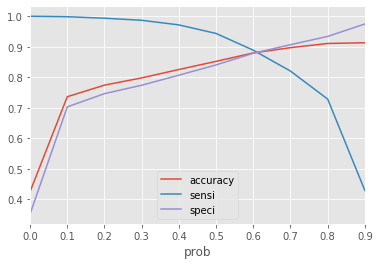

In [207]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

### Observations from above plot
- 0.6 is the optimum point to take it as cutoff probability

### Based on the probability cutoff lets do predictions mapping again

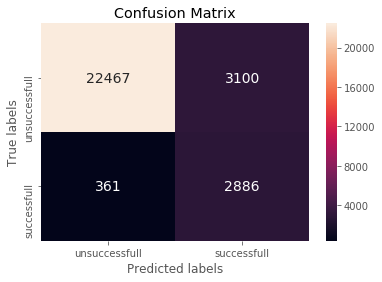

Accuracy score: 0.8798847782328035
Sensitivity score: 0.888820449645827
Specificity score: 0.8787499511088512
f1-score: 0.625148922343767
Precision score: 0.48212495823588375
Recall score: 0.888820449645827
AUC: 0.95


In [208]:
y_train_pred_final, conf_matrix = createfinaldf_and_checkscores(y_train,y_train_pred,y_train_pred_prob,
                                                                prob_cutoff=0.6)

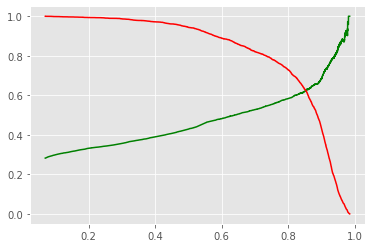

In [209]:
p, r, thresholds = precision_recall_curve(y_train_pred_final['response'], y_train_pred_final['response_Prob'])
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

### Draw ROC Curve

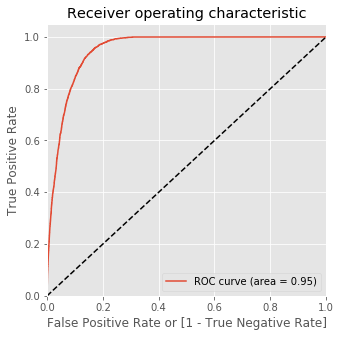

In [210]:
draw_roc(y_train_pred_final['response'],y_train_pred_final['response_Prob'])

### Lets store results in results_df

In [211]:
store_results(y_train_pred_final, #dataframe
              conf_matrix, #confusion_matrix
              'RandomForest', #model_name
              3, #location or index
              'train' #train or test set
             )

## Evaluate model on test data and check the score

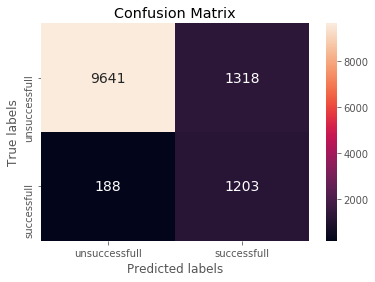

Accuracy score: 0.8780566801619433
Sensitivity score: 0.8648454349388929
Specificity score: 0.8797335523314171
f1-score: 0.6150306748466257
Precision score: 0.4771915906386355
Recall score: 0.8648454349388929
AUC: 0.94


In [212]:
# predict churn on test data
y_test_pred = randomforest_gridsearch.predict(X_test)

# check area under curve
y_pred_prob = randomforest_gridsearch.predict_proba(X_test)[:, 1]### Test model on test data and check the score 

# use funtcion to final predictions and confusion matrix
y_test_pred_final, conf_matrix = createfinaldf_and_checkscores(y_test,y_test_pred,y_pred_prob,
                                                               prob_cutoff=0.6)#cutoff probability found is 0.6

### Draw ROC Curve

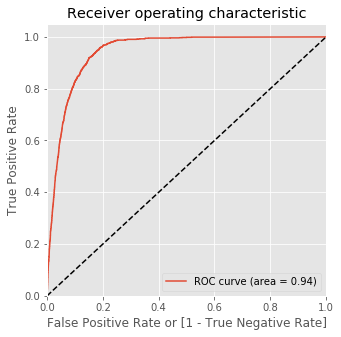

In [213]:
draw_roc(y_test_pred_final['response'],y_test_pred_final['response_Prob'])

### Lets store results in results_df

In [214]:
store_results(y_test_pred_final, #dataframe
              conf_matrix, #confusion_matrix
              'RandomForest', #model_name
              3, #location or index
              'test' #train or test set
             )

In [215]:
results_df

,model_type,train_acc,train_sen,train_spec,train_f1,test_acc,test_sen,test_spec,test_f1
0,StatsModel,0.84,0.88,0.83,0.55,0.84,0.9,0.84,0.56
1,Logistic,0.85,0.87,0.85,0.57,0.86,0.87,0.86,0.58
2,Logistic_with_PCA,0.84,0.86,0.84,0.55,0.85,0.87,0.84,0.56
3,RandomForest,0.88,0.89,0.88,0.63,0.88,0.86,0.88,0.62


### Feature Importance

In [216]:
randomforest_gridsearch.best_estimator_

Pipeline(memory=None,
         steps=[('transform_scaler',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('std_scaler',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  ['duration', 'campaign',
                                                   'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed'])],
                                   verbose=False)),
                ('randomfo...
            

In [217]:
#features list
features_list = randomforest_gridsearch.best_estimator_.named_steps['transform_scaler'].transformers[0][2]

#features importance
features_importance = list(randomforest_gridsearch.best_estimator_.named_steps['randomforest'].feature_importances_)

#create dataframe with feature importance in percentage
params_df = pd.DataFrame({'feature':features_list,'coefficient':features_importance})
params_df = params_df.sort_values(by='coefficient',ascending=False).reset_index(drop=True)
params_df

,feature,coefficient
0,duration,0.519677
1,nr.employed,0.192577
2,euribor3m,0.144742
3,emp.var.rate,0.060159
4,cons.conf.idx,0.055510
5,cons.price.idx,0.018159
6,campaign,0.009176


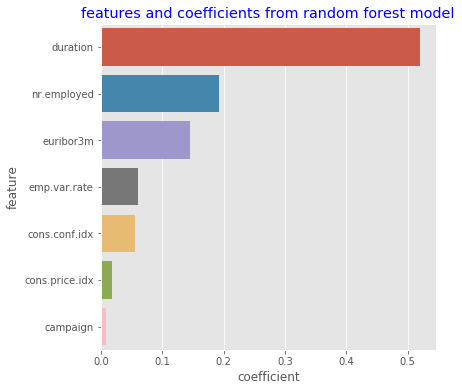

In [218]:
plt.figure(figsize=(6,6))
plt.title('features and coefficients from random forest model',color='blue')
sns.barplot(y='feature',x='coefficient',data=params_df);

### Observation from above plot
- duration forms the very important predictor with positive coefficient. This means more the duration of call, more likely the person going to respond to the campaign
- nr.employed also is an important predictor with positive coefficient
- since duration of call is not known beforehand so we will later on drop duration feature and will rebuild the model

## Model 5 - XGBoost

<font color=blue>Please note that this cell takes long time to excute so have commented the hyperparameter range. Have provide only the best parameters while building the model. If you want to rebuild the model with the range please uncomment</font>

In [219]:
#Lets use all columns of original X_train and apply transformation on only numerical continuous columns
#Use Transformer to only use scalar on continuous variables
transformer = ColumnTransformer(transformers=[('std_scaler', StandardScaler(), numerical_columns)])

#create XGBoost variable
#instead of using class_weight as 'balanced', lets give actual weight for classes
xgboost = XGBClassifier(class_weight='balanced')#'{1:0.9, 0:0.1}')

#create steps variable
#these steps will be used in Pipeline during model building
steps = [('transform_scaler', transformer),
         ('xgboost', xgboost)
        ]

#create pipeline
pipeline = Pipeline(steps)

#create parameters that will be used during gridsearch
params = {
    'xgboost__learning_rate': [0.03],#[0.001,0.01,0.02,0.03],# learning rate,
    'xgboost__min_child_weight': [1],#[1,5,10], #minimum sum of weights of all observations required in a child
    'xgboost__gamma': [1.5],#[0.5, 1, 1.5, 2, 5], #minimum loss reduction required to make a split
    'xgboost__n_estimators': [300],#[100,200,300], # no. of trees to be build
    'xgboost__colsample_bytree': [1],#[0.5, 0.6, 0.8, 1.0] #fraction of columns to be randomly samples for each tree
    #'xgboost__max_depth': [50]#[5,10,20,50] #maximum depth in a tree
}

#create stratified k-fold. This will ensure equal presence of classes in k-fold split
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

#create GridSearchCV object to find best param that we will use in our final model building process
xgboost_gridsearch = GridSearchCV(estimator = pipeline, param_grid=params, verbose=1, scoring='roc_auc', 
                          n_jobs=-1, return_train_score=True
                         )

## Fit the model

In [220]:
xgboost_gridsearch.fit(X_train,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.4s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('transform_scaler',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('std_scaler',
                                                                         StandardScaler(copy=True,
                                                                                        with_mean=True,
                                                                                        with_std=True),
                                                                         ['duration',
                                                                 

In [221]:
# printing the optimal accuracy score and hyperparameters
print("best accuracy", xgboost_gridsearch.best_score_)
print(xgboost_gridsearch.best_params_)

best accuracy 0.9422251539330745
{'xgboost__colsample_bytree': 1, 'xgboost__gamma': 1.5, 'xgboost__learning_rate': 0.03, 'xgboost__min_child_weight': 1, 'xgboost__n_estimators': 300}


In [222]:
# scores of GridSearch CV
scores = xgboost_gridsearch.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgboost__colsample_bytree,param_xgboost__gamma,param_xgboost__learning_rate,param_xgboost__min_child_weight,param_xgboost__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,3.136245,0.0048,0.035743,0.000317,1,1.5,0.03,1,300,"{'xgboost__colsample_bytree': 1, 'xgboost__gam...",0.942261,0.938615,0.94067,0.941661,0.947919,0.942225,0.003105,1,0.946924,0.946943,0.946976,0.946557,0.94557,0.946594,0.000534


### predict y_train data

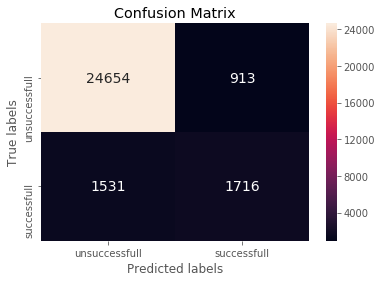

Accuracy score: 0.9151801207746234
Sensitivity score: 0.5284878349245458
Specificity score: 0.9642899049556068
f1-score: 0.5840707964601771
Precision score: 0.6527196652719666
Recall score: 0.5284878349245458
AUC: 0.95


In [223]:
y_train_pred = xgboost_gridsearch.predict(X_train)
# check area under curve
y_train_pred_prob = xgboost_gridsearch.predict_proba(X_train)[:, 1]
y_train_pred_final, conf_matrix = createfinaldf_and_checkscores(y_train,y_train_pred,y_train_pred_prob)

<b> Its an overfitted model</b>

### <font size=3 color=blue>Lets check if we need to change the cutoff and see if senstivity and specificty can change</font>

In [224]:
#check_cutoff(y_train_pred_final)
cutoff_df = check_cutoff(y_train_pred_final)
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.112688  1.000000  0.000000
0.1   0.1  0.827306  0.955959  0.810967
0.2   0.2  0.884639  0.865414  0.887081
0.3   0.3  0.902929  0.770249  0.919779
0.4   0.4  0.911779  0.673237  0.942074
0.5   0.5  0.915180  0.528488  0.964290
0.6   0.6  0.907857  0.287034  0.986702
0.7   0.7  0.897723  0.120111  0.996480
0.8   0.8  0.891615  0.045273  0.999100
0.9   0.9  0.887277  0.000000  0.999961


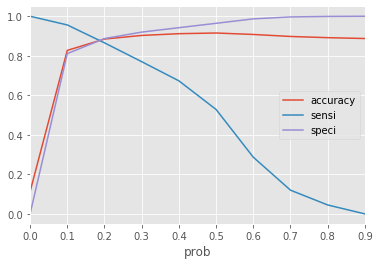

In [225]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

### Observations from above plot
- 0.1 is the optimum point to take it as cutoff probability

### Based on the probability cutoff lets do predictions mapping again

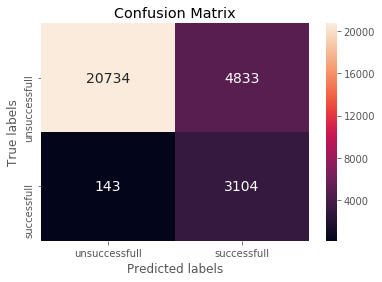

Accuracy score: 0.8273061706115082
Sensitivity score: 0.9559593470896212
Specificity score: 0.8109672624867994
f1-score: 0.5550786838340487
Precision score: 0.39107975305531056
Recall score: 0.9559593470896212
AUC: 0.95


In [226]:
y_train_pred_final, conf_matrix = createfinaldf_and_checkscores(y_train,y_train_pred,y_train_pred_prob,
                                                                prob_cutoff=0.1)

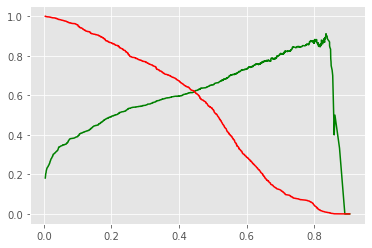

In [227]:
p, r, thresholds = precision_recall_curve(y_train_pred_final['response'], y_train_pred_final['response_Prob'])
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

### Lets store results in results_df

In [228]:
store_results(y_train_pred_final, #dataframe
              conf_matrix, #confusion_matrix
              'XGBoost', #model_name
              4, #location or index
              'train' #train or test set
             )

### Draw ROC Curve

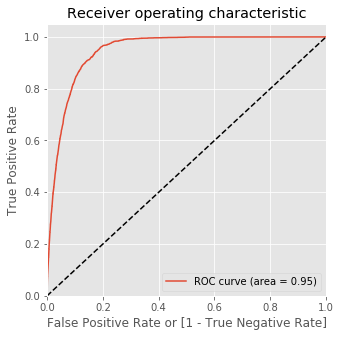

In [229]:
draw_roc(y_train_pred_final['response'],y_train_pred_final['response_Prob'])

## Evaluate model on test data and check the score

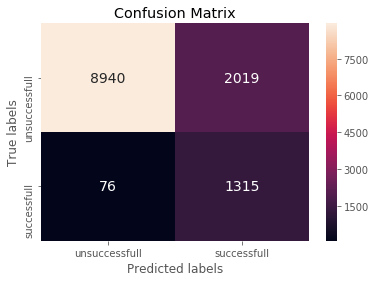

Accuracy score: 0.8303643724696357
Sensitivity score: 0.9453630481667865
Specificity score: 0.8157678620312072
f1-score: 0.5566137566137566
Precision score: 0.39442111577684463
Recall score: 0.9453630481667865
AUC: 0.94


In [230]:
# predict churn on test data
y_test_pred = xgboost_gridsearch.predict(X_test)

# check area under curve
y_pred_prob = xgboost_gridsearch.predict_proba(X_test)[:, 1]### Test model on test data and check the score 

# use funtcion to final predictions and confusion matrix
y_test_pred_final, conf_matrix = createfinaldf_and_checkscores(y_test,y_test_pred,y_pred_prob,
                                                              prob_cutoff=0.1)# cutoof probability found is 0.1

### Draw ROC Curve

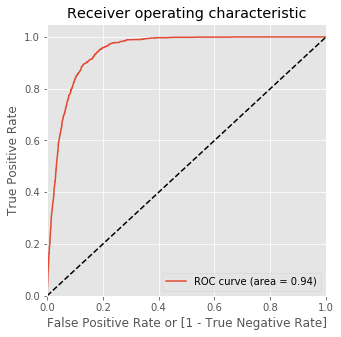

In [231]:
draw_roc(y_test_pred_final['response'],y_test_pred_final['response_Prob'])

### Lets store results in results_df

In [232]:
store_results(y_test_pred_final, #dataframe
              conf_matrix, #confusion_matrix
              'XGBoost', #model_name
              4, #location or index
              'test' #train or test set
             )

In [233]:
results_df

,model_type,train_acc,train_sen,train_spec,train_f1,test_acc,test_sen,test_spec,test_f1
0,StatsModel,0.84,0.88,0.83,0.55,0.84,0.9,0.84,0.56
1,Logistic,0.85,0.87,0.85,0.57,0.86,0.87,0.86,0.58
2,Logistic_with_PCA,0.84,0.86,0.84,0.55,0.85,0.87,0.84,0.56
3,RandomForest,0.88,0.89,0.88,0.63,0.88,0.86,0.88,0.62
4,XGBoost,0.83,0.96,0.81,0.56,0.83,0.95,0.82,0.56


## Observations from above cell
- Logistic Regression gave the best result. Train and Test scores are almost stable and Sensitivity and Test Sensitivity is better. 
- We will use Logistic Regression to finally build our model

### Feature Importance

In [234]:
xgboost_gridsearch.best_estimator_

Pipeline(memory=None,
         steps=[('transform_scaler',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('std_scaler',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  ['duration', 'campaign',
                                                   'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed'])],
                                   verbose=False)),
                ('xgboost'...
            

In [235]:
#features list
features_list = xgboost_gridsearch.best_estimator_.named_steps['transform_scaler'].transformers[0][2]

#features importance
features_importance = list(xgboost_gridsearch.best_estimator_.named_steps['xgboost'].feature_importances_)

#create dataframe with feature importance in percentage
params_df = pd.DataFrame({'feature':features_list,'coefficient':features_importance})
params_df = params_df.sort_values(by='coefficient',ascending=False).reset_index(drop=True)
params_df

,feature,coefficient
0,nr.employed,0.536077
1,duration,0.210854
2,cons.conf.idx,0.080053
3,emp.var.rate,0.061599
4,euribor3m,0.059727
5,cons.price.idx,0.042075
6,campaign,0.009615


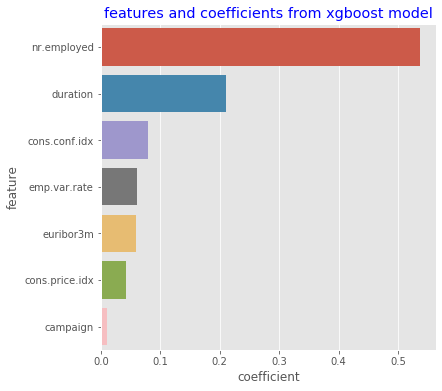

In [236]:
plt.figure(figsize=(6,6))
plt.title('features and coefficients from xgboost model',color='blue')
sns.barplot(y='feature',x='coefficient',data=params_df);

### Observation from above plot
- nr.employed forms the very important predictor with positive coefficient. This means more the duration of call, more likely the person going to respond to the campaign
- duration also is an important predictor with positive coefficient
- since duration of call is not known beforehand so we will later on drop duration feature and will rebuild the model

# Final Model with feature 'duration' in the model

## Logistic Regression

In [237]:
#make numerical columns list using selected columns from stats model having low VIF
statsmodel_numerical_columns = list(X_train_selected.select_dtypes(exclude=['object']))

#Use Transformer to use scalar only on continuous variables
transformer = ColumnTransformer(transformers=[('std_scaler', StandardScaler(), statsmodel_numerical_columns)],
                                remainder='passthrough')

#create Logistic Regression variable
#using class_weight as 'balanced'
logistic_reg = LogisticRegression(class_weight='balanced',
                                 C = logistic_gridsearch.best_params_['logistic__C'], 
    penalty = logistic_gridsearch.best_params_['logistic__penalty'], 
    solver = logistic_gridsearch.best_params_['logistic__solver'], )#'{1:0.9, 0:0.1}')

#create steps variable
#these steps will be used in Pipeline during model building
steps = [('transform_scaler', transformer),
         ('logistic', logistic_reg)
        ]

#create pipeline
logistic_pipeline = Pipeline(steps)

## Fit the model

In [238]:
logistic_pipeline.fit(X_train_selected,y_train)

Pipeline(memory=None,
         steps=[('transform_scaler',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('std_scaler',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  ['duration', 'campaign',
                                                   'cons.price.idx',
                                                   'cons.conf.idx',
                                                   'nr.employed', 'job',
                                                   'marital', 'education',
                                                   'default', 'housing', '...
          

### predict y_train data

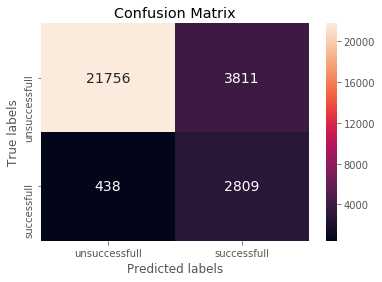

Accuracy score: 0.8525369611994169
Sensitivity score: 0.8651062519248537
Specificity score: 0.8509406657018813
f1-score: 0.5693726563291781
Precision score: 0.4243202416918429
Recall score: 0.8651062519248537
AUC: 0.93


In [239]:
y_train_pred = logistic_pipeline.predict(X_train_selected)
# check area under curve
y_train_pred_prob = logistic_pipeline.predict_proba(X_train_selected)[:, 1]
y_train_pred_final, conf_matrix = createfinaldf_and_checkscores(y_train,y_train_pred,y_train_pred_prob)

### <font size=3 color=blue>Lets check if we need to change the cutoff and see if senstivity and specificty can change</font>

In [240]:
#check_cutoff(y_train_pred_final)
cutoff_df = check_cutoff(y_train_pred_final)
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.112688  1.000000  0.000000
0.1   0.1  0.576144  0.986449  0.524035
0.2   0.2  0.708926  0.977210  0.674854
0.3   0.3  0.775456  0.951340  0.753119
0.4   0.4  0.820261  0.913459  0.808425
0.5   0.5  0.852537  0.865106  0.850941
0.6   0.6  0.877560  0.800739  0.887316
0.7   0.7  0.895120  0.718817  0.917511
0.8   0.8  0.907476  0.619649  0.944029
0.9   0.9  0.909558  0.451802  0.967693


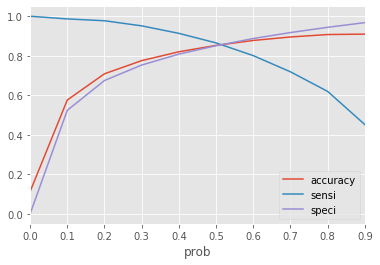

In [241]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

### Observations from above plot
- 0.5 is the optimum point to take it as cutoff probability

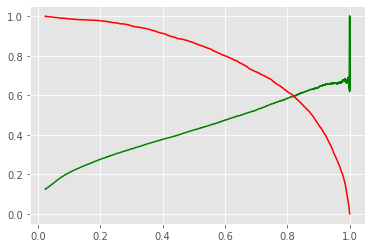

In [242]:
p, r, thresholds = precision_recall_curve(y_train_pred_final['response'], y_train_pred_final['response_Prob'])
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

### Draw ROC Curve

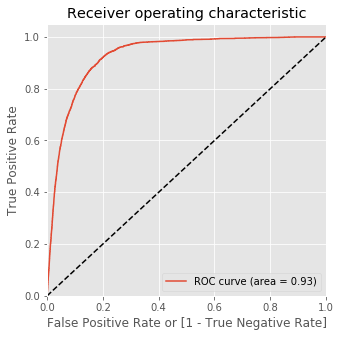

In [243]:
draw_roc(y_train_pred_final['response'],y_train_pred_final['response_Prob'])

## Evaluate model on test data and check the score

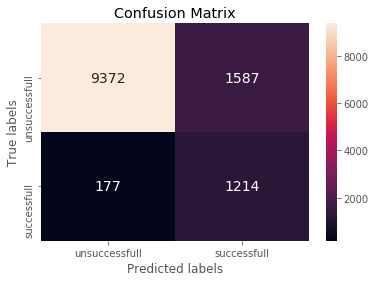

Accuracy score: 0.857165991902834
Sensitivity score: 0.8727534148094895
Specificity score: 0.8551875171092252
f1-score: 0.5791984732824428
Precision score: 0.43341663691538734
Recall score: 0.8727534148094895
AUC: 0.93


In [244]:
# predict churn on test data
y_test_pred = logistic_pipeline.predict(X_test_selected)

# check area under curve
y_pred_prob = logistic_pipeline.predict_proba(X_test_selected)[:, 1]### Test model on test data and check the score 

# use funtcion to final predictions and confusion matrix
y_test_pred_final, conf_matrix = createfinaldf_and_checkscores(y_test,y_test_pred,y_pred_prob)

### Draw ROC Curve

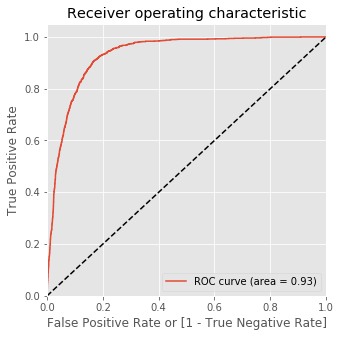

In [245]:
draw_roc(y_test_pred_final['response'],y_test_pred_final['response_Prob'])

### Feature Importance

In [246]:
#features list
features_list = logistic_pipeline.named_steps['transform_scaler'].transformers[0][2]

#features importance
features_importance = list(logistic_pipeline.named_steps['logistic'].coef_.round(4).tolist()[0])

#create dataframe with feature importance in percentage
params_df = pd.DataFrame({'feature':features_list,'coefficient':features_importance})
params_df = params_df.sort_values(by='coefficient',ascending=False).reset_index(drop=True)
params_df

,feature,coefficient
0,duration,1.5976
1,poutcome,0.2776
2,education,0.1642
3,cons.conf.idx,0.1088
4,marital,0.0924
5,age_bins,0.0888
6,job,0.0669
7,previous,0.0644
8,day_of_week,0.0399
9,housing,0.0000


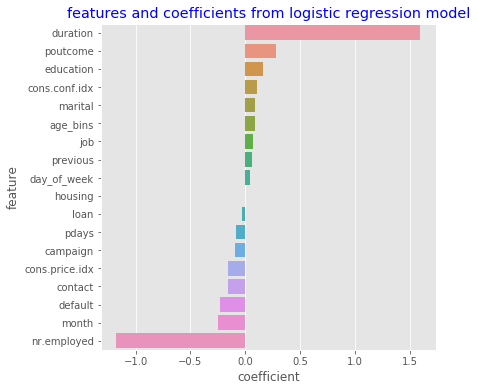

In [247]:
plt.figure(figsize=(6,6))
plt.title('features and coefficients from logistic regression model',color='blue')
sns.barplot(y='feature',x='coefficient',data=params_df);

### Observation from above plot
- duration forms the very important predictor with positive coefficient. This means more the duration of call, more likely the person going to respond to the campaign
- nr.employed also is an important predictor
- since duration of call is not known beforehand so we will later on drop duration feature and will rebuild the model

## Lets check train and test data set

In [248]:
print('shape of train data set: {0}'.format(y_train_pred_final.shape))
print('shape of test data set: {0}'.format(y_test_pred_final.shape))

shape of train data set: (28814, 14)
shape of test data set: (12350, 4)


### Lets make a copy of dataframe 
- This to avoid overwriting of original data

In [249]:
y_train_pred_final_copy = y_train_pred_final.copy()
y_test_pred_final_copy = y_test_pred_final.copy()

### Lets rearrange the columns

In [250]:
y_train_pred_final_copy = y_train_pred_final_copy[['responseId','response','predicted','response_Prob']]
y_train_pred_final_copy.head()

,responseId,response,predicted,response_Prob
0,33842,0,0,0.208653
1,11448,1,1,0.549888
2,9167,0,0,0.016797
3,20799,0,0,0.094593
4,36974,0,1,0.736288


In [251]:
y_test_pred_final_copy = y_test_pred_final_copy[['responseId','response','predicted','response_Prob']]
y_test_pred_final_copy.head()

,responseId,response,predicted,response_Prob
0,29844,0,1,0.780731
1,11597,0,0,0.009022
2,40908,1,1,0.681008
3,34918,0,0,0.233514
4,720,0,0,0.128586


<b>----------------------------------------------------------------------------------</b>

## Lift and Gain Charts

In [252]:
y_test_pred_final_copy.head()

,responseId,response,predicted,response_Prob
0,29844,0,1,0.780731
1,11597,0,0,0.009022
2,40908,1,1,0.681008
3,34918,0,0,0.233514
4,720,0,0,0.128586


In [253]:
y_test_pred_final_copy['duration'] = y_test_pred_final_copy['responseId'].map(lambda x:marketing_df.iloc[x]['duration'])
#duration is in seconds so we need to convert it into minutes and cost of call is 1 unit per minute
y_test_pred_final_copy['cost_of_Call'] = round(y_test_pred_final_copy['duration']/60) 
y_test_pred_final_copy.head()

,responseId,response,predicted,response_Prob,duration,cost_of_Call
0,29844,0,1,0.780731,534,9.0
1,11597,0,0,0.009022,11,0.0
2,40908,1,1,0.681008,253,4.0
3,34918,0,0,0.233514,241,4.0
4,720,0,0,0.128586,254,4.0


In [254]:
decile_df = y_test_pred_final_copy[['responseId','response_Prob','response','duration','cost_of_Call']].copy()
decile_df.head()

,responseId,response_Prob,response,duration,cost_of_Call
0,29844,0.780731,0,534,9.0
1,11597,0.009022,0,11,0.0
2,40908,0.681008,1,253,4.0
3,34918,0.233514,0,241,4.0
4,720,0.128586,0,254,4.0


In [255]:
decile_df['decile'] = pd.qcut(decile_df['response_Prob'], 10, labels=np.arange(10, 0, -1))

In [256]:
decile_df.head()

,responseId,response_Prob,response,duration,cost_of_Call,decile
0,29844,0.780731,0,534,9.0,2
1,11597,0.009022,0,11,0.0,10
2,40908,0.681008,1,253,4.0,2
3,34918,0.233514,0,241,4.0,4
4,720,0.128586,0,254,4.0,5


In [257]:
lift_df = decile_df.groupby('decile')['response_Prob'].count().reset_index()

In [258]:
lift_df.rename({'response_Prob':'total'}, axis=1, inplace=True)

In [259]:
lift_df_pred = decile_df[decile_df['response']==1].groupby('decile')['response'].count().reset_index()

In [260]:
#calculate average duration of every decile
lift_df_duration = decile_df[decile_df['response']==1].groupby('decile')['duration'].mean().reset_index()

In [261]:
#rename the column
lift_df_duration.rename({'duration':'avg_duration'}, axis=1, inplace=True)

In [262]:
lift_df_final = lift_df.merge(lift_df_pred,on = 'decile')
lift_df_final = lift_df_final.merge(lift_df_duration,on = 'decile')

In [263]:
#calculate cost of call for every decile
lift_df_callcost = decile_df[decile_df['response']==1].groupby('decile')['cost_of_Call'].sum().reset_index()

In [264]:
#rename the columns
lift_df_callcost.rename({'cost_of_Call':'total_callcost'}, axis=1, inplace=True)

In [265]:
lift_df_final = lift_df_final.merge(lift_df_callcost,on = 'decile')

In [266]:
lift_df_final = lift_df_final.sort_values(['decile'], ascending=False)

In [267]:
#calculate cumulative sum of response
lift_df_final['cumresp'] = lift_df_final['response'].cumsum()

In [268]:
lift_df_final['gain'] = 100*(lift_df_final['cumresp']/sum(lift_df_final['response']))

In [269]:
lift_df_final['cumlift'] = lift_df_final['gain']/(lift_df_final['decile'].astype('int')*(100/10))

In [270]:
lift_df_final

,decile,total,response,avg_duration,total_callcost,cumresp,gain,cumlift
9,1,1235,760,680.378947,8594.0,760,54.636952,5.463695
8,2,1235,390,386.966667,2528.0,1150,82.674335,4.133717
7,3,1235,162,328.234568,886.0,1312,94.320633,3.144021
6,4,1235,51,294.254902,253.0,1363,97.987060,2.449676
5,5,1235,11,322.363636,58.0,1374,98.777858,1.975557
4,6,1235,5,370.000000,31.0,1379,99.137311,1.652289
3,7,1235,4,297.750000,20.0,1383,99.424874,1.420355
2,8,1235,5,139.200000,11.0,1388,99.784328,1.247304
1,9,1235,2,160.000000,6.0,1390,99.928109,1.110312
0,10,1235,1,37.000000,1.0,1391,100.000000,1.000000


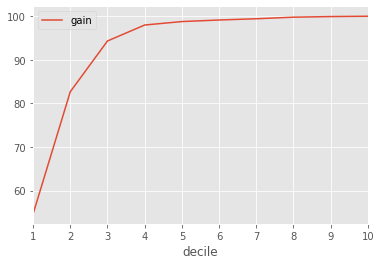

In [271]:
lift_df_final.plot.line(x='decile', y=['gain'])

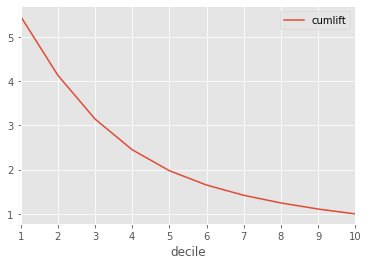

In [272]:
lift_df_final.plot.line(x='decile', y=['cumlift'])

## Observations from above cells
- One can attain more than 80% of total conversions by targeting 20% of the total client base. 
- Thus 20% of the total client base can be called to achieve 80% of the response rate
- But for this acquistion we have assumed that duration of call is know beforehand and this feature forms a very important predictor role while we had build our model
- Since the duration of call is known prior at hand so it cannot be made sure whether the person will respond to the campaign or nbot depending on this feature. For this we will make another model by dropping this feature and will arrive at top final percentage of client base that we should target to achieve 80% acquisition/response rate

<b><font color=black size=8>Part - II</font></b>

<font color=blue size=6>Preparation for Model Building <u>without</u> 'duration' feature</font>

<font size=3>We will start fresh by
- dropping the duration feature
- setting X and y
- doing train test split
- Building Logistic Reegression model with selected feature(using Stats model and VIF)
- Building Logictic Regression model with PCA
- Will evaluate model like accuracy, sensitivity, probability cutoff
- Build Final model with best paarmeters
- Will do financial benefits of using model and will calculate acquisition cost</font>

## Set X and y

In [273]:
X = marketing_le_df.drop(['response','duration'],axis=1)
y = marketing_le_df['response']

print('shape of X: {0}'.format(X.shape))
print('shape of y: {0}'.format(y.shape))

shape of X: (41164, 19)
shape of y: (41164,)


In [274]:
categorical_columns = list(marketing_df.select_dtypes(include=['object']))
numerical_columns = list(marketing_df.select_dtypes(exclude=['object']))
print('Catgeorical Columns list: \n{0}'.format(categorical_columns))
print('\nNumerical Columns list: \n{0}'.format(numerical_columns))

Catgeorical Columns list: 
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'pdays', 'previous', 'poutcome', 'age_bins']

Numerical Columns list: 
['duration', 'campaign', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'response']


Drop response column from numerical columns list as well

In [275]:
numerical_columns.remove('response')
numerical_columns.remove('duration')
numerical_columns

['campaign',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed']

In [276]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42,stratify=y)

print('shape of X_train: {0}'.format(X_train.shape))
print('shape of y_train: {0}'.format(y_train.shape))
print('shape of X_test: {0}'.format(X_test.shape))
print('shape of y_test: {0}'.format(y_test.shape))

shape of X_train: (28814, 19)
shape of y_train: (28814,)
shape of X_test: (12350, 19)
shape of y_test: (12350,)


# Data Modelling

## <b><font size=4 color=blue>Please note that since we have imbalanced target class where number of response is around 11%, we will use class weights to handle class imbalance. 

Also since its important for business to identify the people who responded mopre to the campaign, we should look for the metrics where false negative count is less. In other words we should look for <u><font color=red>sensitivity/recall</font></u> of a model as deciding factor of a model</font></b>

### Scale X_train and X_test - only continuous numerical columns

<font color=green>We will use <u>ColumnTransformer</u>
This estimator allows different columns or column subsets of the input to be transformed separately and the features generated by each transformer will be concatenated to form a single feature space. This is useful for heterogeneous or columnar data, to combine several feature extraction mechanisms or transformations into a single transformer.

For more information click on link https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html</font>

In [278]:
# #Use Transformer to only use scalar on continuous variables
transformer = ColumnTransformer(transformers=[('std_scaler', StandardScaler(), numerical_columns)],
                                remainder='passthrough')
transformed_X_train_scaled = pd.DataFrame(transformer.fit_transform(X_train),columns=(numerical_columns+categorical_columns))
transformed_X_test_scaled = pd.DataFrame(transformer.transform(X_test),columns=(numerical_columns+categorical_columns))

In [279]:
transformed_X_train_scaled.head()

,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job,marital,education,default,housing,loan,contact,month,day_of_week,pdays,previous,poutcome,age_bins
0,-0.649839,-1.196601,-1.177726,-1.231307,-1.346436,-0.935192,0.0,0.0,2.0,0.0,2.0,0.0,0.0,6.0,4.0,2.0,2.0,0.0,1.0
1,-0.216613,0.839306,1.535133,-0.281512,0.772200,0.844567,6.0,1.0,1.0,0.0,2.0,2.0,1.0,4.0,0.0,2.0,1.0,1.0,1.0
2,-0.649839,0.839306,1.535133,-0.281512,0.776808,0.844567,9.0,1.0,1.0,0.0,0.0,2.0,1.0,4.0,0.0,2.0,1.0,1.0,2.0
3,-0.216613,0.839306,-0.226845,0.948903,0.775656,0.844567,0.0,1.0,3.0,0.0,0.0,0.0,0.0,1.0,4.0,2.0,1.0,1.0,0.0
4,-0.216613,-1.896444,-1.909439,1.488558,-1.474315,-1.251134,9.0,1.0,1.0,0.0,0.0,0.0,1.0,3.0,0.0,2.0,1.0,1.0,2.0


In [280]:
transformed_X_test_scaled.head()

,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job,marital,education,default,housing,loan,contact,month,day_of_week,pdays,previous,poutcome,age_bins
0,0.216613,-1.196601,-0.863642,-1.425583,-1.275008,-0.935192,6.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,3.0
1,1.083065,0.839306,1.535133,-0.281512,0.772200,0.844567,1.0,1.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,2.0,1.0,1.0,3.0
2,-0.649839,-0.751246,1.769833,-1.943652,-1.518669,-2.804629,1.0,2.0,2.0,0.0,0.0,0.0,0.0,8.0,3.0,2.0,2.0,0.0,0.0
3,-0.649839,-1.196601,-1.177726,-1.231307,-1.364293,-0.935192,1.0,1.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,2.0,2.0,0.0,1.0
4,-0.216613,0.648440,0.722311,0.884144,0.713445,0.332714,0.0,1.0,3.0,0.0,2.0,0.0,1.0,6.0,3.0,2.0,1.0,1.0,2.0


## Use -  Stats GLM Model using Binomial Families to get p-value and VIF of variables

In [281]:
stats_model,X_train_sm = build_statsmodel(transformed_X_train_scaled,list(y_train))

************ feature - coefficients *****************
const            -2.2275
campaign         -0.0884
emp.var.rate     -1.2534
cons.price.idx    0.4214
cons.conf.idx     0.0699
euribor3m         1.0448
nr.employed      -0.8052
job               0.0049
marital           0.0946
education         0.0566
default          -0.2794
housing          -0.0206
loan             -0.0074
contact          -0.7382
month            -0.0925
day_of_week       0.0518
pdays            -0.3864
previous          0.1900
poutcome          0.6888
age_bins          0.0541
dtype: float64
*****************************************************


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                28814
Model:                            GLM   Df Residuals:                    28794
Model Family:                Binomial   Df Model:                           19
Link Function:                  logit   Scale:             

In [282]:
check_vif(X_train_sm)

,Features,VIF
0,const,683.40
5,euribor3m,96.27
2,emp.var.rate,43.60
6,nr.employed,42.81
3,cons.price.idx,9.66
17,previous,3.77
18,poutcome,3.68
16,pdays,3.60
4,cons.conf.idx,3.58
13,contact,2.30


### Observations from above cells
- As we earlier saw through heatmap and also now after checking variance inflation factor, there is high multicolinearity for variables euribor3m, emp.var.rate, nr.employed, cons.price.idx

### 2. StatsModel 2

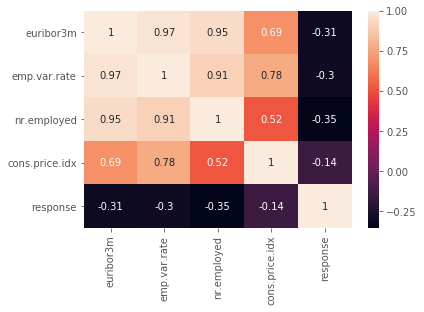

In [283]:
sns.heatmap(marketing_df[['euribor3m','emp.var.rate','nr.employed','cons.price.idx','response']].corr(),
            annot=True)

From above heatmap we can see that cons.price.idx has the lowest correlation with response variable while nr.employed has the highest correlation followed by euribor3m. euribor3m and emp.var.rate also have very high correlation. So we can try dropping emp.var.rate and rebuild the model

In [284]:
## Drop emp.var.rate
try:
    transformed_X_train_scaled.drop(columns=['emp.var.rate'],inplace=True)
except:
    print('column not found!')
stats_model,X_train_sm = build_statsmodel(transformed_X_train_scaled,list(y_train))

************ feature - coefficients *****************
const            -2.4648
campaign         -0.1068
cons.price.idx    0.0100
cons.conf.idx     0.0970
euribor3m         0.2209
nr.employed      -0.9846
job               0.0039
marital           0.0989
education         0.0604
default          -0.3123
housing          -0.0235
loan             -0.0046
contact          -0.5678
month            -0.0777
day_of_week       0.0490
pdays            -0.3500
previous          0.2108
poutcome          0.7040
age_bins          0.0597
dtype: float64
*****************************************************


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                28814
Model:                            GLM   Df Residuals:                    28795
Model Family:                Binomial   Df Model:                           18
Link Function:                  logit   Scale:                          1.0000
Metho

In [285]:
check_vif(X_train_sm)

,Features,VIF
0,const,679.79
4,euribor3m,62.85
5,nr.employed,42.74
2,cons.price.idx,7.53
16,previous,3.76
17,poutcome,3.67
15,pdays,3.60
3,cons.conf.idx,3.50
12,contact,2.19
13,month,1.62


### Observations from above cells
- As we earlier saw through heatmap and also now after checking variance inflation factor, there is high multicolinearity for variables euribor3m, nr.employed, cons.price.idx

### 3. StatsModel 3

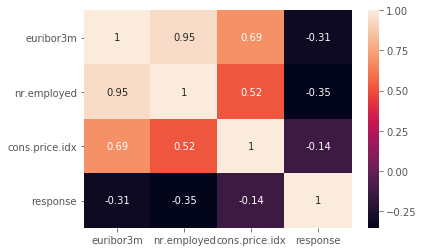

In [286]:
sns.heatmap(marketing_df[['euribor3m','nr.employed','cons.price.idx','response']].corr(),
            annot=True)

From above heatmap we can see that cons.price.idx has the lowest correlation with response variable while nr.employed has the highest correlation followed by euribor3m. euribor3m and emp.var.rate also have very high correlation. So we can try dropping euribor3m and rebuild the model

In [287]:
## Drop euribor3m
try:
    transformed_X_train_scaled.drop(columns=['euribor3m'],inplace=True)
except:
    print('column not found!')
stats_model,X_train_sm = build_statsmodel(transformed_X_train_scaled,list(y_train))

************ feature - coefficients *****************
const            -2.4782
campaign         -0.1084
cons.price.idx    0.0843
cons.conf.idx     0.1333
nr.employed      -0.8099
job               0.0041
marital           0.0978
education         0.0613
default          -0.3144
housing          -0.0227
loan             -0.0047
contact          -0.5885
month            -0.0715
day_of_week       0.0491
pdays            -0.3507
previous          0.2065
poutcome          0.7036
age_bins          0.0608
dtype: float64
*****************************************************


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                28814
Model:                            GLM   Df Residuals:                    28796
Model Family:                Binomial   Df Model:                           17
Link Function:                  logit   Scale:                          1.0000
Method:                       

In [288]:
check_vif(X_train_sm)

,Features,VIF
0,const,679.78
15,previous,3.75
16,poutcome,3.67
14,pdays,3.59
2,cons.price.idx,2.15
11,contact,1.96
4,nr.employed,1.90
12,month,1.24
17,age_bins,1.20
3,cons.conf.idx,1.18


### Observations from above cell
- Log Likelihood has minimized and also the VIF of all variables is below 4. We need not drop any more columns now

## Model 1 - Logistic Regression - No PCA

### Lets filter scaled X_train and X_test with features from final stats model

In [289]:
X_train_sm.drop(columns=['const'],inplace=True)
filtered_columns = list(X_train_sm.columns)
print('final list of columns: \n{0}'.format(filtered_columns))

final list of columns: 
['campaign', 'cons.price.idx', 'cons.conf.idx', 'nr.employed', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'pdays', 'previous', 'poutcome', 'age_bins']


In [290]:
# Note that we will filter columns of X_train which is not scaled dataframe
# This is because we will pass standardization scaling as pipeline step in gridsearch
X_train_selected = X_train[filtered_columns]
X_test_selected = X_test[filtered_columns]

## Logistic Regression

In [291]:
#make numerical columns list using selected columns from stats model having low VIF
statsmodel_numerical_columns = list(X_train_selected.select_dtypes(exclude=['object']))

#Use Transformer to use scalar only on continuous variables
transformer = ColumnTransformer(transformers=[('std_scaler', StandardScaler(), statsmodel_numerical_columns)],
                                remainder='passthrough')

#create Logistic Regression variable
#instead of using class_weight as 'balanced', lets give actual weight for classes
logistic_reg = LogisticRegression(class_weight='balanced')#'{1:0.9, 0:0.1}')

#create steps variable
#these steps will be used in Pipeline during model building
steps = [('transform_scaler', transformer),
         ('logistic', logistic_reg)
        ]

#create pipeline
pipeline = Pipeline(steps)

#create parameters that will be used during gridsearch
params = {
    'logistic__C':[0.1,0.5,0.8,1,2,5], #regularization term. smaller number means more regularization
    'logistic__penalty':['l1','l2'], #norm used in penalization
    'logistic__solver':['liblinear','saga']
    }

#create stratified k-fold. This will ensure equal presence of classes in k-fold split
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

#create GridSearchCV object to find best param that we will use in our final model building process
logistic_noduration_gridsearch = GridSearchCV(estimator = pipeline, param_grid=params, verbose=1, scoring='roc_auc', 
                          n_jobs=-1, return_train_score=True
                         )

## Fit the model

In [292]:
logistic_noduration_gridsearch.fit(X_train_selected,y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    4.3s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('transform_scaler',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('std_scaler',
                                                                         StandardScaler(copy=True,
                                                                                        with_mean=True,
                                                                                        with_std=True),
                                                                         ['campaign',
                                                          

In [293]:
# printing the optimal accuracy score and hyperparameters
print("best accuracy", logistic_noduration_gridsearch.best_score_)
print(logistic_noduration_gridsearch.best_params_)

best accuracy 0.7732627759742181
{'logistic__C': 0.1, 'logistic__penalty': 'l2', 'logistic__solver': 'saga'}


In [294]:
# scores of GridSearch CV
scores = logistic_noduration_gridsearch.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logistic__C,param_logistic__penalty,param_logistic__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.202805,0.010519,0.014719,0.001127,0.1,l1,liblinear,"{'logistic__C': 0.1, 'logistic__penalty': 'l1'...",0.764969,0.771410,0.767066,0.764433,0.798305,0.773236,0.012773,24,0.777502,0.775401,0.776276,0.776827,0.769010,0.775003,0.003075
1,0.465056,0.012034,0.017253,0.000779,0.1,l1,saga,"{'logistic__C': 0.1, 'logistic__penalty': 'l1'...",0.764971,0.771422,0.767077,0.764446,0.798311,0.773245,0.012771,23,0.777507,0.775408,0.776286,0.776834,0.769019,0.775011,0.003074
2,0.224457,0.002272,0.016403,0.001586,0.1,l2,liblinear,"{'logistic__C': 0.1, 'logistic__penalty': 'l2'...",0.764923,0.771470,0.767000,0.764573,0.798326,0.773258,0.012772,2,0.777522,0.775436,0.776323,0.776855,0.769027,0.775033,0.003079
3,0.445379,0.048064,0.014834,0.002436,0.1,l2,saga,"{'logistic__C': 0.1, 'logistic__penalty': 'l2'...",0.764930,0.771473,0.767004,0.764577,0.798330,0.773263,0.012772,1,0.777525,0.775439,0.776328,0.776859,0.769030,0.775036,0.003080
4,0.275141,0.017719,0.016325,0.001678,0.5,l1,liblinear,"{'logistic__C': 0.5, 'logistic__penalty': 'l1'...",0.764906,0.771464,0.767011,0.764531,0.798346,0.773252,0.012787,9,0.777514,0.775427,0.776309,0.776847,0.769014,0.775022,0.003081


### predict y_train data

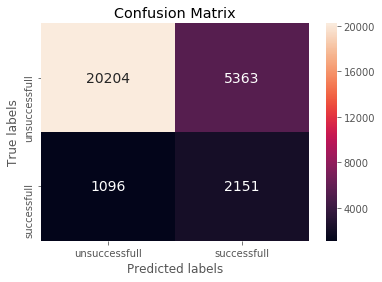

Accuracy score: 0.7758381342402999
Sensitivity score: 0.6624576532183554
Specificity score: 0.7902374154183127
f1-score: 0.3997769724003345
Precision score: 0.28626563747671013
Recall score: 0.6624576532183554
AUC: 0.77


In [295]:
y_train_pred = logistic_noduration_gridsearch.predict(X_train_selected)
# check area under curve
y_train_pred_prob = logistic_noduration_gridsearch.predict_proba(X_train_selected)[:, 1]
y_train_pred_final, conf_matrix = createfinaldf_and_checkscores(y_train,y_train_pred,y_train_pred_prob)

### <font size=3 color=blue>Lets check if we need to change the cutoff and see if senstivity and specificty can change</font>

In [296]:
#check_cutoff(y_train_pred_final)
cutoff_df = check_cutoff(y_train_pred_final)
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.112688  1.000000  0.000000
0.1   0.1  0.112758  1.000000  0.000078
0.2   0.2  0.173527  0.976286  0.071577
0.3   0.3  0.460019  0.855559  0.409786
0.4   0.4  0.702193  0.713582  0.700747
0.5   0.5  0.775838  0.662458  0.790237
0.6   0.6  0.846845  0.564521  0.882700
0.7   0.7  0.878740  0.455497  0.932491
0.8   0.8  0.893212  0.332615  0.964407
0.9   0.9  0.898660  0.175239  0.990535


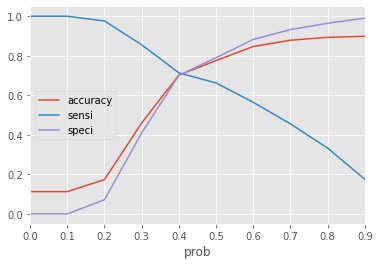

In [297]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

### Observations from above plot
- 0.4 is the optimum point to take it as cutoff probability

### Based on the probability cutoff lets do predictions mapping again

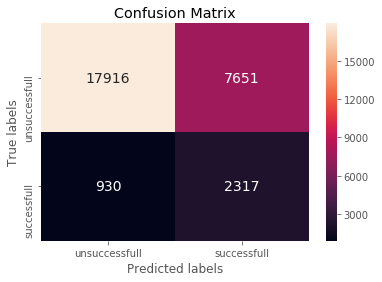

Accuracy score: 0.7021933782189214
Sensitivity score: 0.7135817677856483
Specificity score: 0.7007470567528454
f1-score: 0.3506621263715475
Precision score: 0.2324438202247191
Recall score: 0.7135817677856483
AUC: 0.77


In [298]:
y_train_pred_final, conf_matrix = createfinaldf_and_checkscores(y_train,y_train_pred,y_train_pred_prob,
                                                                prob_cutoff=0.4)#cutoff probability is 0.4

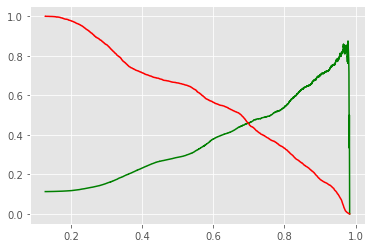

In [299]:
p, r, thresholds = precision_recall_curve(y_train_pred_final['response'], y_train_pred_final['response_Prob'])
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

### Draw ROC Curve

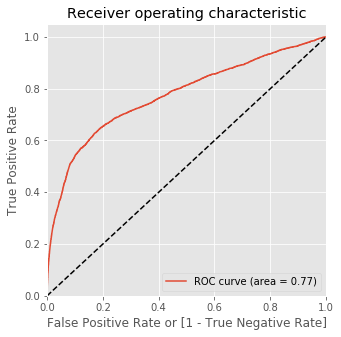

In [300]:
draw_roc(y_train_pred_final['response'],y_train_pred_final['response_Prob'])

### Lets store results in results_df

In [301]:
store_results(y_train_pred_final, #dataframe
              conf_matrix, #confusion_matrix
              'Logistic_NoDuration', #model_name
              5, #location or index
              'train' #train or test set
             )

## Evaluate model on test data and check the score

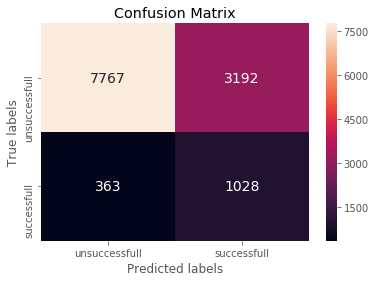

Accuracy score: 0.7121457489878542
Sensitivity score: 0.7390366642703091
Specificity score: 0.7087325485901999
f1-score: 0.3664230974870789
Precision score: 0.24360189573459715
Recall score: 0.7390366642703091
AUC: 0.79


In [302]:
# predict churn on test data
y_test_pred = logistic_noduration_gridsearch.predict(X_test_selected)

# check area under curve
y_pred_prob = logistic_noduration_gridsearch.predict_proba(X_test_selected)[:, 1]### Test model on test data and check the score 

# use funtcion to final predictions and confusion matrix
y_test_pred_final, conf_matrix = createfinaldf_and_checkscores(y_test,y_test_pred,y_pred_prob,
                                                              prob_cutoff=0.4)#cutoff probability is 0.4

### Draw ROC Curve

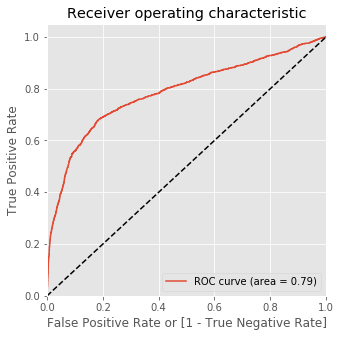

In [303]:
draw_roc(y_test_pred_final['response'],y_test_pred_final['response_Prob'])

### Lets store results in results_df

In [304]:
store_results(y_test_pred_final, #dataframe
              conf_matrix, #confusion_matrix
              'Logistic_NoDuration', #model_name
              5, #location or index
              'test' #train or test set
             )

In [305]:
results_df

,model_type,train_acc,train_sen,train_spec,train_f1,test_acc,test_sen,test_spec,test_f1
0,StatsModel,0.84,0.88,0.83,0.55,0.84,0.9,0.84,0.56
1,Logistic,0.85,0.87,0.85,0.57,0.86,0.87,0.86,0.58
2,Logistic_with_PCA,0.84,0.86,0.84,0.55,0.85,0.87,0.84,0.56
3,RandomForest,0.88,0.89,0.88,0.63,0.88,0.86,0.88,0.62
4,XGBoost,0.83,0.96,0.81,0.56,0.83,0.95,0.82,0.56
5,Logistic_NoDuration,0.7,0.71,0.7,0.35,0.71,0.74,0.71,0.37


### Feature Importance

In [306]:
logistic_noduration_gridsearch.best_estimator_

Pipeline(memory=None,
         steps=[('transform_scaler',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('std_scaler',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  ['campaign', 'cons.price.idx',
                                                   'cons.conf.idx',
                                                   'nr.employed', 'job',
                                                   'marital', 'education',
                                                   'default', 'housing', 'loan',
                                                   'cont...month',
   

In [307]:
#features list
features_list = logistic_noduration_gridsearch.best_estimator_.named_steps['transform_scaler'].transformers[0][2]

#features importance
features_importance = list(logistic_noduration_gridsearch.best_estimator_.named_steps['logistic'].coef_.round(4).tolist()[0])

#create dataframe with feature importance in percentage
params_df = pd.DataFrame({'feature':features_list,'coefficient':features_importance})
params_df = params_df.sort_values(by='coefficient',ascending=False).reset_index(drop=True)
params_df

,feature,coefficient
0,poutcome,0.2398
1,cons.conf.idx,0.1073
2,cons.price.idx,0.0933
3,education,0.0729
4,marital,0.0640
5,previous,0.0563
6,age_bins,0.0544
7,day_of_week,0.0374
8,job,0.0096
9,loan,0.0030


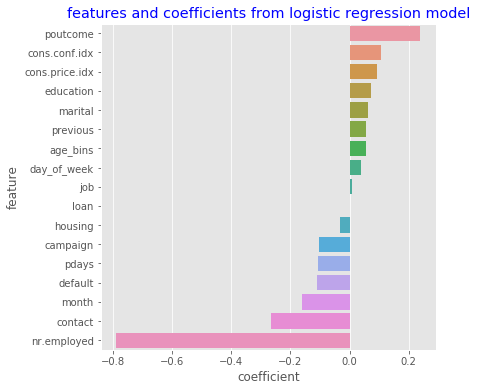

In [308]:
plt.figure(figsize=(6,6))
plt.title('features and coefficients from logistic regression model',color='blue')
sns.barplot(y='feature',x='coefficient',data=params_df);

### Observation from above plot
- nr.employed forms the very important predictor with negative coefficient.
- contact is also is an important predictor with negative coefficient. This means if the person is contacted less then there are more chance of the person responding to the campaign 

## Model 2 - Logistic Regression using PCA 
- <b><font color=blue>Before doing that lets do PCA and check how many components explain maximum variance ratio</font></b>

In [309]:
#Use Transformer to use scalar only on continuous variables
#We will use all numerical columns of original list(X_train)
transformer = ColumnTransformer(transformers=[('std_scaler', StandardScaler(), numerical_columns)],
                                remainder='passthrough')
pca = Pipeline([
    ('transform_scaler', transformer),
    ('pca',PCA(svd_solver='randomized',random_state=42))
])

In [310]:
pca.fit(X_train)
telecom_pca = pca.fit_transform(X_train)

In [311]:
# extract pca model from pipeline
pca = pca.named_steps['pca']

#look at explainded variance of PCA components
pca.explained_variance_ratio_

array([4.08902616e-01, 1.77746902e-01, 1.08498103e-01, 6.19425217e-02,
       5.39943662e-02, 4.02669771e-02, 3.08346530e-02, 3.04965465e-02,
       2.71608174e-02, 1.68364471e-02, 1.64965898e-02, 9.46095785e-03,
       5.06234643e-03, 4.75263317e-03, 3.97431795e-03, 2.44318608e-03,
       6.27539709e-04, 2.82714543e-04, 2.19764368e-04])

In [312]:
pca.components_

array([[-2.62684807e-03, -3.50547632e-03, -6.44881416e-03,
         1.43855636e-02, -3.92021660e-03, -6.51898665e-03,
         9.99092702e-01,  5.38510606e-03,  1.21821513e-02,
        -3.47205021e-03,  2.26621174e-03, -1.08409372e-03,
        -4.83715935e-03, -3.47323761e-02, -1.79555710e-03,
        -1.98522551e-03,  1.25104707e-03,  1.22476152e-03,
         7.24231698e-03],
       [-5.26452688e-02, -1.67266535e-01, -7.20211315e-02,
        -1.75280130e-02, -1.43776203e-01, -1.80598708e-01,
         3.10427831e-02,  3.16763865e-03, -3.87499898e-02,
        -1.15019570e-02, -1.64930757e-03, -2.87390905e-03,
         3.38987536e-02,  9.51274304e-01,  1.73765144e-02,
        -1.03996524e-02,  3.11425991e-02, -1.65263144e-02,
        -1.11843717e-02],
       [-9.35239195e-02, -4.85496525e-01, -4.19882623e-01,
        -1.31684300e-01, -4.93616899e-01, -4.33987840e-01,
        -1.99344748e-02,  3.51818604e-02,  1.11821489e-01,
        -4.67501481e-02,  5.41703605e-02,  5.27720792e-03,
    

In [313]:
col_list = list(X_train.columns)
pca_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'Feature':col_list})
pca_df

,PC1,PC2,Feature
0,-0.002627,-0.052645,job
1,-0.003505,-0.167267,marital
2,-0.006449,-0.072021,education
3,0.014386,-0.017528,default
4,-0.003920,-0.143776,housing
5,-0.006519,-0.180599,loan
6,0.999093,0.031043,contact
7,0.005385,0.003168,month
8,0.012182,-0.038750,day_of_week
9,-0.003472,-0.011502,campaign


In [314]:
## cumsum of explained variance ratio
print(pd.Series(np.round(pca.explained_variance_ratio_.cumsum(), 4)*100))

0      40.89
1      58.66
2      69.51
3      75.71
4      81.11
5      85.14
6      88.22
7      91.27
8      93.98
9      95.67
10     97.32
11     98.26
12     98.77
13     99.25
14     99.64
15     99.89
16     99.95
17     99.98
18    100.00
dtype: float64


## Scree Plot

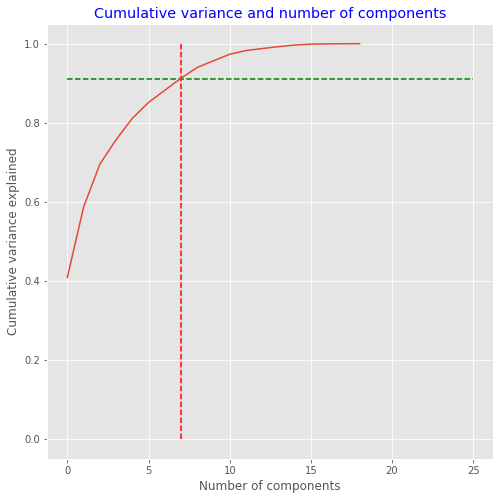

In [315]:
plt.figure(figsize=(8,8));
plt.plot(np.cumsum(pca.explained_variance_ratio_));
plt.ylabel('Cumulative variance explained')
plt.xlabel('Number of components')
plt.title('Cumulative variance and number of components',color='blue')
plt.vlines(x=7, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.91, xmax=25, xmin=0, colors="g", linestyles="--");

### Observations from above cumulative explained variance ratio and screen plot
- 7 components can describe around 91% of variance
- we will choose 7 as n_components for PCA

## Logistic Regression  with PCA

In [316]:
#Use Transformer to use scalar only on continuous variables
#We will use all numerical columns of original list(X_train)
transformer = ColumnTransformer(transformers=[('std_scaler', StandardScaler(), numerical_columns)],
                                remainder='passthrough')

#create PCA variable
pca = PCA(svd_solver='randomized',random_state=42)

#create Logistic Regression variable
#instead of using class_weight as 'balanced', lets give actual weight for classes
logistic_reg = LogisticRegression(class_weight='balanced')#'{1:0.9, 0:0.1}')


#create steps variable
#these steps will be used in Pipeline during model building
steps = [('transform_scaler', transformer),
         ('pca',pca),
         ('logistic', logistic_reg)
        ]

#create pipeline
pipeline = Pipeline(steps)

#create parameters that will be used during gridsearch
params = {
    'pca__n_components':[6,7,8,9,10,12], #number of pca compnents
    'logistic__C':[0.1,0.5,0.8,1,2,5], #regularization term. smaller number means more regularization
    'logistic__penalty':['l1','l2'], #norm used in penalization
    'logistic__solver':['liblinear','saga']
    }

#create stratified k-fold. This will ensure equal presence of classes in k-fold split
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

#create GridSearchCV object to find best param that we will use in our final model building process
logistic_noduration_pca_gridsearch = GridSearchCV(estimator = pipeline, param_grid=params, verbose=1, scoring='roc_auc', 
                          n_jobs=-1, return_train_score=True
                         )

## Fit the model

In [317]:
logistic_noduration_pca_gridsearch.fit(X_train,y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:   32.0s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('transform_scaler',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('std_scaler',
                                                                         StandardScaler(copy=True,
                                                                                        with_mean=True,
                                                                                        with_std=True),
                                                                         ['campaign',
                                                          

In [318]:
# printing the optimal accuracy score and hyperparameters
print("best accuracy", logistic_noduration_pca_gridsearch.best_score_)
print(logistic_noduration_pca_gridsearch.best_params_)

best accuracy 0.7520178835160826
{'logistic__C': 0.1, 'logistic__penalty': 'l2', 'logistic__solver': 'saga', 'pca__n_components': 12}


In [319]:
# scores of GridSearch CV
scores = logistic_noduration_pca_gridsearch.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logistic__C,param_logistic__penalty,param_logistic__solver,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.151595,0.027268,0.018253,0.004934,0.1,l1,liblinear,6,"{'logistic__C': 0.1, 'logistic__penalty': 'l1'...",0.744797,0.746159,0.737978,0.734357,0.767965,0.746251,0.011692,144,0.747421,0.746910,0.749543,0.749895,0.741394,0.747033,0.003048
1,0.300107,0.034810,0.033926,0.002909,0.1,l1,liblinear,7,"{'logistic__C': 0.1, 'logistic__penalty': 'l1'...",0.745764,0.745061,0.740281,0.733930,0.770127,0.747033,0.012297,119,0.749170,0.749046,0.750816,0.750763,0.741884,0.748336,0.003313
2,0.386454,0.004272,0.026480,0.003684,0.1,l1,liblinear,8,"{'logistic__C': 0.1, 'logistic__penalty': 'l1'...",0.744637,0.745898,0.740248,0.737214,0.770837,0.747767,0.011945,96,0.749721,0.749170,0.751169,0.751624,0.743065,0.748950,0.003077
3,0.392346,0.011012,0.032166,0.004959,0.1,l1,liblinear,9,"{'logistic__C': 0.1, 'logistic__penalty': 'l1'...",0.745368,0.746044,0.741036,0.737292,0.770471,0.748042,0.011652,71,0.750080,0.749681,0.751240,0.752074,0.743624,0.749340,0.002980
4,0.440219,0.013035,0.031880,0.003428,0.1,l1,liblinear,10,"{'logistic__C': 0.1, 'logistic__penalty': 'l1'...",0.746978,0.745236,0.745246,0.739403,0.782824,0.751938,0.015655,46,0.754428,0.754678,0.755221,0.756791,0.747439,0.753711,0.003242


### predict y_train data

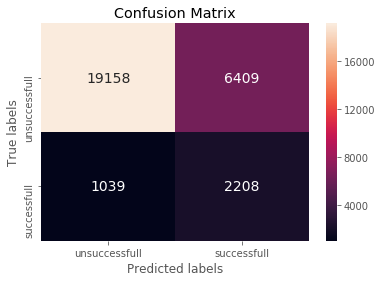

Accuracy score: 0.7415145415423058
Sensitivity score: 0.6800123190637511
Specificity score: 0.7493253021472992
f1-score: 0.3722184760620364
Precision score: 0.2562376697226413
Recall score: 0.6800123190637511
AUC: 0.75


In [320]:
y_train_pred = logistic_noduration_pca_gridsearch.predict(X_train)
# check area under curve
y_train_pred_prob = logistic_noduration_pca_gridsearch.predict_proba(X_train)[:, 1]
y_train_pred_final, conf_matrix = createfinaldf_and_checkscores(y_train,y_train_pred,y_train_pred_prob)

### <font size=3 color=blue>Lets check if we need to change the cutoff and see if senstivity and specificty can change</font>

In [321]:
#check_cutoff(y_train_pred_final)
cutoff_df = check_cutoff(y_train_pred_final)
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.112688  1.000000  0.000000
0.1   0.1  0.112688  1.000000  0.000000
0.2   0.2  0.135871  0.991069  0.027262
0.3   0.3  0.475220  0.805975  0.433215
0.4   0.4  0.715243  0.705882  0.716431
0.5   0.5  0.741515  0.680012  0.749325
0.6   0.6  0.827966  0.578688  0.859624
0.7   0.7  0.864129  0.522328  0.907537
0.8   0.8  0.884986  0.340006  0.954199
0.9   0.9  0.888457  0.036341  0.996675


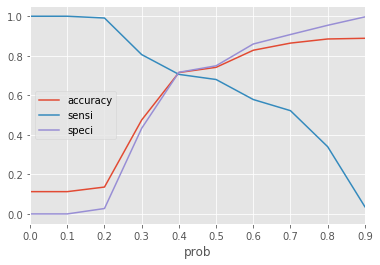

In [322]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

### Observations from above plot
- 0.4 is the optimum point to take it as cutoff probability

### Based on the probability cutoff lets do predictions mapping again

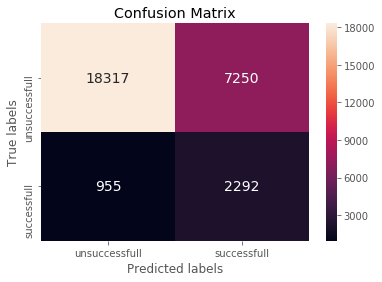

Accuracy score: 0.7152425904074409
Sensitivity score: 0.7058823529411765
Specificity score: 0.7164313372707005
f1-score: 0.3584330283837673
Precision score: 0.2402012156780549
Recall score: 0.7058823529411765
AUC: 0.75


In [323]:
y_train_pred_final, conf_matrix = createfinaldf_and_checkscores(y_train,y_train_pred,y_train_pred_prob,
                                                                prob_cutoff=0.4)#cutoff probability is 0.4

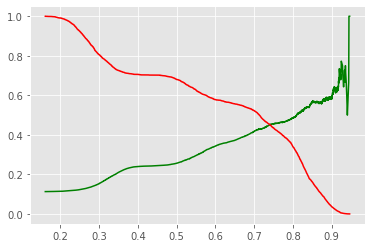

In [324]:
p, r, thresholds = precision_recall_curve(y_train_pred_final['response'], y_train_pred_final['response_Prob'])
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()### Based on the probability cutoff lets do predictions mapping again

### Draw ROC Curve

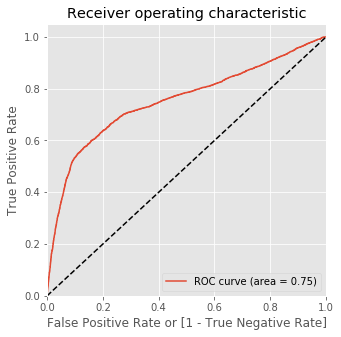

In [325]:
draw_roc(y_train_pred_final['response'],y_train_pred_final['response_Prob'])

### Lets store results in results_df

In [326]:
store_results(y_train_pred_final, #dataframe
              conf_matrix, #confusion_matrix
              'Logistic_NoDuration_with_PCA', #model_name
              6, #location or index
              'train' #train or test set
             )

## Evaluate model on test data and check the score

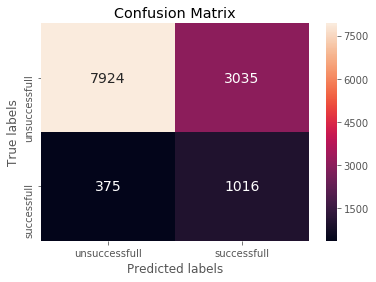

Accuracy score: 0.7238866396761133
Sensitivity score: 0.7304097771387491
Specificity score: 0.7230586732366092
f1-score: 0.37339213524439546
Precision score: 0.2508022710441866
Recall score: 0.7304097771387491
AUC: 0.77


In [327]:
# predict churn on test data
y_test_pred = logistic_noduration_pca_gridsearch.predict(X_test)

# check area under curve
y_pred_prob = logistic_noduration_pca_gridsearch.predict_proba(X_test)[:, 1]### Test model on test data and check the score 

# use funtcion to final predictions and confusion matrix
y_test_pred_final, conf_matrix = createfinaldf_and_checkscores(y_test,y_test_pred,y_pred_prob,
                                                                prob_cutoff=0.4)#cutoff probability is 0.4

### Draw ROC Curve

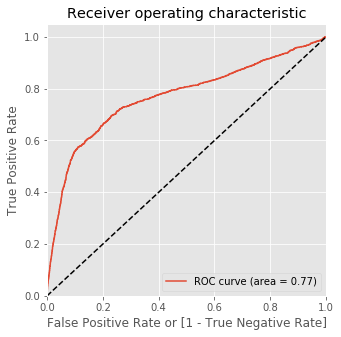

In [328]:
draw_roc(y_test_pred_final['response'],y_test_pred_final['response_Prob'])

### Lets store results in results_df

In [329]:
store_results(y_test_pred_final, #dataframe
              conf_matrix, #confusion_matrix
              'Logistic_NoDuration_with_PCA', #model_name
              6, #location or index
              'test' #train or test set
             )

In [330]:
results_df

,model_type,train_acc,train_sen,train_spec,train_f1,test_acc,test_sen,test_spec,test_f1
0,StatsModel,0.84,0.88,0.83,0.55,0.84,0.9,0.84,0.56
1,Logistic,0.85,0.87,0.85,0.57,0.86,0.87,0.86,0.58
2,Logistic_with_PCA,0.84,0.86,0.84,0.55,0.85,0.87,0.84,0.56
3,RandomForest,0.88,0.89,0.88,0.63,0.88,0.86,0.88,0.62
4,XGBoost,0.83,0.96,0.81,0.56,0.83,0.95,0.82,0.56
5,Logistic_NoDuration,0.7,0.71,0.7,0.35,0.71,0.74,0.71,0.37
6,Logistic_NoDuration_with_PCA,0.72,0.71,0.72,0.36,0.72,0.73,0.72,0.37


### Observations from above cell
- Duration feature is not chosen and Logistic Regression is build with and without PCA
- The train and test accuracy of PCA model is slightly better than normal model of Logistic Regression
- Logistic Regression without PCA gave slightly better train and test sensitivity and also we can iterpret the features so we will go with Logistic Regression Model without PCA for feature set without duration

<b>-----------------------</b>

# Final Model <u>without</u> feature 'duration' in the model

## Logistic Regression

In [331]:
#make numerical columns list using selected columns from stats model having low VIF
statsmodel_numerical_columns = list(X_train_selected.select_dtypes(exclude=['object']))

#Use Transformer to use scalar only on continuous variables
transformer = ColumnTransformer(transformers=[('std_scaler', StandardScaler(), statsmodel_numerical_columns)],
                                remainder='passthrough')

#create Logistic Regression variable
#using class_weight as 'balanced'
logistic_reg = LogisticRegression(class_weight='balanced',
                                 C = logistic_noduration_gridsearch.best_params_['logistic__C'], 
    penalty = logistic_noduration_gridsearch.best_params_['logistic__penalty'], 
    solver = logistic_noduration_gridsearch.best_params_['logistic__solver'], )#'{1:0.9, 0:0.1}')

#create steps variable
#these steps will be used in Pipeline during model building
steps = [('transform_scaler', transformer),
         ('logistic', logistic_reg)
        ]

#create pipeline
logistic_noduration_pipeline = Pipeline(steps)

## Fit the model

In [332]:
logistic_noduration_pipeline.fit(X_train_selected,y_train)

Pipeline(memory=None,
         steps=[('transform_scaler',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('std_scaler',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  ['campaign', 'cons.price.idx',
                                                   'cons.conf.idx',
                                                   'nr.employed', 'job',
                                                   'marital', 'education',
                                                   'default', 'housing', 'loan',
                                                   'cont...month',
   

### predict y_train data

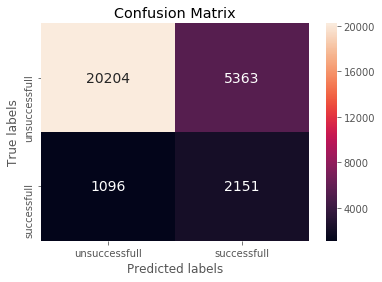

Accuracy score: 0.7758381342402999
Sensitivity score: 0.6624576532183554
Specificity score: 0.7902374154183127
f1-score: 0.3997769724003345
Precision score: 0.28626563747671013
Recall score: 0.6624576532183554
AUC: 0.77


In [333]:
y_train_pred = logistic_noduration_pipeline.predict(X_train_selected)
# check area under curve
y_train_pred_prob = logistic_noduration_pipeline.predict_proba(X_train_selected)[:, 1]
y_train_pred_final, conf_matrix = createfinaldf_and_checkscores(y_train,y_train_pred,y_train_pred_prob)

### <font size=3 color=blue>Lets check if we need to change the cutoff and see if senstivity and specificty can change</font>

In [334]:
#check_cutoff(y_train_pred_final)
cutoff_df = check_cutoff(y_train_pred_final)
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.112688  1.000000  0.000000
0.1   0.1  0.112758  1.000000  0.000078
0.2   0.2  0.173527  0.976286  0.071577
0.3   0.3  0.460054  0.855559  0.409825
0.4   0.4  0.702193  0.713582  0.700747
0.5   0.5  0.775838  0.662458  0.790237
0.6   0.6  0.846845  0.564521  0.882700
0.7   0.7  0.878740  0.455497  0.932491
0.8   0.8  0.893212  0.332615  0.964407
0.9   0.9  0.898660  0.175239  0.990535


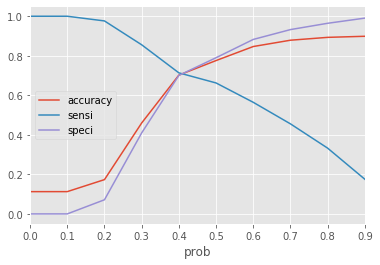

In [335]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

### Observations from above plot
- 0.4 is the optimum point to take it as cutoff probability

### Based on the probability cutoff lets do predictions mapping again

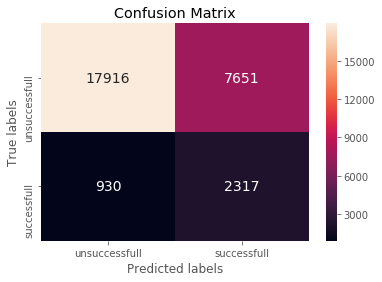

Accuracy score: 0.7021933782189214
Sensitivity score: 0.7135817677856483
Specificity score: 0.7007470567528454
f1-score: 0.3506621263715475
Precision score: 0.2324438202247191
Recall score: 0.7135817677856483
AUC: 0.77


In [336]:
y_train_pred_final, conf_matrix = createfinaldf_and_checkscores(y_train,y_train_pred,y_train_pred_prob,
                                                                prob_cutoff=0.4)

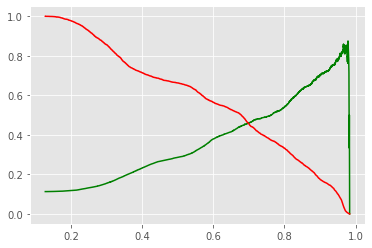

In [337]:
p, r, thresholds = precision_recall_curve(y_train_pred_final['response'], y_train_pred_final['response_Prob'])
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

### Draw ROC Curve

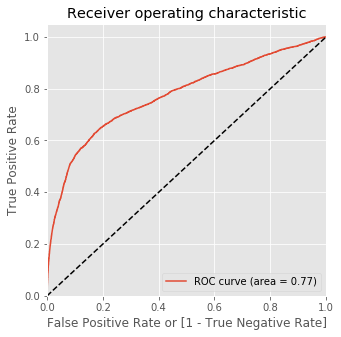

In [338]:
draw_roc(y_train_pred_final['response'],y_train_pred_final['response_Prob'])

## Evaluate model on test data and check the score

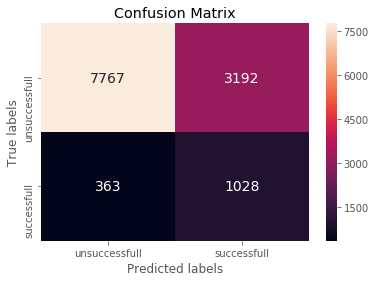

Accuracy score: 0.7121457489878542
Sensitivity score: 0.7390366642703091
Specificity score: 0.7087325485901999
f1-score: 0.3664230974870789
Precision score: 0.24360189573459715
Recall score: 0.7390366642703091
AUC: 0.79


In [339]:
# predict churn on test data
y_test_pred = logistic_noduration_pipeline.predict(X_test_selected)

# check area under curve
y_pred_prob = logistic_noduration_pipeline.predict_proba(X_test_selected)[:, 1]### Test model on test data and check the score 

# use funtcion to final predictions and confusion matrix
y_test_pred_final, conf_matrix = createfinaldf_and_checkscores(y_test,y_test_pred,y_pred_prob,
                                                               prob_cutoff=0.4)#cutoff probability found if 0.4

### Draw ROC Curve

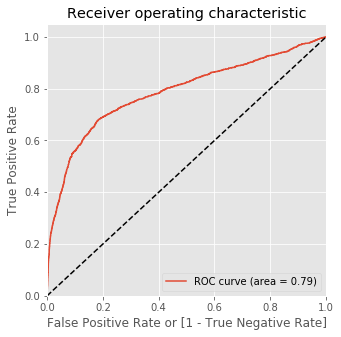

In [340]:
draw_roc(y_test_pred_final['response'],y_test_pred_final['response_Prob'])

### Feature Importance

In [341]:
#features list
features_list = logistic_noduration_pipeline.named_steps['transform_scaler'].transformers[0][2]

#features importance
features_importance = list(logistic_noduration_pipeline.named_steps['logistic'].coef_.round(4).tolist()[0])

#create dataframe with feature importance in percentage
params_df = pd.DataFrame({'feature':features_list,'coefficient':features_importance})
params_df = params_df.sort_values(by='coefficient',ascending=False).reset_index(drop=True)
params_df

,feature,coefficient
0,poutcome,0.2398
1,cons.conf.idx,0.1073
2,cons.price.idx,0.0933
3,education,0.0730
4,marital,0.0640
5,previous,0.0563
6,age_bins,0.0545
7,day_of_week,0.0374
8,job,0.0096
9,loan,0.0030


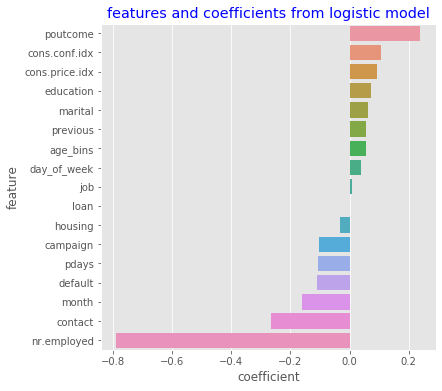

In [342]:
plt.figure(figsize=(6,6))
plt.title('features and coefficients from logistic model',color='blue')
sns.barplot(y='feature',x='coefficient',data=params_df);

### Observation from above plot
- nr.employed forms the very important predictor with negative coefficient.
- contact is also is an important predictor with negative coefficient. This means if the person is contacted less then there are more chance of the person responding to the campaign 

## Lets check train and test data set

In [343]:
print('shape of train data set: {0}'.format(y_train_pred_final.shape))
print('shape of test data set: {0}'.format(y_test_pred_final.shape))

shape of train data set: (28814, 4)
shape of test data set: (12350, 4)


### Lets make a copy of dataframe 
- This to avoid overwriting of original data

In [344]:
y_train_pred_final_copy = y_train_pred_final.copy()
y_test_pred_final_copy = y_test_pred_final.copy()

### Lets rearrange the columns

In [345]:
y_train_pred_final_copy = y_train_pred_final_copy[['responseId','response','predicted','response_Prob']]
y_train_pred_final_copy.head()

,responseId,response,predicted,response_Prob
0,33842,0,1,0.425902
1,11448,1,0,0.206661
2,9167,0,0,0.235564
3,20799,0,0,0.399199
4,36974,0,1,0.590026


In [346]:
y_test_pred_final_copy = y_test_pred_final_copy[['responseId','response','predicted','response_Prob']]
y_test_pred_final_copy.head()

,responseId,response,predicted,response_Prob
0,29844,0,0,0.380642
1,11597,0,0,0.198974
2,40908,1,1,0.808455
3,34918,0,1,0.414532
4,720,0,0,0.307647


<b>----------------------------------------------------------------------------------</b>

## Lift and Gain Charts

In [347]:
y_test_pred_final_copy.head()

,responseId,response,predicted,response_Prob
0,29844,0,0,0.380642
1,11597,0,0,0.198974
2,40908,1,1,0.808455
3,34918,0,1,0.414532
4,720,0,0,0.307647


In [348]:
y_test_pred_final_copy['duration'] = y_test_pred_final_copy['responseId'].map(lambda x:marketing_df.iloc[x]['duration'])
#duration is in seconds so we need to convert it into minutes and cost of call is 1 unit per minute
y_test_pred_final_copy['cost_of_Call'] = round(y_test_pred_final_copy['duration']/60) 
y_test_pred_final_copy.head()

,responseId,response,predicted,response_Prob,duration,cost_of_Call
0,29844,0,0,0.380642,534,9.0
1,11597,0,0,0.198974,11,0.0
2,40908,1,1,0.808455,253,4.0
3,34918,0,1,0.414532,241,4.0
4,720,0,0,0.307647,254,4.0


In [349]:
decile_df = y_test_pred_final_copy[['responseId','response_Prob','response','duration','cost_of_Call']].copy()
decile_df.head()

,responseId,response_Prob,response,duration,cost_of_Call
0,29844,0.380642,0,534,9.0
1,11597,0.198974,0,11,0.0
2,40908,0.808455,1,253,4.0
3,34918,0.414532,0,241,4.0
4,720,0.307647,0,254,4.0


In [350]:
decile_df['decile'] = pd.qcut(decile_df['response_Prob'], 10, labels=np.arange(10, 0, -1))

In [351]:
decile_df.head()

,responseId,response_Prob,response,duration,cost_of_Call,decile
0,29844,0.380642,0,534,9.0,4
1,11597,0.198974,0,11,0.0,10
2,40908,0.808455,1,253,4.0,1
3,34918,0.414532,0,241,4.0,4
4,720,0.307647,0,254,4.0,6


In [352]:
lift_df = decile_df.groupby('decile')['response_Prob'].count().reset_index()

In [353]:
lift_df.rename({'response_Prob':'total'}, axis=1, inplace=True)

In [354]:
lift_df_pred = decile_df[decile_df['response']==1].groupby('decile')['response'].count().reset_index()

In [355]:
#calculate average duration of every decile
lift_df_duration = decile_df[decile_df['response']==1].groupby('decile')['duration'].mean().reset_index()

In [356]:
#rename column
lift_df_duration.rename({'duration':'avg_duration'}, axis=1, inplace=True)

In [357]:
lift_df_final = lift_df.merge(lift_df_pred,on = 'decile')
lift_df_final = lift_df_final.merge(lift_df_duration,on = 'decile')

In [358]:
#calculate total cost of call of every decile
lift_df_callcost = decile_df[decile_df['response']==1].groupby('decile')['cost_of_Call'].sum().reset_index()

In [359]:
#rename column
lift_df_callcost.rename({'cost_of_Call':'total_callcost'}, axis=1, inplace=True)

In [360]:
lift_df_final = lift_df_final.merge(lift_df_callcost,on = 'decile')

In [361]:
lift_df_final = lift_df_final.sort_values(['decile'], ascending=False)

In [362]:
#calculate cumulative sum of response
lift_df_final['cumresp'] = lift_df_final['response'].cumsum()

In [363]:
lift_df_final['gain'] = 100*(lift_df_final['cumresp']/sum(lift_df_final['response']))

In [364]:
lift_df_final['cumlift'] = lift_df_final['gain']/(lift_df_final['decile'].astype('int')*(100/10))

In [365]:
lift_df_final

,decile,total,response,avg_duration,total_callcost,cumresp,gain,cumlift
9,1,1235,596,377.916107,3753.0,596,42.846873,4.284687
8,2,1235,274,443.167883,2027.0,870,62.544932,3.127247
7,3,1235,127,590.795276,1247.0,997,71.675054,2.389168
6,4,1235,72,792.166667,949.0,1069,76.851186,1.921280
5,5,1235,60,841.500000,840.0,1129,81.164630,1.623293
4,6,1234,57,805.701754,765.0,1186,85.262401,1.421040
3,7,1236,46,821.652174,631.0,1232,88.569375,1.265277
2,8,1235,52,847.980769,732.0,1284,92.307692,1.153846
1,9,1235,52,775.788462,672.0,1336,96.046010,1.067178
0,10,1235,55,844.472727,772.0,1391,100.000000,1.000000


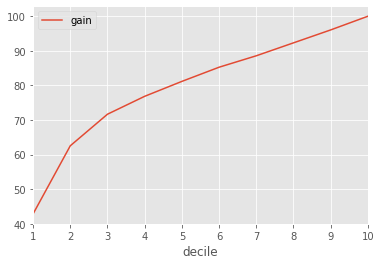

In [366]:
lift_df_final.plot.line(x='decile', y=['gain'])

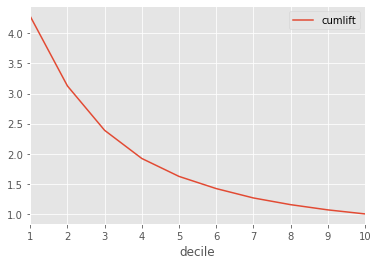

In [367]:
lift_df_final.plot.line(x='decile', y=['cumlift'])

## Observations from above cells
- One can attain more than 80% of total conversions by targeting 50% of the total client base. 
- Thus 50% of the total client base can be called to achieve 80% of the response rate

### Lets calculate the average call duration for targeting the top 50% prospects to acquire 80% of customers

In [368]:
average_duration = round(lift_df_final['avg_duration'][0:5].mean(),3)
print('Average call duration in seconds for targeting the top clients: {0}'.format(round(average_duration,3)))

Average call duration in seconds for targeting the top clients: 609.109


## Lets calculate Final Cost of acquistion

<b><font color=blue>Given that:</font></b>

Consider cost = 1*number of contacts made in the current campaign; 

determine the cost incurred for acquiring 80% of customers using the predictive model

<b>Since we have to target first 50% of client base to achieve 80% of acquisition rate, so we will add first 5 rows of total column of lift_df_final dataframe. This will give us the total contacts targeted  in top 50% client base. Using this we will calculate the cost as per the above given formula</b>

In [369]:
total_cost = lift_df_final['total_callcost'][0:5].sum()

print('Final Cost of acquisition to acquire 80% of customers: {0}'.format(total_cost))

Final Cost of acquisition to acquire 80% of customers: 8816.0


<b>----------------------------------------------------------------------------------</b>

# Conclusion and Recommendations
- Given the duration call not known beforehand, excluding this feature, Logistic Regression gave the best results with accuracy of model 71% and Sensitivity of model around 71%
- nr.employed, contact and poutcome form the important predictors 
- With this model, we can achieve 80% of acquisition by targeting top 50% of the total client base. 
- The total cost of acquisition to acquire 80% of customers is 8816 units
- The average call duration for targeting top 50% clients is 609.109 seconds